# Код к дипломной работе "Прогнозирование финансовых временных рядов на основе нейросетевого моделирования"

Ссылка на документ дипломной работы: https://docs.google.com/document/d/1ciPZ0Pcst6KXXqJLRojlIydu8yijgFCT/edit?usp=sharing&ouid=109219613179743380702&rtpof=true&sd=true

In [1]:
from urllib.parse import urlencode
from urllib.request import urlopen
from datetime import datetime
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DateFormatter
from datetime import timedelta
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import itertools
import tensorflow.keras as K
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

In [2]:
warnings.filterwarnings("ignore")
tf.random.set_seed(1)

# Функции

In [3]:
def download_data(ticker, period, start, end):
    '''
    ticker - название тикера
    period - Выбор из: 'tick': 1, 
                       'min': 2, 
                       '5min': 3, 
                       '10min': 4, 
                       '15min': 5, 
                       '30min': 6, 
                       'hour': 7, 
                       'daily': 8, 
                       'week': 9, 
                       'month': 10
    start - с какой даты начинать тянуть котировки
    end - финальная дата, по которую тянуть котировки
    '''
    periods={'tick': 1, 'min': 2, '5min': 3, '10min': 4, '15min': 5, '30min': 6, 'hour': 7, 'daily': 8, 'week': 9, 'month': 10}
    #каждой акции Финам присвоил цифровой код:
    tickers={'ICE.BRN': 19473,'NYMEX.NG':18949,'ABRD':82460,'AESL':181867,'AFKS':19715,'AFLT':29,'AGRO':399716,'AKRN':17564,'ALBK':82616,'ALNU':81882,'ALRS':81820,'AMEZ':20702,'APTK':13855,'AQUA':35238,'ARMD':19676,'ARSA':19915,'ASSB':16452,'AVAN':82843,'AVAZ':39,'AVAZP':40,'BANE':81757,'BANEP':81758,'BGDE':175840,'BISV':35242,'BISVP':35243,'BLNG':21078,'BRZL':81901,'BSPB':20066,'CBOM':420694,'CHEP':20999,'CHGZ':81933,'CHKZ':21000,'CHMF':16136,'CHMK':21001,'CHZN':19960,'CLSB':16712,'CLSBP':16713,'CNTL':21002,'CNTLP':81575,'DASB':16825,'DGBZ':17919,'DIOD':35363,'DIXY':18564,'DVEC':19724,'DZRD':74744,'DZRDP':74745,'ELTZ':81934,'ENRU':16440,'EPLN':451471,'ERCO':81935,'FEES':20509,'FESH':20708,'FORTP':82164,'GAZA':81997,'GAZAP':81998,'GAZC':81398,'GAZP':16842,'GAZS':81399,'GAZT':82115,'GCHE':20125,'GMKN':795,'GRAZ':16610,'GRNT':449114,'GTLC':152876,'GTPR':175842,'GTSS':436120,'HALS':17698,'HIMC':81939,'HIMCP':81940,'HYDR':20266,'IDJT':388276,'IDVP':409486,'IGST':81885,'IGST03':81886,'IGSTP':81887,'IRAO':20516,'IRGZ':9,'IRKT':15547,'ISKJ':17137,'JNOS':15722,'JNOSP':15723,'KAZT':81941,'KAZTP':81942,'KBSB':19916,'KBTK':35285,'KCHE':20030,'KCHEP':20498,'KGKC':83261,'KGKCP':152350,'KLSB':16329,'KMAZ':15544,'KMEZ':22525,'KMTZ':81903,'KOGK':20710,'KRKN':81891,'KRKNP':81892,'KRKO':81905,'KRKOP':81906,'KROT':510,'KROTP':511,'KRSB':20912,'KRSBP':20913,'KRSG':15518,'KSGR':75094,'KTSB':16284,'KTSBP':16285,'KUBE':522,'KUNF':81943,'KUZB':83165,'KZMS':17359,'KZOS':81856,'KZOSP':81857,'LIFE':74584,'LKOH':8,'LNTA':385792,'LNZL':21004,'LNZLP':22094,'LPSB':16276,'LSNG':31,'LSNGP':542,'LSRG':19736,'LVHK':152517,'MAGE':74562,'MAGEP':74563,'MAGN':16782,'MERF':20947,'MFGS':30,'MFGSP':51,'MFON':152516,'MGNT':17086,'MGNZ':20892,'MGTS':12984,'MGTSP':12983,'MGVM':81829,'MISB':16330,'MISBP':16331,'MNFD':80390,'MOBB':82890,'MOEX':152798,'MORI':81944,'MOTZ':21116,'MRKC':20235,'MRKK':20412,'MRKP':20107,'MRKS':20346,'MRKU':20402,'MRKV':20286,'MRKY':20681,'MRKZ':20309,'MRSB':16359,'MSNG':6,'MSRS':16917,'MSST':152676,'MSTT':74549,'MTLR':21018,'MTLRP':80745,'MTSS':15523,'MUGS':81945,'MUGSP':81946,'MVID':19737,'NAUK':81992,'NFAZ':81287,'NKHP':450432,'NKNC':20100,'NKNCP':20101,'NKSH':81947,'NLMK':17046,'NMTP':19629,'NNSB':16615,'NNSBP':16616,'NPOF':81858,'NSVZ':81929,'NVTK':17370,'ODVA':20737,'OFCB':80728,'OGKB':18684,'OMSH':22891,'OMZZP':15844,'OPIN':20711,'OSMP':21006,'OTCP':407627,'PAZA':81896,'PHOR':81114,'PHST':19717,'PIKK':18654,'PLSM':81241,'PLZL':17123,'PMSB':16908,'PMSBP':16909,'POLY':175924,'PRFN':83121,'PRIM':17850,'PRIN':22806,'PRMB':80818,'PRTK':35247,'PSBR':152320,'QIWI':181610,'RASP':17713,'RBCM':74779,'RDRB':181755,'RGSS':181934,'RKKE':20321,'RLMN':152677,'RLMNP':388313,'RNAV':66644,'RODNP':66693,'ROLO':181316,'ROSB':16866,'ROSN':17273,'ROST':20637,'RSTI':20971,'RSTIP':20972,'RTGZ':152397,'RTKM':7,'RTKMP':15,'RTSB':16783,'RTSBP':16784,'RUAL':414279,'RUALR':74718,'RUGR':66893,'RUSI':81786,'RUSP':20712,'RZSB':16455,'SAGO':445,'SAGOP':70,'SARE':11,'SAREP':24,'SBER':3,'SBERP':23,'SELG':81360,'SELGP':82610,'SELL':21166,'SIBG':436091,'SIBN':2,'SKYC':83122,'SNGS':4,'SNGSP':13,'STSB':20087,'STSBP':20088,'SVAV':16080,'SYNG':19651,'SZPR':22401,'TAER':80593,'TANL':81914,'TANLP':81915,'TASB':16265,'TASBP':16266,'TATN':825,'TATNP':826,'TGKA':18382,'TGKB':17597,'TGKBP':18189,'TGKD':18310,'TGKDP':18391,'TGKN':18176,'TGKO':81899,'TNSE':420644,'TORS':16797,'TORSP':16798,'TRCN':74561,'TRMK':18441,'TRNFP':1012,'TTLK':18371,'TUCH':74746,'TUZA':20716,'UCSS':175781,'UKUZ':20717,'UNAC':22843,'UNKL':82493,'UPRO':18584,'URFD':75124,'URKA':19623,'URKZ':82611,'USBN':81953,'UTAR':15522,'UTII':81040,'UTSY':419504,'UWGN':414560,'VDSB':16352,'VGSB':16456,'VGSBP':16457,'VJGZ':81954,'VJGZP':81955,'VLHZ':17257,'VRAO':20958,'VRAOP':20959,'VRSB':16546,'VRSBP':16547,'VSMO':15965,'VSYD':83251,'VSYDP':83252,'VTBR':19043,'VTGK':19632,'VTRS':82886,'VZRZ':17068,'VZRZP':17067,'WTCM':19095,'WTCMP':19096,'YAKG':81917,'YKEN':81766,'YKENP':81769,'YNDX':388383,'YRSB':16342,'YRSBP':16343,'ZHIV':181674,'ZILL':81918,'ZMZN':556,'ZMZNP':603,'ZVEZ':82001}
    FINAM_URL = "http://export.finam.ru/"# сервер, на который стучимся
    market = 0
    #Делаем преобразования дат:
    start_date = datetime.strptime(start, "%d.%m.%Y").date()
    start_date_rev=datetime.strptime(start, '%d.%m.%Y').strftime('%Y%m%d')
    end_date = datetime.strptime(end, "%d.%m.%Y").date()
    end_date_rev=datetime.strptime(end, '%d.%m.%Y').strftime('%Y%m%d')
    params = urlencode([
                        ('market', market), #на каком рынке торгуется бумага
                        ('em', tickers[ticker]), #вытягиваем цифровой символ, который соответствует бумаге.
                        ('code', ticker), #тикер нашей акции
                        ('apply',0), #не нашёл что это значит. 
                        ('df', start_date.day), #Начальная дата, номер дня (1-31)
                        ('mf', start_date.month - 1), #Начальная дата, номер месяца (0-11)
                        ('yf', start_date.year), #Начальная дата, год
                        ('from', start_date), #Начальная дата полностью
                        ('dt', end_date.day), #Конечная дата, номер дня	
                        ('mt', end_date.month - 1), #Конечная дата, номер месяца
                        ('yt', end_date.year), #Конечная дата, год
                        ('to', end_date), #Конечная дата
                        ('p', period), #Таймфрейм
                        ('f', ticker+"_" + start_date_rev + "_" + end_date_rev), #Имя сформированного файла
                        ('e', ".csv"), #Расширение сформированного файла
                        ('cn', ticker), #ещё раз тикер акции	
                        ('dtf', 1), #В каком формате брать даты. Выбор из 5 возможных. См. страницу https://www.finam.ru/profile/moex-akcii/sberbank/export/
                        ('tmf', 1), #В каком формате брать время. Выбор из 4 возможных.
                        ('MSOR', 0), #Время свечи (0 - open; 1 - close)	
                        ('mstime', "on"), #Московское время	
                        ('mstimever', 1), #Коррекция часового пояса	
                        ('sep', 1), #Разделитель полей	(1 - запятая, 2 - точка, 3 - точка с запятой, 4 - табуляция, 5 - пробел)
                        ('sep2', 1), #Разделитель разрядов
                        ('datf', 1), #Формат записи в файл. Выбор из 6 возможных.
                        ('at', 1)]) #Нужны ли заголовки столбцов
    url = FINAM_URL + ticker+"_" + start_date_rev + "_" + end_date_rev + ".csv?" + params #урл составлен!
    header= {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
          'AppleWebKit/537.11 (KHTML, like Gecko) '
          'Chrome/23.0.1271.64 Safari/537.11',
          'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
          'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
          'Accept-Encoding': 'none',
          'Accept-Language': 'en-US,en;q=0.8',
          'Connection': 'keep-alive'}
    req = urllib.request.Request(url=url, headers=header) 
    page = urllib.request.urlopen(req).read()
    page = [x.split(',') for x in str(page)[2:-1].split('\\r\\n')]
    df = pd.DataFrame(page[1:], columns = page[0])
    df = df.iloc[:-1]
    df.columns = ['ticker','per','date','time','open','high','low','close','vol']
    df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')
    df[['open','high','low','close','vol']] = df[['open','high','low','close','vol']].apply(pd.to_numeric)
    return df

# Скачивание и визуализация данных

In [17]:
data_gazp = download_data('GAZP',8,'01.01.2020','01.01.2023')
data_rosn = download_data('ROSN',8,'01.01.2020','01.01.2023')
data_brent = download_data('ICE.BRN',8,'01.01.2020','01.01.2023')
data_gas = download_data('NYMEX.NG',8,'01.01.2020','01.01.2023')

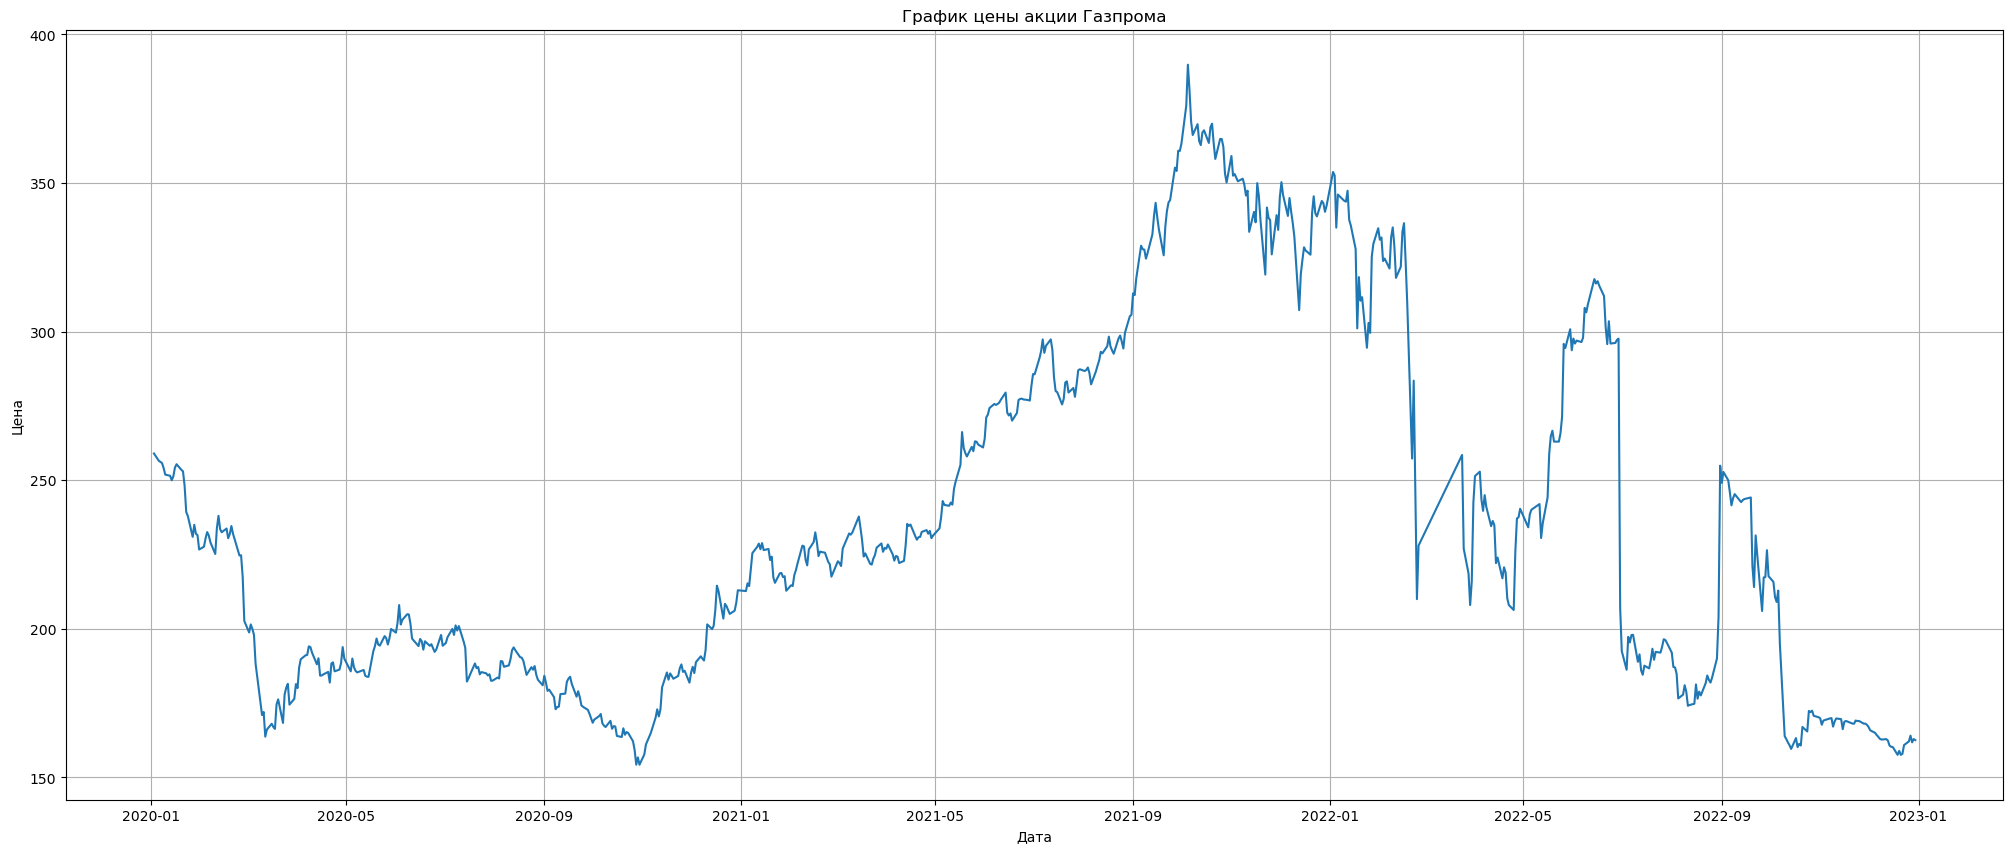

In [5]:
plt.figure(figsize = (25, 10))
plt.plot(data_gazp.date, data_gazp.close)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('График цены акции Газпрома')
plt.grid()
plt.show()

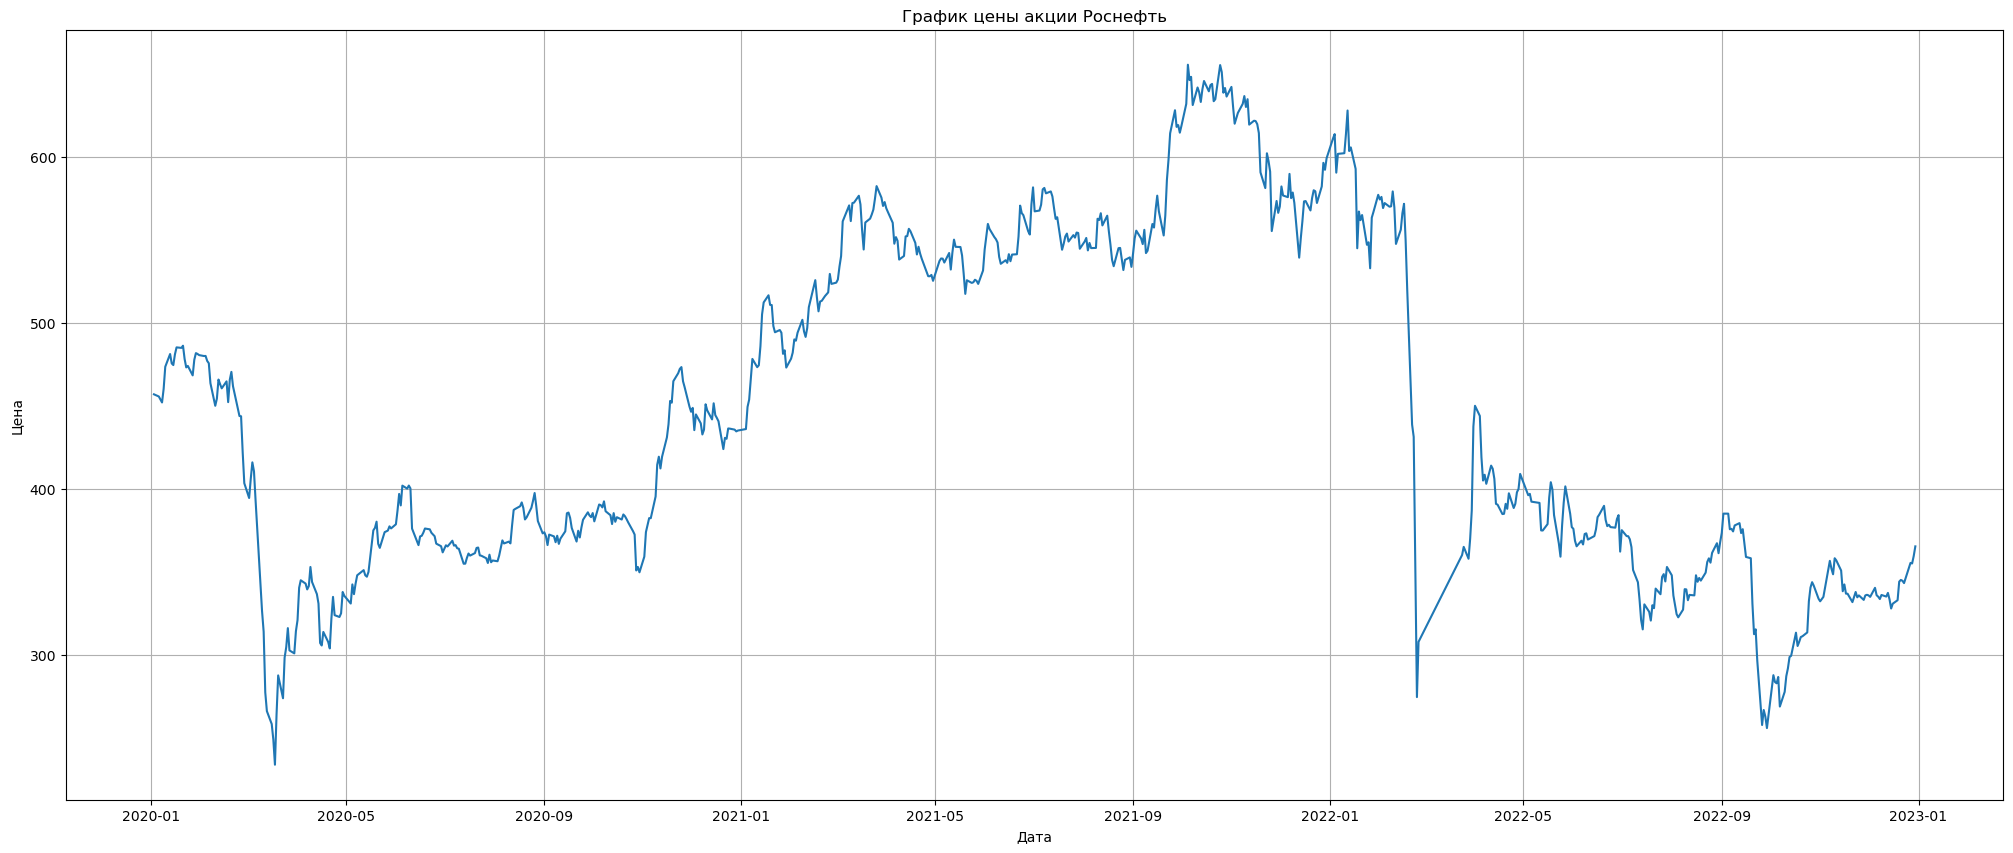

In [6]:
plt.figure(figsize = (25, 10))
plt.plot(data_rosn.date, data_rosn.close)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('График цены акции Роснефть')
plt.grid()
plt.show()

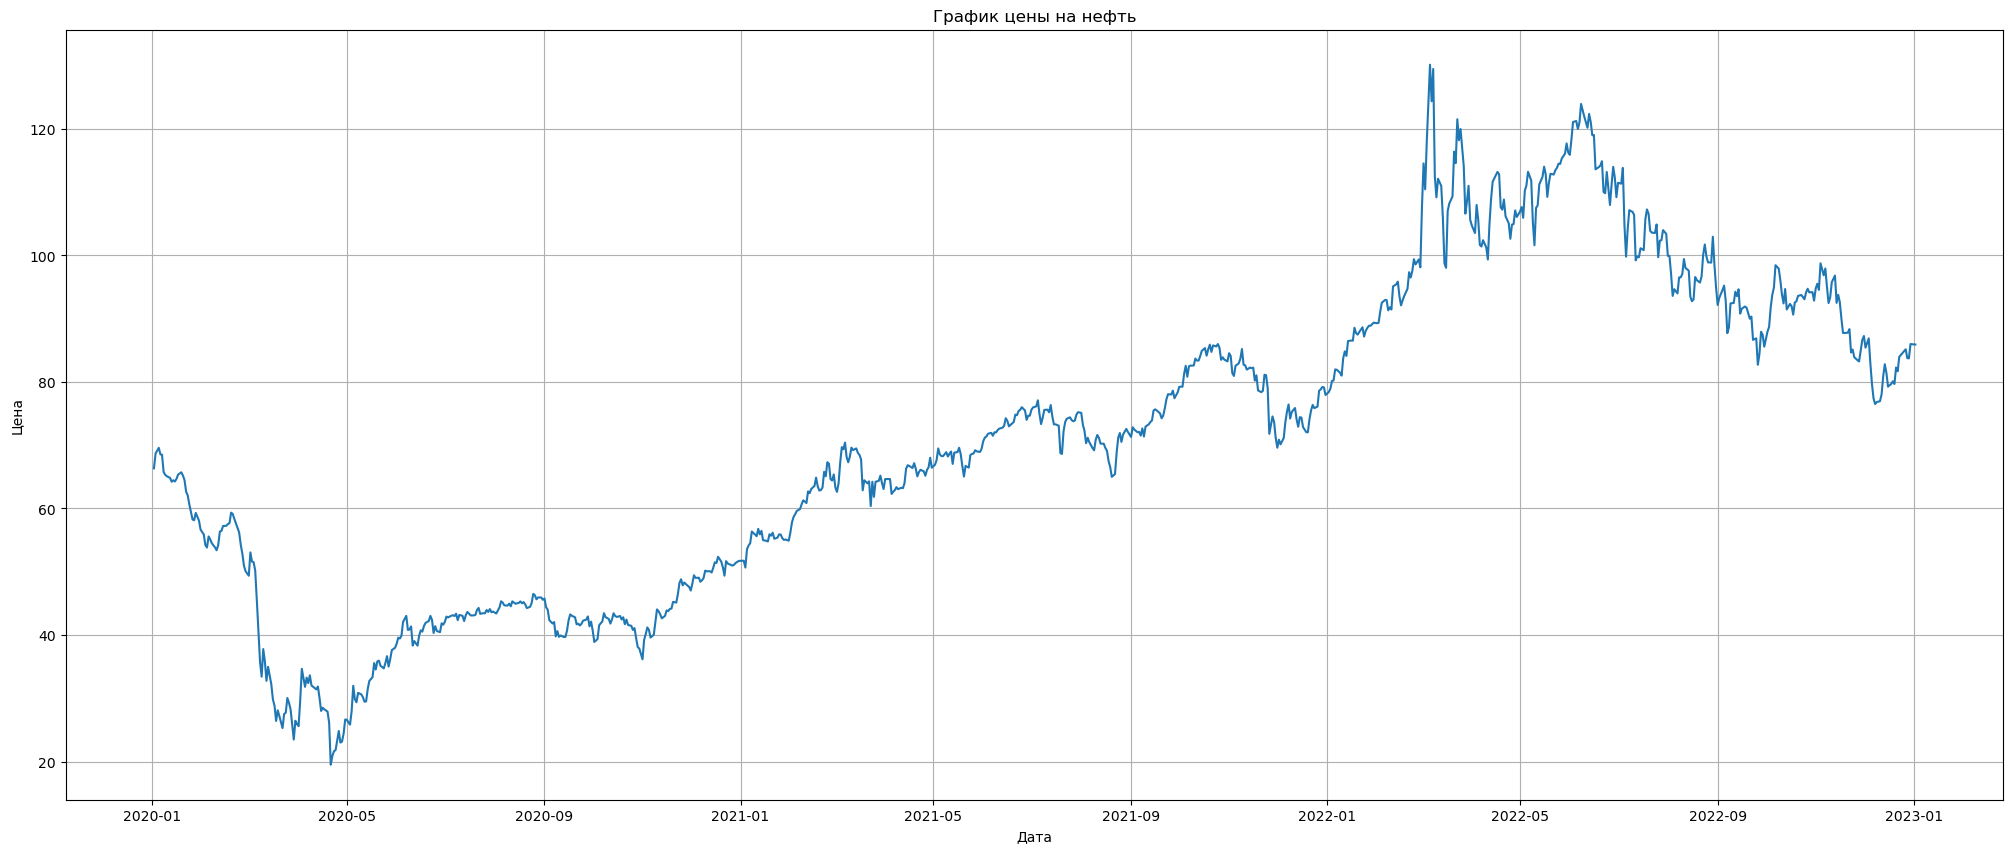

In [7]:
plt.figure(figsize = (25, 10))
plt.plot(data_brent.date, data_brent.close)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('График цены на нефть')
plt.grid()
plt.show()

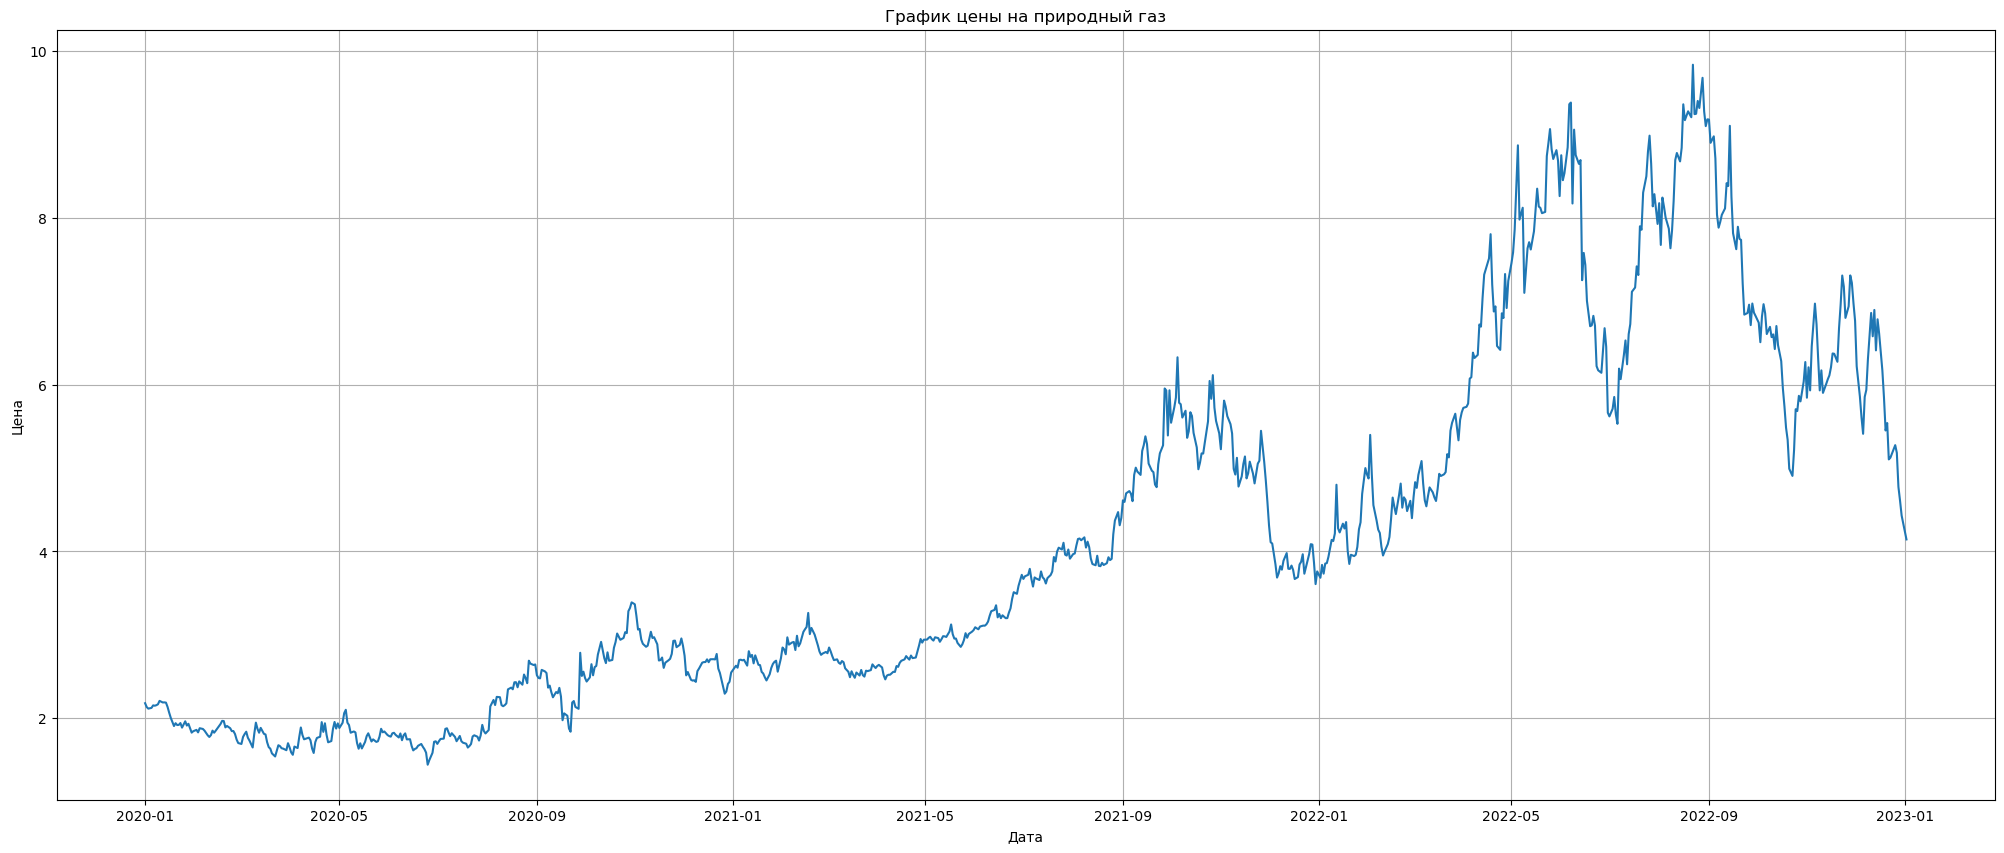

In [8]:
plt.figure(figsize = (25, 10))
plt.plot(data_gas.date, data_gas.close)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('График цены на природный газ')
plt.grid()
plt.show()

# Анализ данных

In [22]:
def analyze(data, ticker):
    # статистика
    print(data.describe())
    
    # распределение цены закрытия
    sns.histplot(data.close, bins=100)
    plt.title(f'Распределение цены {ticker}')
    plt.show()
    
    # разделение на компоненты временного ряда
    close_val = data.close
    close_val.name = ticker
    decomposition = sm.tsa.seasonal_decompose(close_val, model='additive', period = 180)
    fig = decomposition.plot()
    plt.show()
    
    # объем торгов по по датам для анализа сезонности
    df = data.set_index('date')
    df_month = df.resample("M").mean()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax.bar(
        df_month['2020':].index, 
        df_month.loc['2020':, "vol"], 
        width=25, align='center')
    ax.set_title(f'Группировка объема торгов {ticker} по датам')
    plt.show()
    
    # ящик с усами
    data.boxplot(column = 'close')
    plt.title(f'Ящик с усами {ticker}')
    plt.show()
    
    # тест на стационарность
    adf_test = adfuller(data['close'])
    print('p-value = ' + str(adf_test[1]))
    
    if adf_test[1] < 0.05:
        print(f'Ряд {ticker} стационарен. p-value меньше критического значения 0.05')
    else:
        print(f'Ряд {ticker} не стационарен. p-value больше критического значения 0.05')

## Газпром

             open        high         low       close           vol
count  739.000000  739.000000  739.000000  739.000000  7.390000e+02
mean   235.942449  239.214560  231.796103  235.664939  5.446887e+07
std     59.819875   60.674464   58.778184   59.738936  4.246953e+07
min    153.960000  156.200000  126.530000  154.280000  6.053880e+06
25%    186.015000  188.095000  183.825000  185.875000  2.998175e+07
50%    223.810000  226.800000  220.730000  224.000000  4.364094e+07
75%    278.790000  283.525000  276.685000  279.830000  6.561703e+07
max    394.980000  397.640000  378.030000  389.820000  4.135501e+08


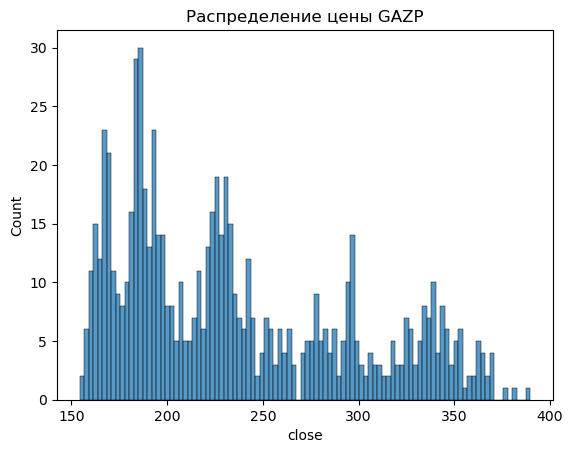

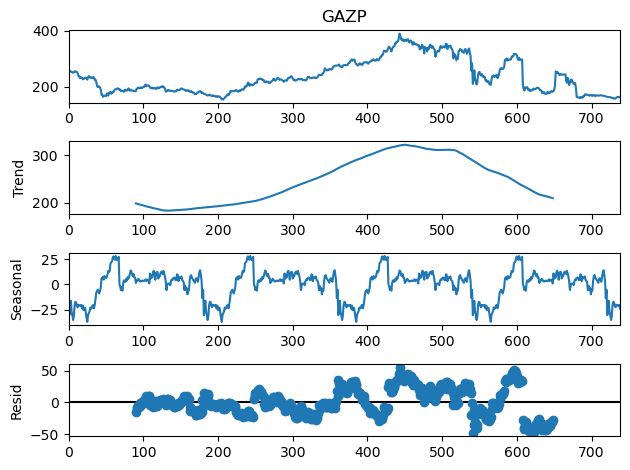

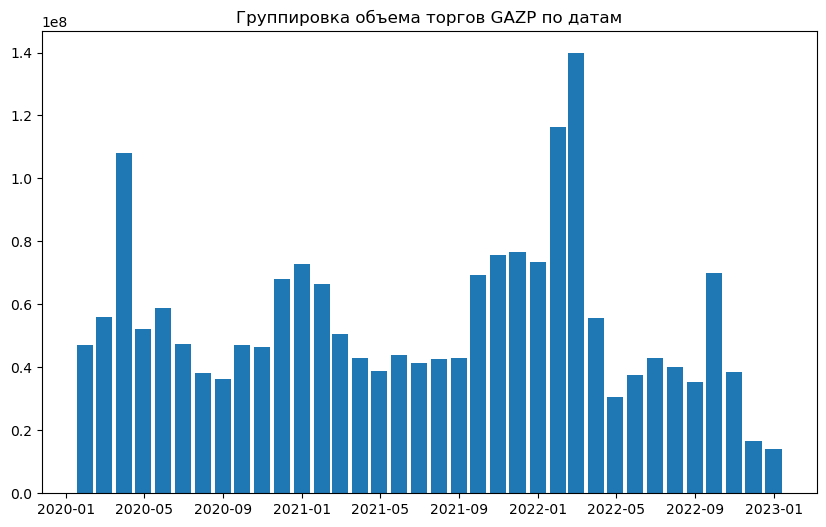

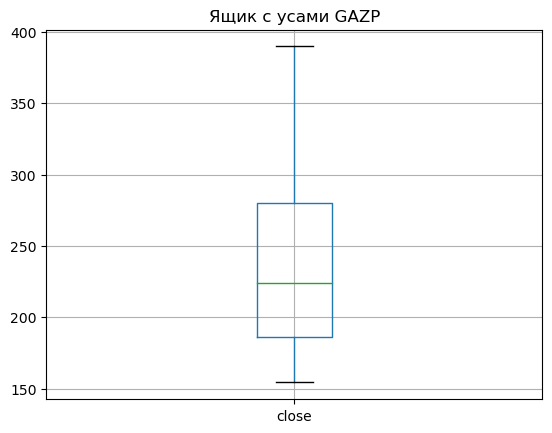

p-value = 0.5043362656871856
Ряд GAZP не стационарен. p-value больше критического значения 0.05


In [23]:
analyze(data_gazp, 'GAZP')

## Роснефть

             open        high         low       close           vol
count  739.000000  739.000000  739.000000  739.000000  7.390000e+02
mean   446.729635  453.026725  438.934438  446.346955  7.832831e+06
std    102.166451  102.544308  101.846237  102.221566  7.469283e+06
min    237.050000  244.750000  175.500000  234.000000  8.296760e+05
25%    363.950000  367.600000  358.100000  364.125000  3.635089e+06
50%    416.100000  424.000000  400.500000  414.550000  5.704950e+06
75%    546.400000  553.150000  538.500000  546.300000  9.254545e+06
max    660.850000  665.700000  649.300000  655.250000  7.954954e+07


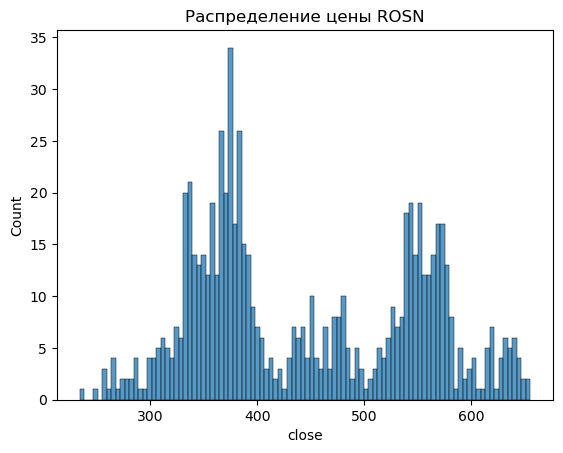

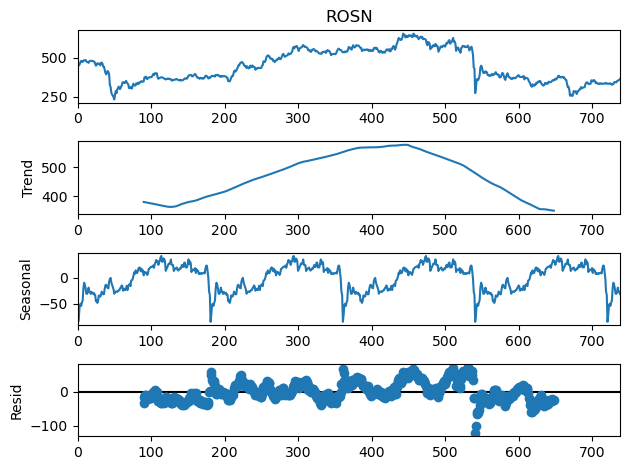

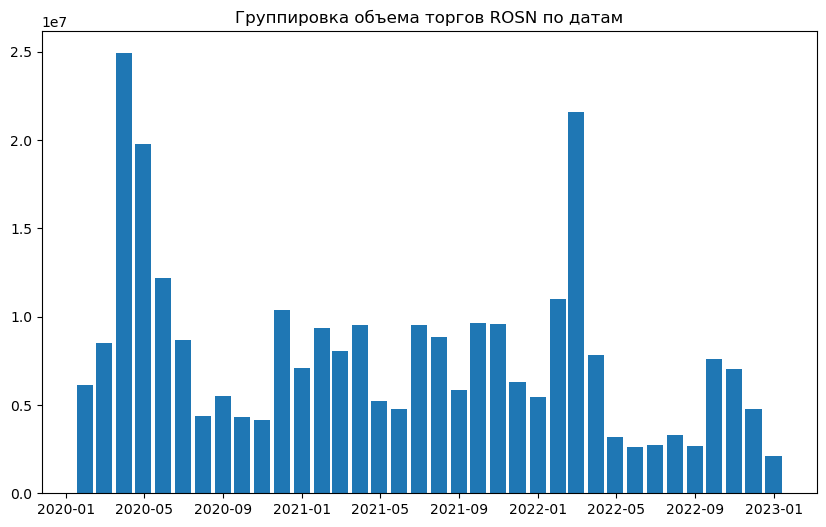

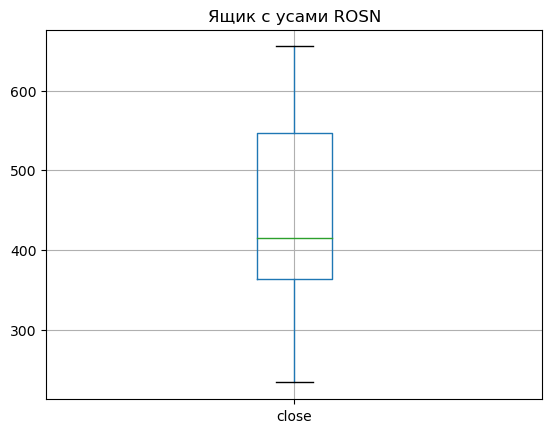

p-value = 0.40016117966845993
Ряд ROSN не стационарен. p-value больше критического значения 0.05


In [19]:
analyze(data_rosn, 'ROSN')

## Нефть

             open        high         low       close            vol
count  936.000000  936.000000  936.000000  936.000000     936.000000
mean    70.883665   72.073793   69.597126   70.902724  132869.107906
std     24.707519   25.135577   24.220338   24.694362   77522.308407
min     20.230000   22.450000   15.980000   19.500000       1.000000
25%     48.912500   49.490000   48.315000   48.960000   98909.750000
50%     71.210000   72.220000   70.170000   71.200000  140451.500000
75%     90.017500   92.060000   88.525000   90.005000  178839.250000
max    130.280000  139.130000  122.790000  130.140000  441434.000000


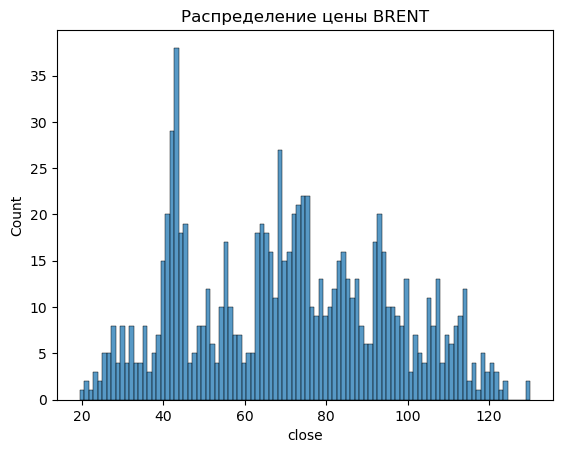

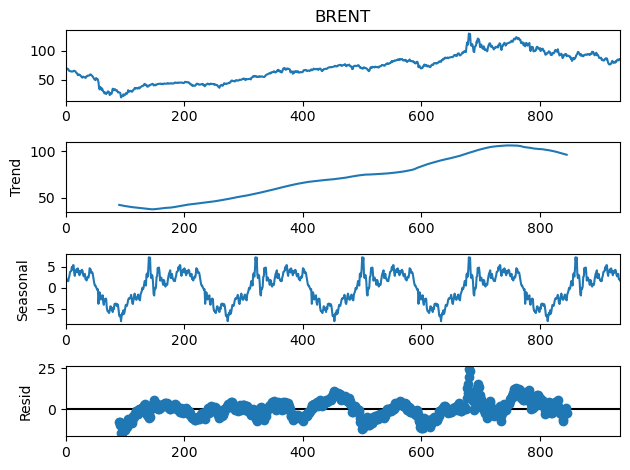

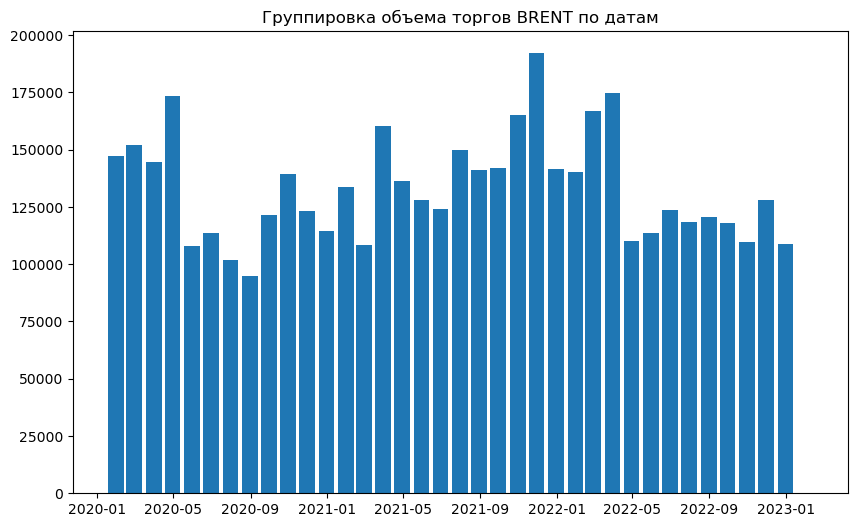

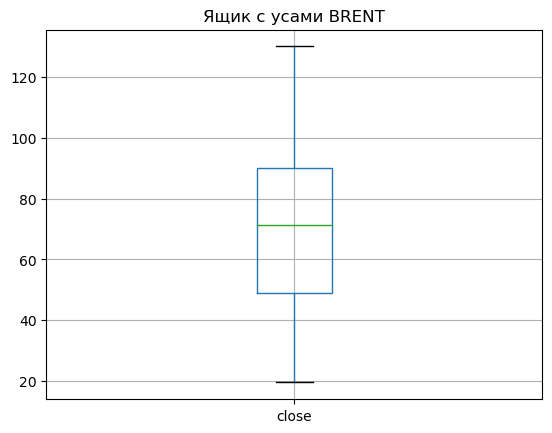

p-value = 0.7939891809393603
Ряд BRENT не стационарен. p-value больше критического значения 0.05


In [15]:
analyze(data_brent, 'BRENT')

## Природный газ

             open        high         low       close            vol
count  934.000000  934.000000  934.000000  934.000000     934.000000
mean     4.130585    4.248577    4.012043    4.130830   65896.953961
std      2.139417    2.217728    2.058042    2.137012   49234.753835
min      1.441000    1.543000    1.432000    1.441000       1.000000
25%      2.478250    2.548000    2.422750    2.482500   15845.750000
50%      3.613000    3.691500    3.555500    3.634000   67092.000000
75%      5.645000    5.796500    5.401750    5.624500   99353.500000
max      9.850000   10.028000    9.670000    9.839000  277081.000000


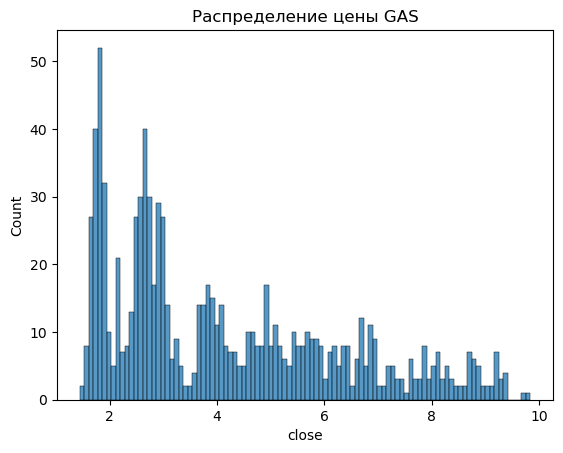

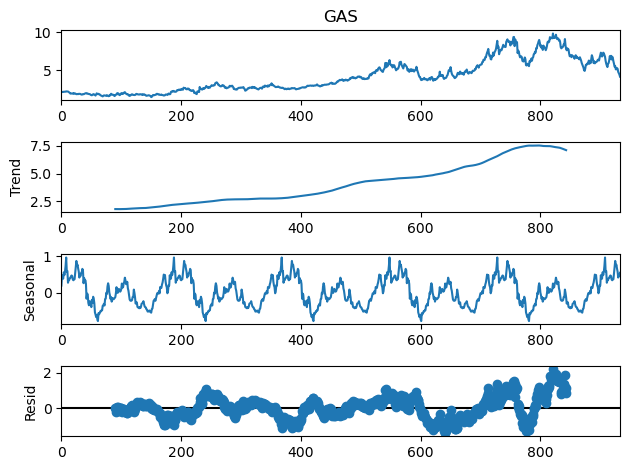

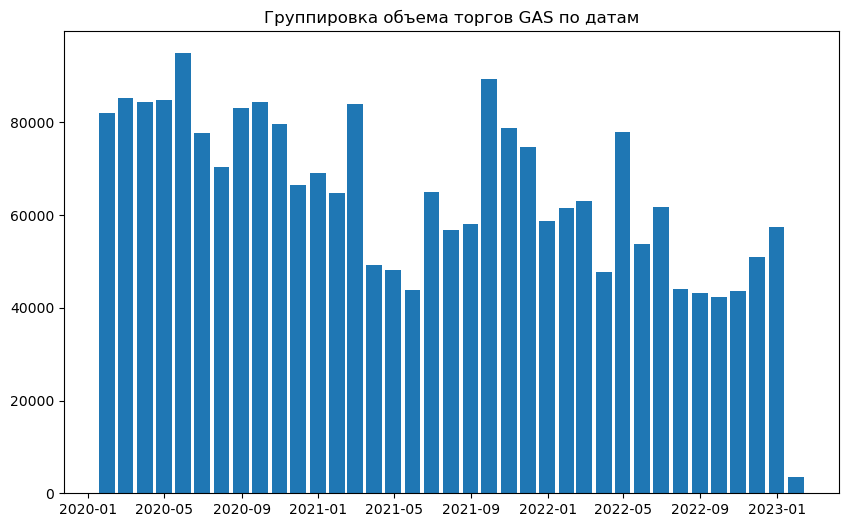

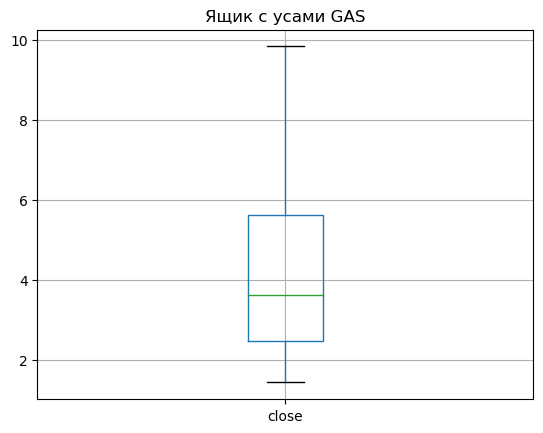

p-value = 0.4881910435362467
Ряд GAS не стационарен. p-value больше критического значения 0.05


In [16]:
analyze(data_gas, 'GAS')

# Экспоненциальное сглаживание

Модель экспоненциального сглаживания имеет вид:

$$ S_k = \alpha \cdot \epsilon_{k-1} + (1-\alpha) \cdot S_{k-1}$$
$ S_k - \text{прогнозируемое значение}$

$ \alpha - \text{параметр}$

$ S_{k-1} - \text{предшествующее экспоненциальное взвешенное значение}$

$ \epsilon_{k-1} - \text{фактический уровень ряда на прошлом шаге}$

In [14]:
data_loss_exp = pd.DataFrame(columns = ['ticker','alpha','mape','mae','mpe','rmse'])

In [15]:
def mpe(y_true, y_pred):
    return sum((y_true - y_pred)/y_true) * (1/len(y_true)) * 100

In [16]:
def exp_smoothing(data, ticker):
    global data_loss_exp
    
    alpha1 = 0.2
    alpha2 = 0.5

    # первое значение совпадает со значением временного ряда
    exp_smoothing_alpha1 = [data.close[0]]
    exp_smoothing_alpha2 = [data.close[0]]

    # в цикле for последовательно применяем формулу ко всем элементам ряда
    for i in range(1, len(data.close)):
        exp_smoothing_alpha1.append(alpha1 * data.close[i] + (1 - alpha1) * exp_smoothing_alpha1[i - 1])
        exp_smoothing_alpha2.append(alpha2 * data.close[i] + (1 - alpha2) * exp_smoothing_alpha2[i - 1])
    
    print('Прогнозируемое значение для alpha = 0.2', exp_smoothing_alpha1[-1])
    print('Прогнозируемое значение для alpha = 0.5', exp_smoothing_alpha2[-1])
    
    data['exp_smoothing_alpha1'] = exp_smoothing_alpha1
    data['exp_smoothing_alpha2'] = exp_smoothing_alpha2

    # возьмём последний индекс 
    last_date = data.iloc[[-1]].date

    # "прибавим" один день
    last_date = last_date + timedelta(days = 1)

    # добавим в датафрейм новую строк
    data = data.append(pd.DataFrame(index = data.iloc[[-1]].index))
    data['date'].iloc[-1] = last_date.values[0]

    # сдвинем столбец exp_smoothing
    data['exp_smoothing_alpha1'] = data['exp_smoothing_alpha1'].shift(1)
    data['exp_smoothing_alpha2'] = data['exp_smoothing_alpha2'].shift(1)
    
    # зададим размер
    plt.figure(figsize = (15,8))

    # выведем данные о цене и кривую экспоненциального сглаживания
    plt.plot(data.date, data.close, label = 'Цена закрытия', color = 'steelblue')
    plt.plot(data.date, data.exp_smoothing_alpha1, label = 'Экспоненциальное сглаживание alpha = 0.2', color = 'orange', linewidth = 1)
    plt.plot(data.date, data.exp_smoothing_alpha2, label = 'Экспоненциальное сглаживание alpha = 0.5', color = 'red', linewidth = 1)

    # добавим легенду, ее положение на графике и размер шрифта
    plt.legend(title = '', loc = 'upper left', fontsize = 8)

    # добавим подписи к осям и заголовки
    plt.ylabel('Цена', fontsize = 14)
    plt.xlabel('Месяцы', fontsize = 14)
    plt.title(f'Цена {ticker}', fontsize = 16)

    plt.show()
    
    y_true = data.close.iloc[1:-1].values
    y_pred = data.exp_smoothing_alpha1[1:-1].values
    losses1 = pd.DataFrame({'ticker':ticker,
              'alpha': alpha1,
              'mape': mean_absolute_percentage_error(y_true, y_pred),
              'mae': mean_absolute_error(y_true, y_pred),
              'mpe': mpe(y_true, y_pred),
              'rmse': np.sqrt(mean_squared_error(y_true, y_pred))},index=[0])
    
    y_true = data.close.iloc[1:-1].values
    y_pred = data.exp_smoothing_alpha2[1:-1].values
    losses2 = pd.DataFrame({'ticker':ticker,
              'alpha': alpha2,
              'mape': mean_absolute_percentage_error(y_true, y_pred),
              'mae': mean_absolute_error(y_true, y_pred),
              'mpe': mpe(y_true, y_pred),
              'rmse': np.sqrt(mean_squared_error(y_true, y_pred))},index=[0])
    
    data_loss_exp = pd.concat([data_loss_exp, losses1, losses2], ignore_index = True)

## Газпром

Прогнозируемое значение для alpha = 0.2 161.7945190761864
Прогнозируемое значение для alpha = 0.5 162.54031347841715


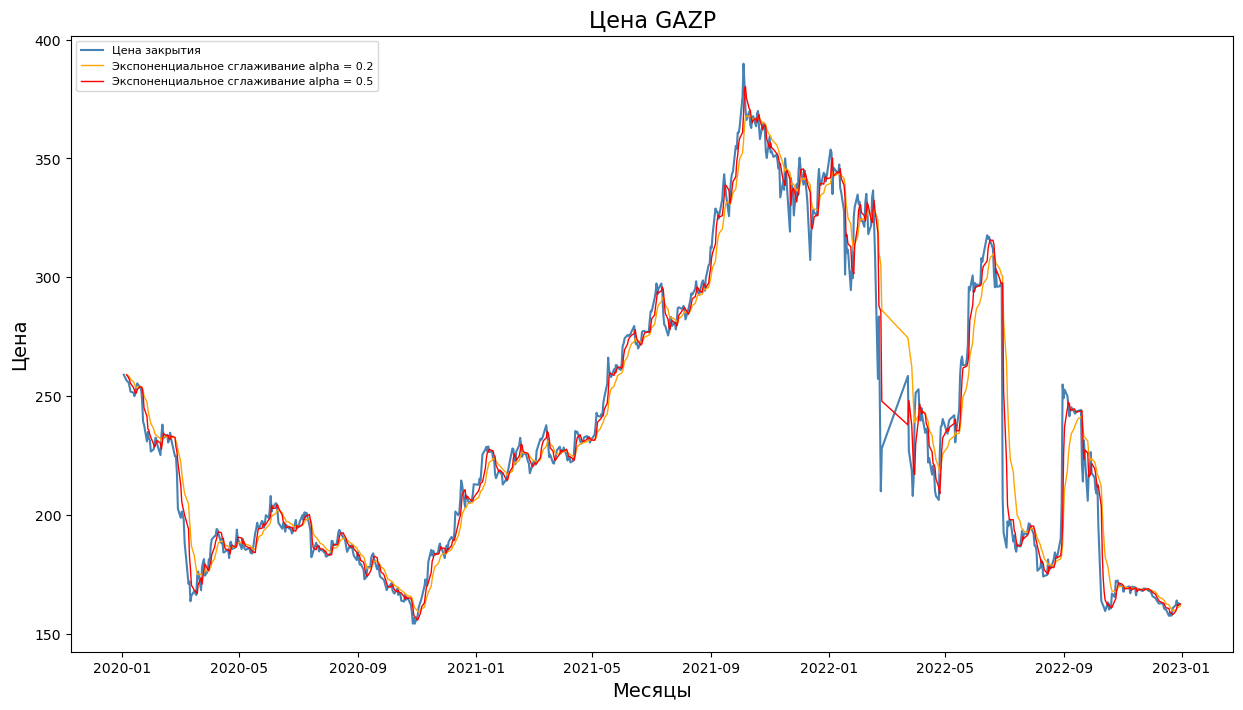

In [17]:
exp_smoothing(data_gazp, 'GAZP')

## Роснефть

Прогнозируемое значение для alpha = 0.2 352.6744732756033
Прогнозируемое значение для alpha = 0.5 360.94187951596865


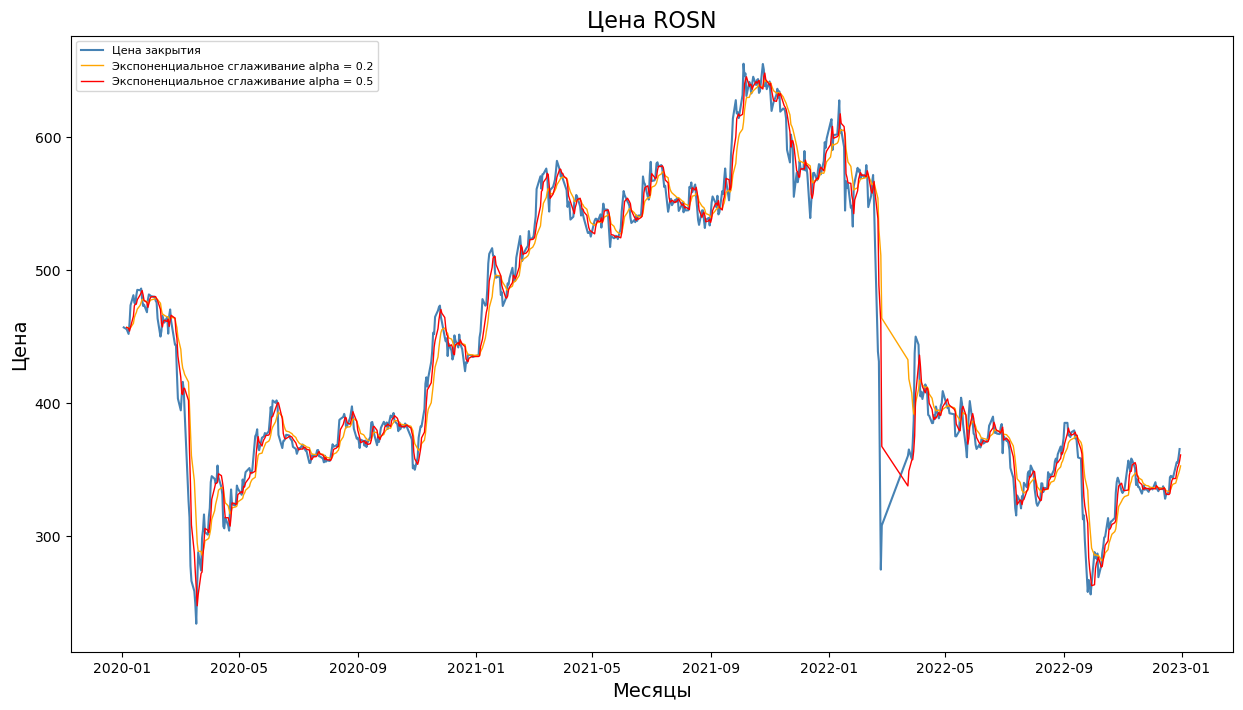

In [18]:
exp_smoothing(data_rosn, 'ROSN')

## Нефть

Прогнозируемое значение для alpha = 0.2 83.88733086557328
Прогнозируемое значение для alpha = 0.5 85.3992087345837


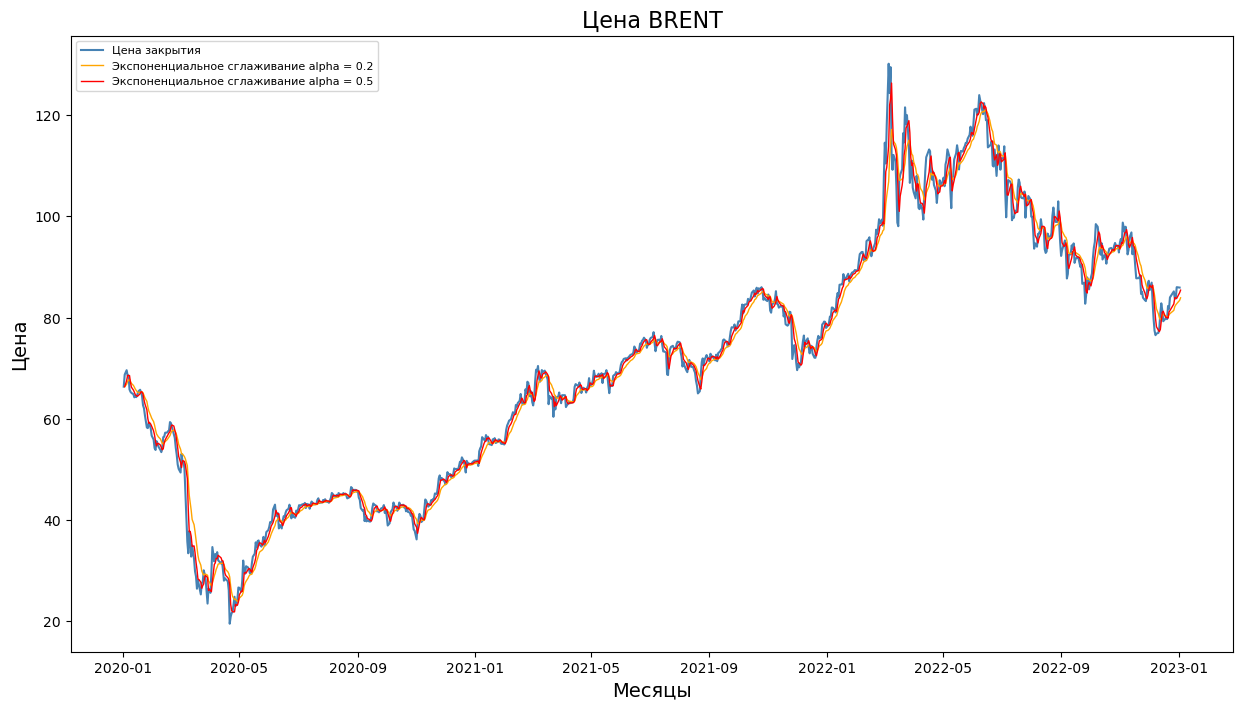

In [19]:
exp_smoothing(data_brent, 'BRENT')

## Природный газ

Прогнозируемое значение для alpha = 0.2 4.882017524837079
Прогнозируемое значение для alpha = 0.5 4.380492540045647


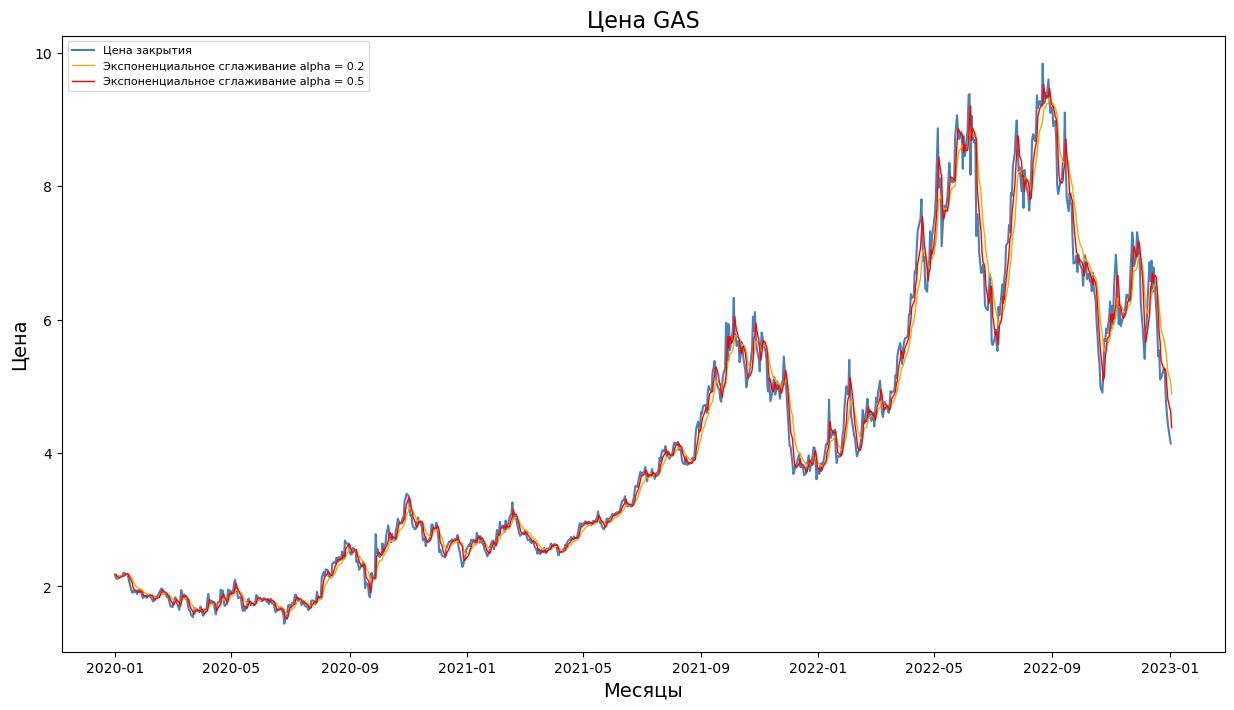

In [20]:
exp_smoothing(data_gas, 'GAS')

In [21]:
# ошибки прогнозирования
data_loss_exp

ticker  alpha      mape        mae       mpe       rmse
0   GAZP    0.2  0.033451   7.652482 -0.594667  12.875525
1   GAZP    0.5  0.020268   4.730678 -0.229929   8.780473
2   ROSN    0.2  0.031877  12.772295 -0.459574  21.302429
3   ROSN    0.5  0.021271   8.692896 -0.173767  14.502656
4  BRENT    0.2  0.033338   2.112879 -0.113319   3.057172
5  BRENT    0.5  0.022299   1.478034 -0.041664   2.252467
6    GAS    0.2  0.047621   0.211916  0.085107   0.320933
7    GAS    0.5  0.033976   0.150076 -0.000658   0.227276

In [335]:
data_gazp_test = download_data('GAZP',8,'01.01.2023','01.04.2023')
data_rosn_test = download_data('ROSN',8,'01.01.2023','01.04.2023')
data_brent_test = download_data('ICE.BRN',8,'01.01.2023','01.04.2023')
data_gas_test = download_data('NYMEX.NG',8,'01.01.2023','01.04.2023')

# ARIMA

Для временного ряда X модель ARIMA можно записать в виде:
$$\Delta^dX_t = \sum^p_{t=1}a_t\cdot\Delta^dX_{t-1}+\varepsilon_t+\sum^q_{j=1}b_j\cdot\Delta^d\varepsilon_{t-j}$$

$\Delta^d - \text{оператор разности порядка d}$

$a_t - \text{коэффициенты авторегрессионной модели}$

$\varepsilon_t - \text{значения ошибки}$

$b_j - \text{коэффициенты модели скользящего среднего}$

In [358]:
data_loss_arima = pd.DataFrame(columns = ['ticker','sample','pdq','mape','mae','mpe','rmse'])

In [359]:
def arima(data, data_test, ticker):
    global data_loss_arima
    data = data.set_index('date')['close']
    
    # поскольку ряд не стационарен, продиффенцируем его один раз и посмотрим на автокорреляционную и
    # частичную автокорреляционную функцию
    plt.figure(figsize = (9,3))
    plt.plot(data.diff())
    plt.title('Дифференцирование ряда')
    plt.show()

    plot_pacf(data.diff().dropna())
    plt.show()

    plot_acf(data.diff().dropna())
    plt.show()
    
    #найдем наилучшие значения для порядка авторегрессии и скользящего среднего
    #Оценку будем производить по метрике aic
    p = range(1,10)
    d = range(1,2)
    q = range(1,3)
    pdq = list(itertools.product(p, d, q))
    best_pdq = (0,0,0)
    best_aic = np.inf
    for params in pdq:
        model_test = ARIMA(data, order = params)
        result_test = model_test.fit()
        if result_test.aic < best_aic:
            best_pdq = params
            best_aic = result_test.aic
    
    #построение arima с наилучшими параметрами
    model = ARIMA(data, order=best_pdq)

    model_fit = model.fit()
    
    #прогноз и построение графика
    pred = model_fit.get_prediction(start=data.index[1], end=data.index[-1], dynamic=False)
    pred_ci = pred.conf_int()
    pred_mean_train = pred.predicted_mean
    
    ax = data.plot(label='реальные данные', figsize=(20, 10))
    pred.predicted_mean.plot(ax=ax, label='предсказание', alpha=.7)
    ax.fill_between(pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Цена')
    ax.set_title(f'График цены {ticker} на тренировочных данных')
    plt.legend()
    plt.show()  
    
    # анализ остатков авторегрессионной модели
    model_fit.plot_diagnostics(figsize=(15, 10))
    plt.show()
    
    #предсказание на тестовых данных
    pred = model_fit.get_forecast(steps = len(data_test), dynamic=False)
    pred_ci = pred.conf_int()
    pred_mean_test = pred.predicted_mean
    pred_mean_test.index = np.arange(0,len(data_test))
    pred_ci.index = np.arange(0,len(data_test))

    ax = data_test.close.plot(label='реальные данные', figsize=(10, 7))
    pred_mean_test.plot(ax=ax, label='предсказание', alpha=.7)
    ax.fill_between(pred_ci.index,
    pred_ci.iloc[:, 0].values,
    pred_ci.iloc[:, 1].values, color='k', alpha=.2)
    ax.set_xlabel('Шаг предсказания')
    ax.set_ylabel('Цена')
    ax.set_title(f'График цены {ticker} на тестовых данных')
    plt.legend()
    plt.show() 
    
    y_true = data.values[1:]
    y_pred = pred_mean_train
    losses1 = pd.DataFrame({'ticker':ticker,
                  'sample': 'train',
                  'pdq': [best_pdq],
                  'mape': mean_absolute_percentage_error(y_true, y_pred),
                  'mae': mean_absolute_error(y_true, y_pred),
                  'mpe': mpe(y_true, y_pred),
                  'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])
    
    y_true = data_test.close.values
    y_pred = pred_mean_test
    losses2 = pd.DataFrame({'ticker':ticker,
                  'sample': 'test',
                  'pdq': [best_pdq],
                  'mape': mean_absolute_percentage_error(y_true, y_pred),
                  'mae': mean_absolute_error(y_true, y_pred),
                  'mpe': mpe(y_true, y_pred),
                  'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])
    
    data_loss_arima = pd.concat([data_loss_arima, losses1, losses2], ignore_index = True)

## Газпром

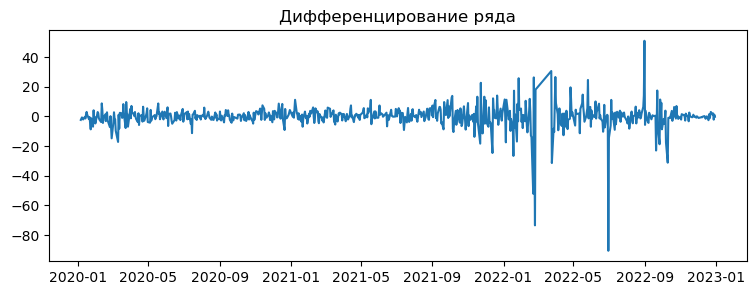

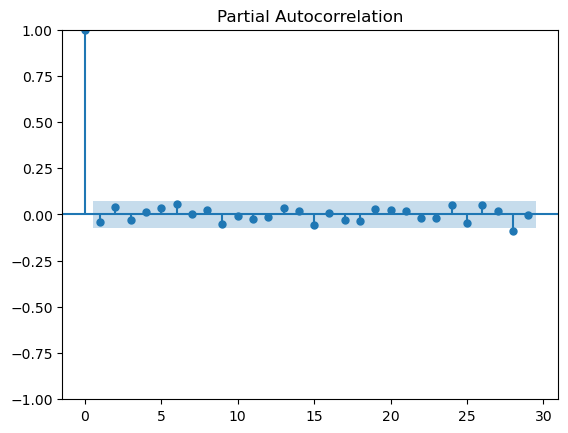

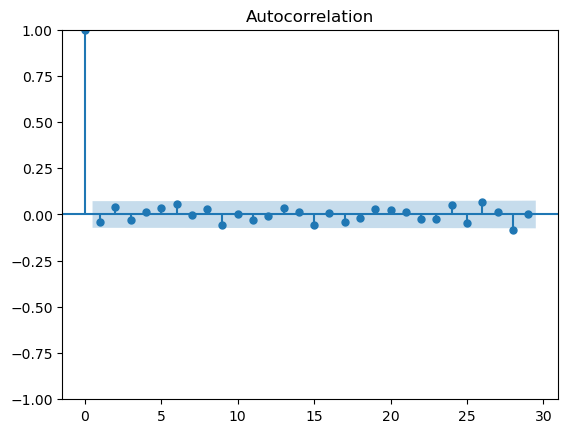

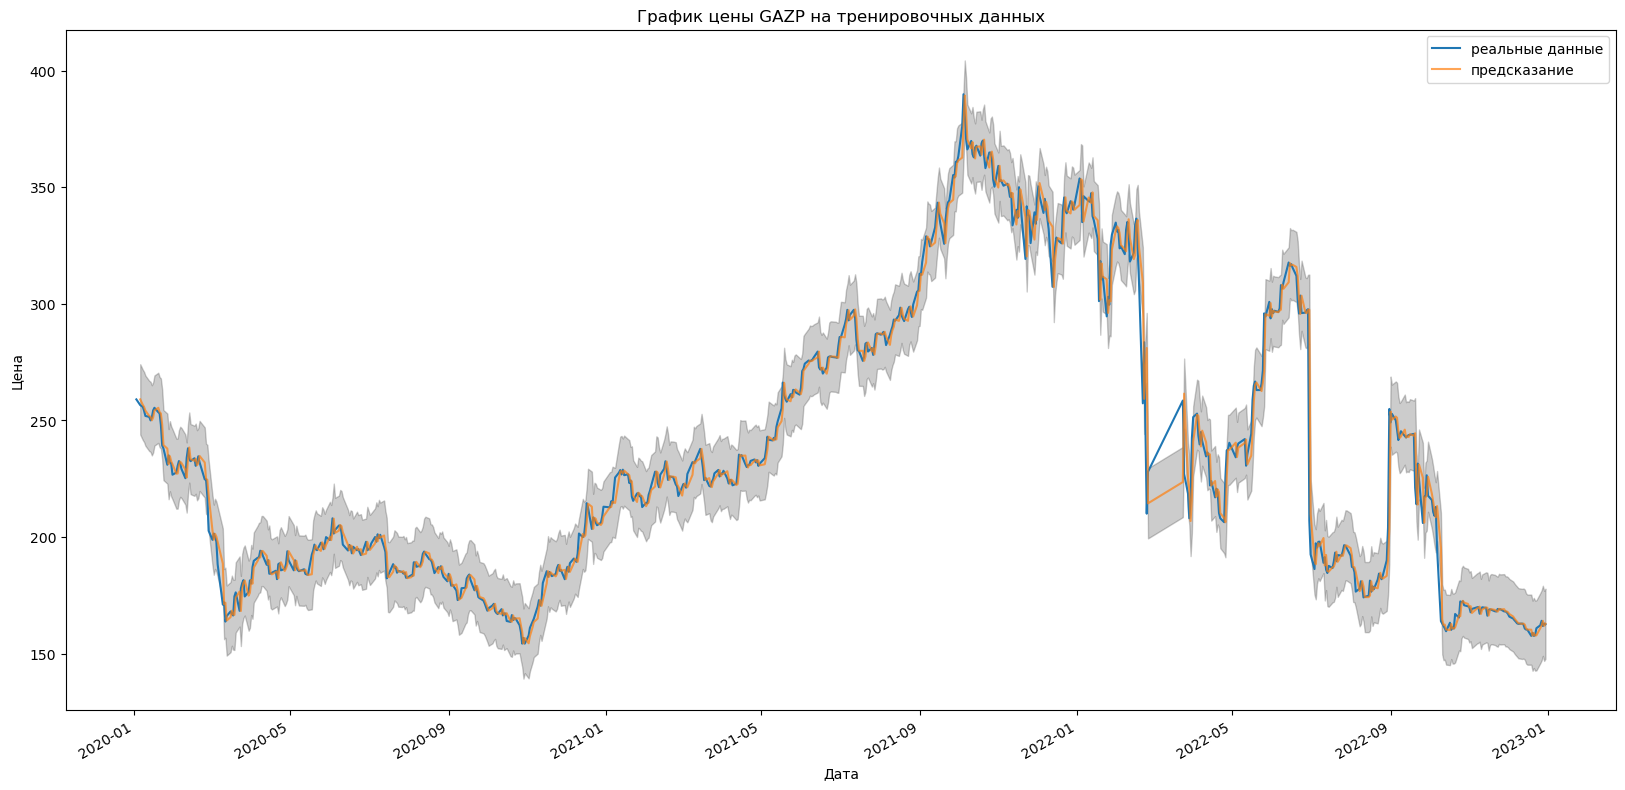

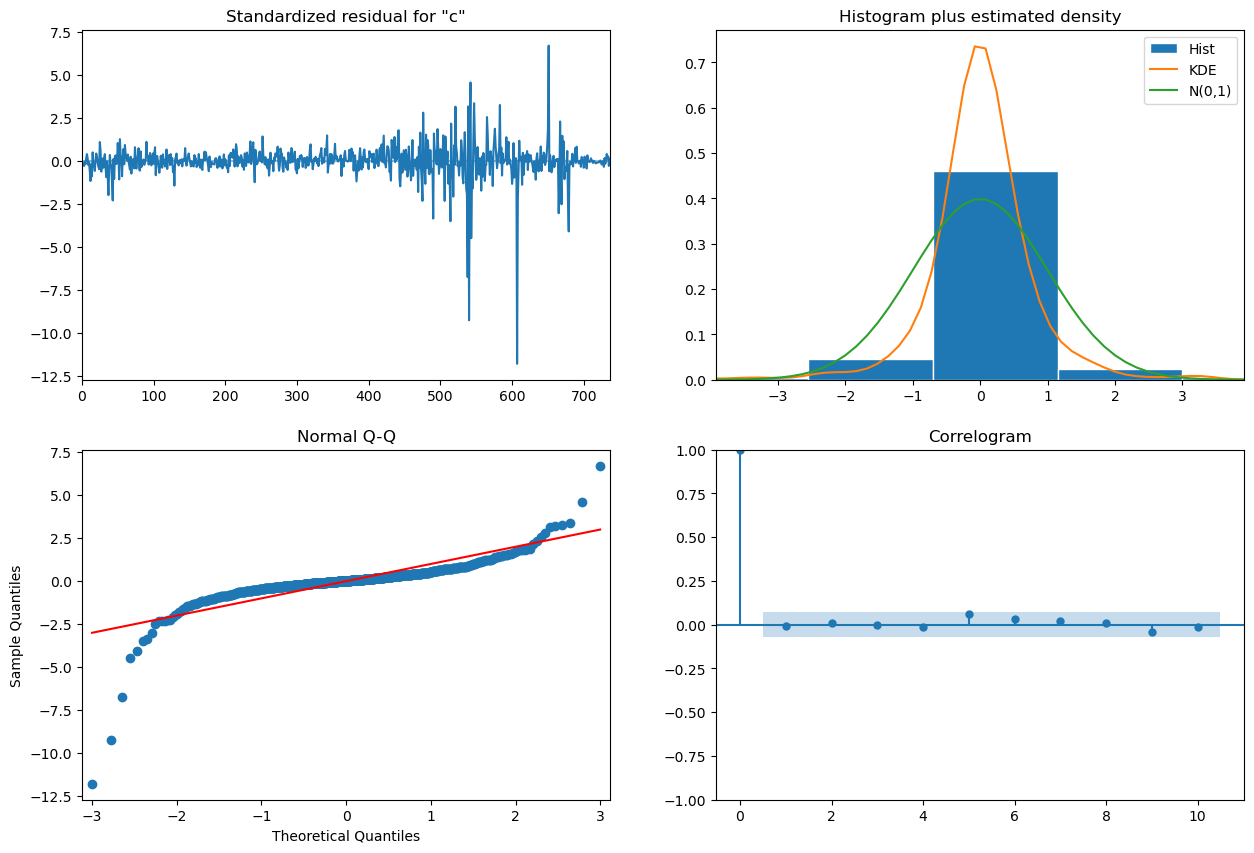

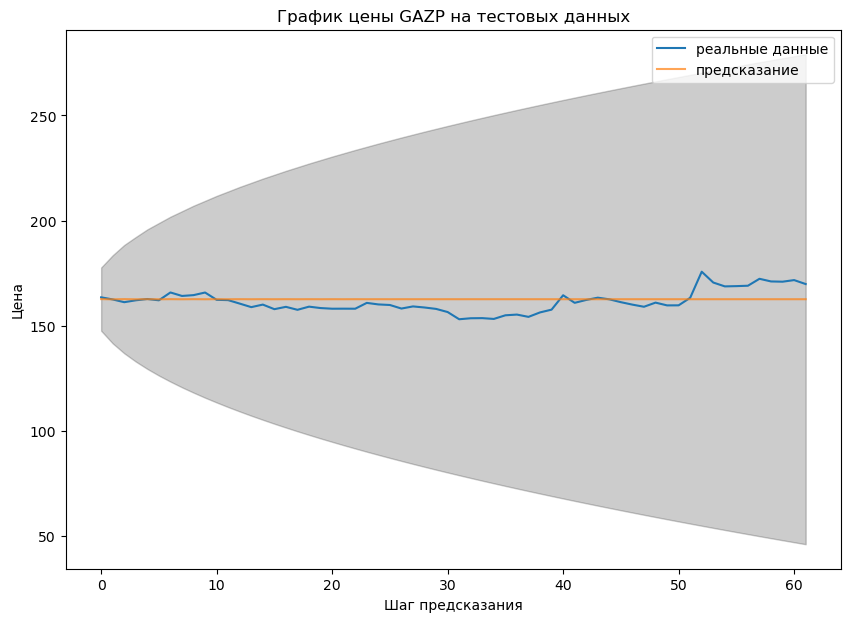

In [360]:
arima(data_gazp, data_gazp_test, 'GAZP')

## Роснефть

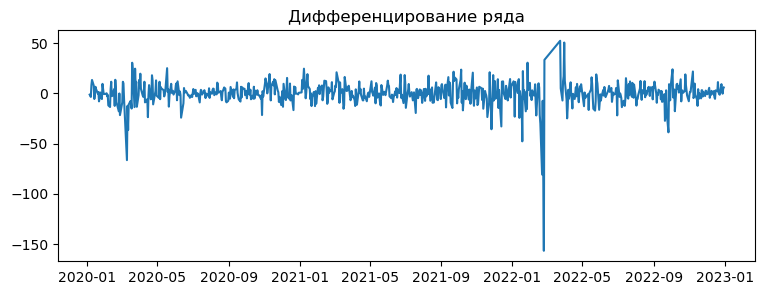

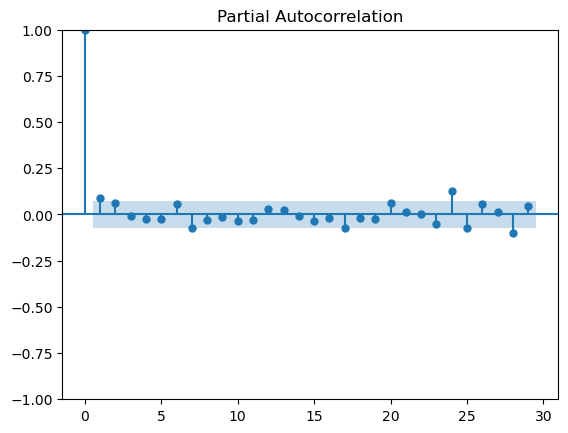

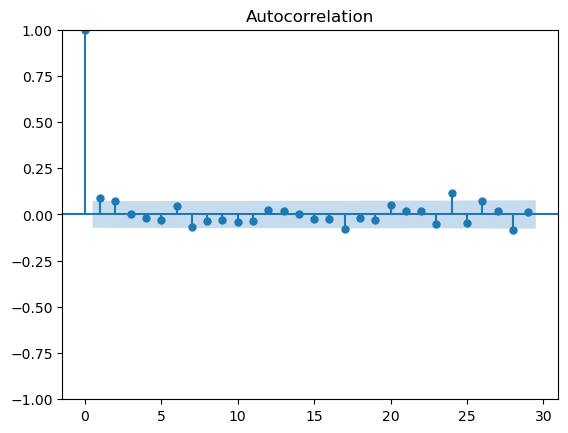

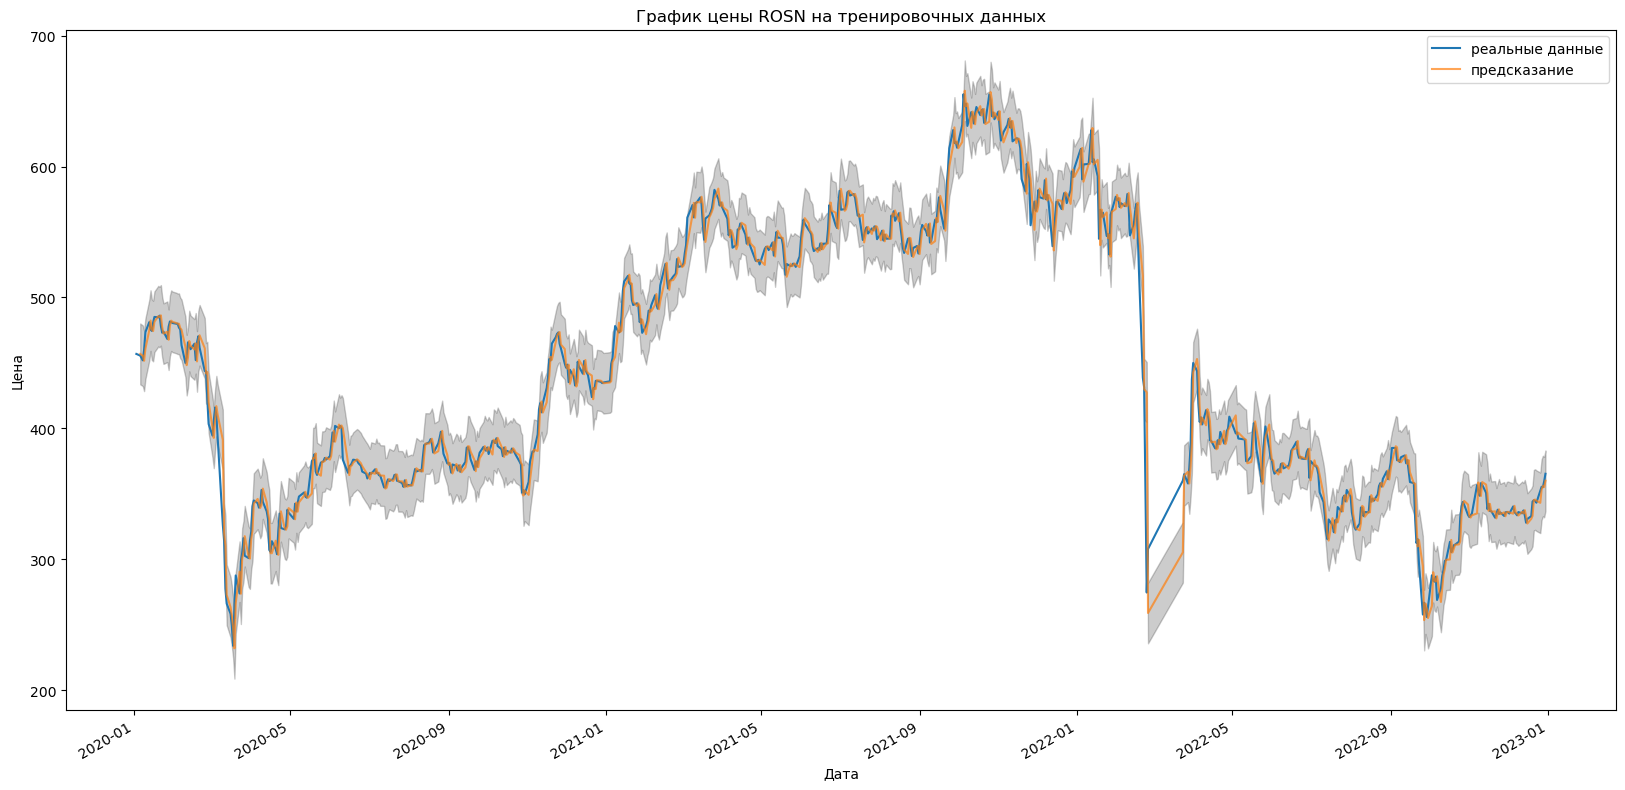

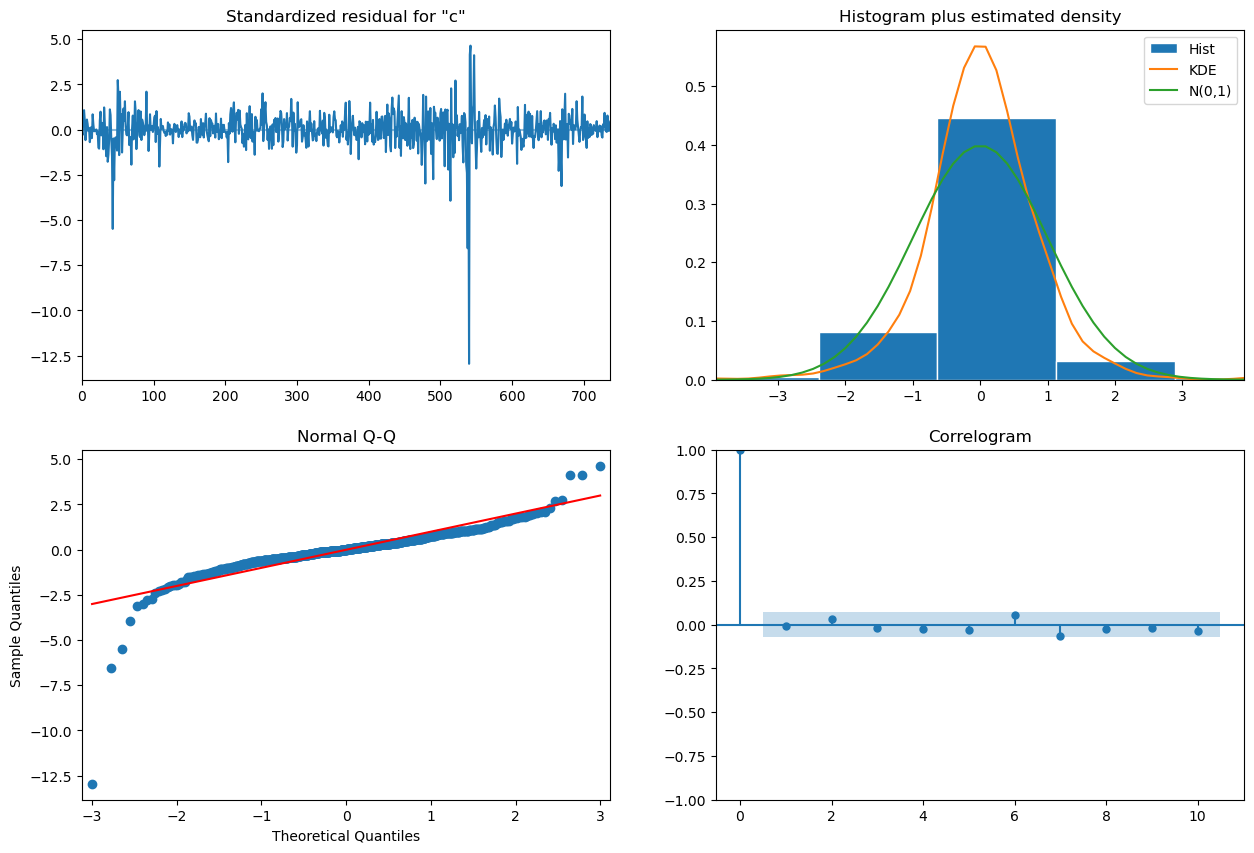

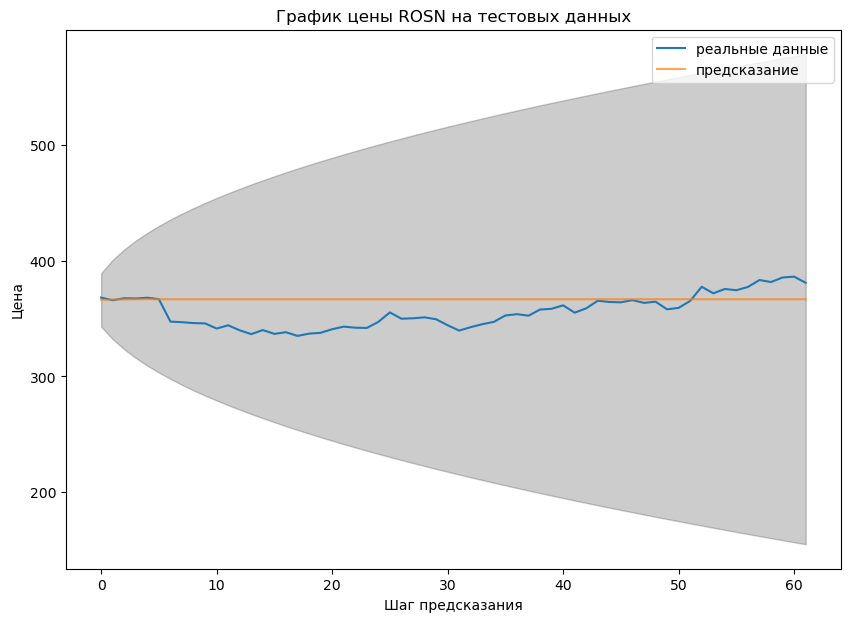

In [361]:
arima(data_rosn,data_rosn_test, 'ROSN')

## Нефть

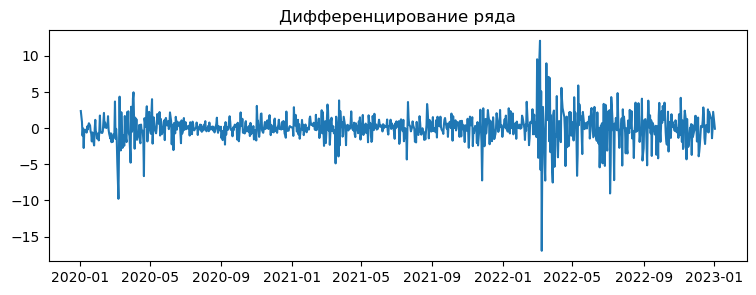

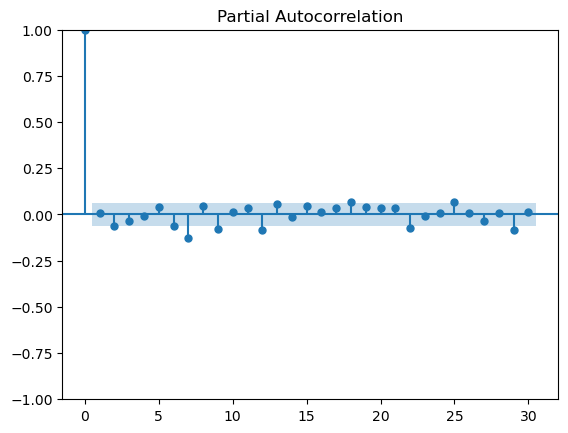

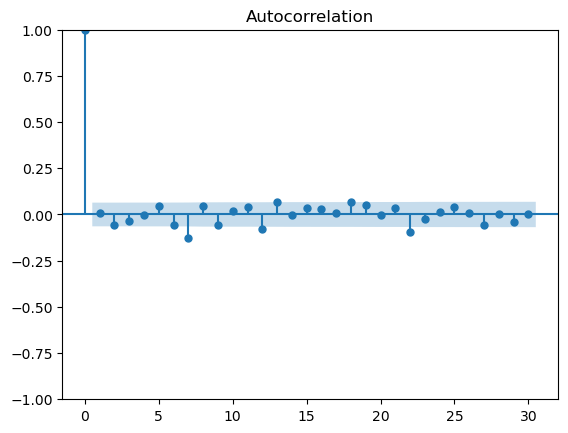

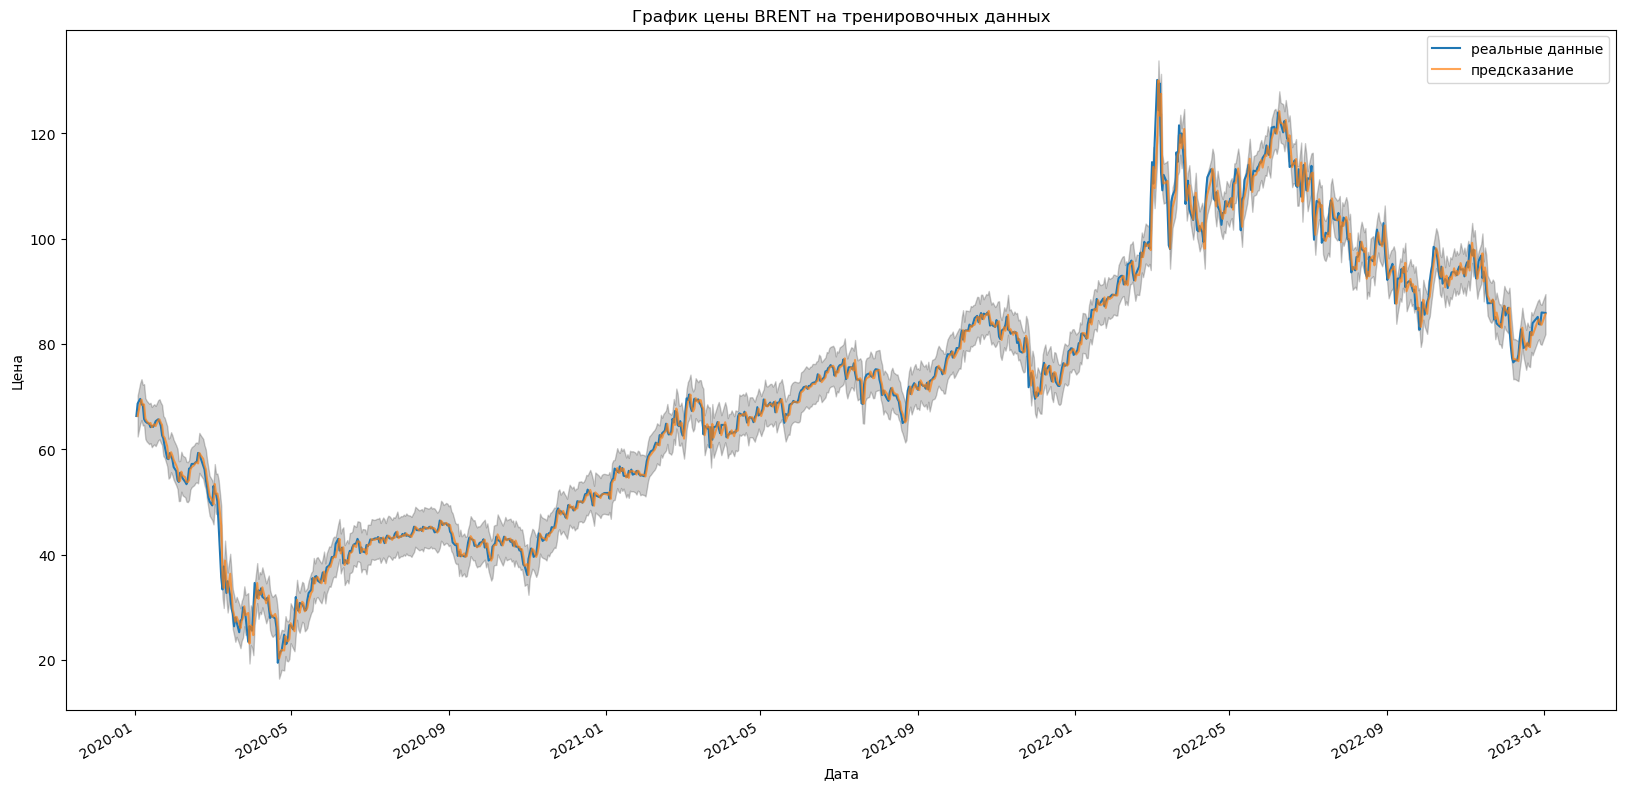

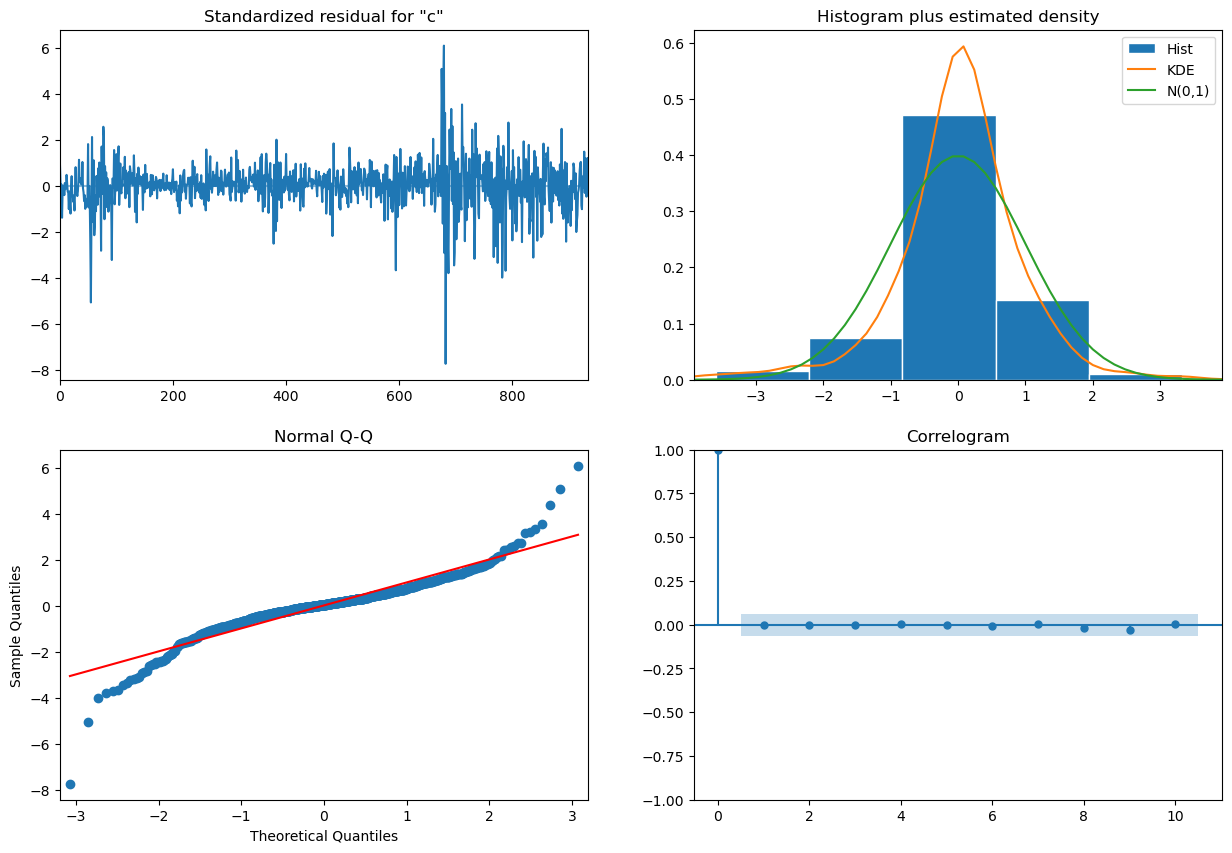

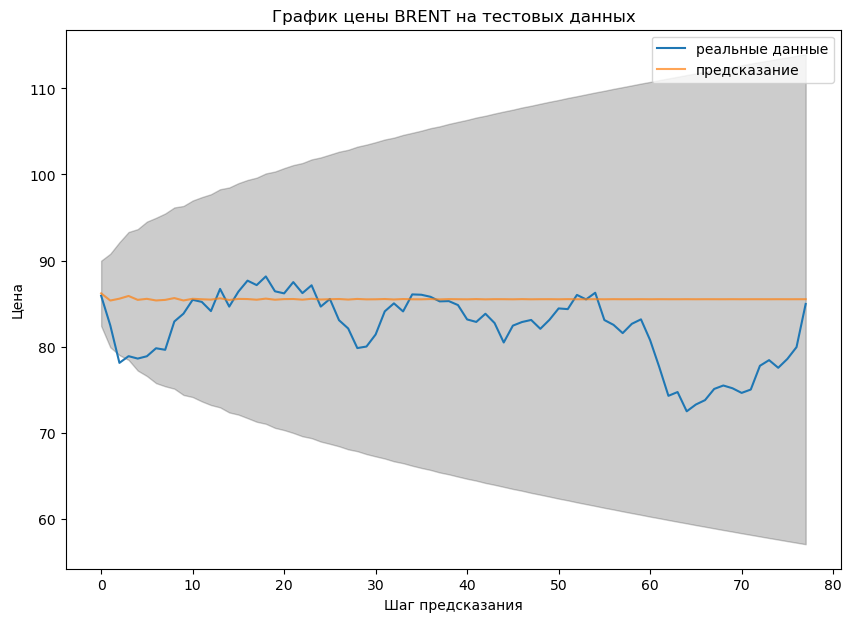

In [362]:
arima(data_brent, data_brent_test, 'BRENT')

## Природный газ

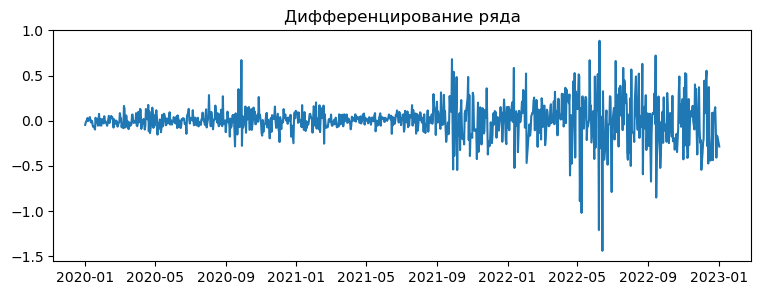

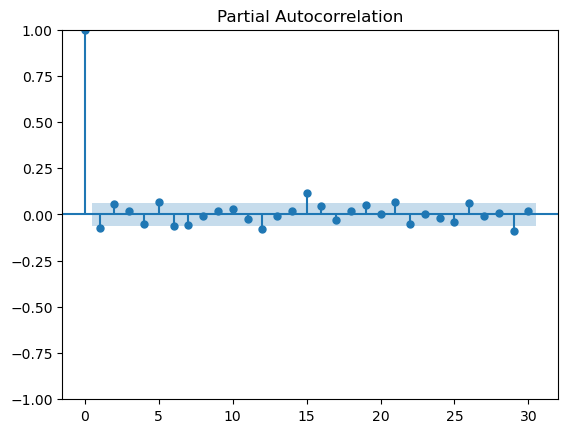

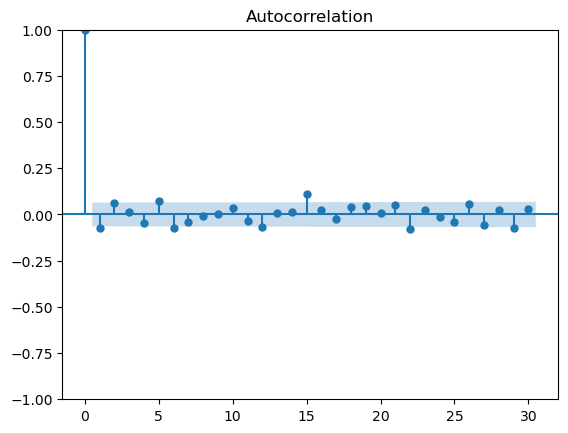

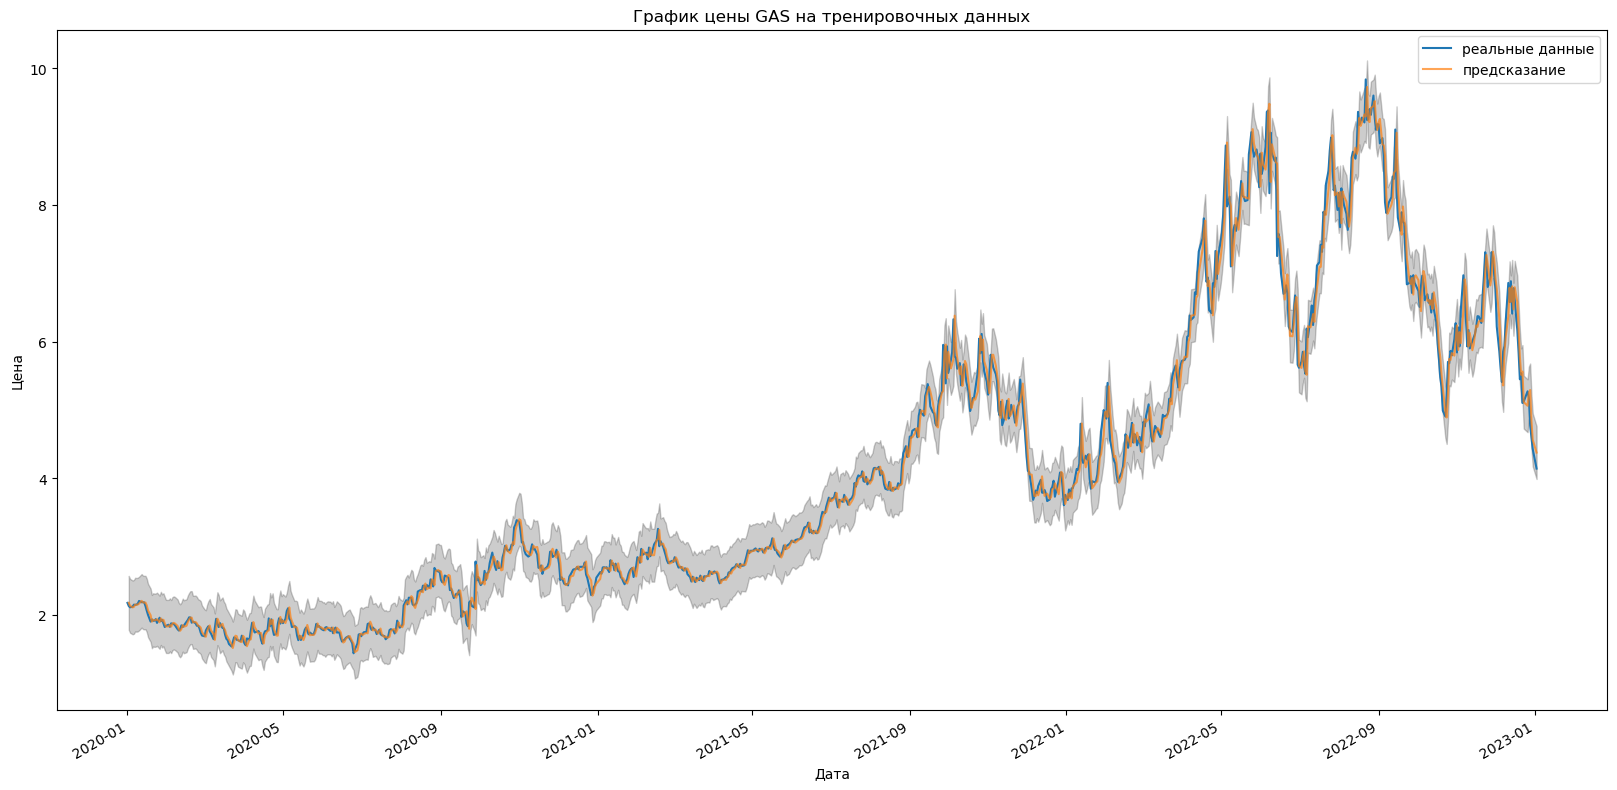

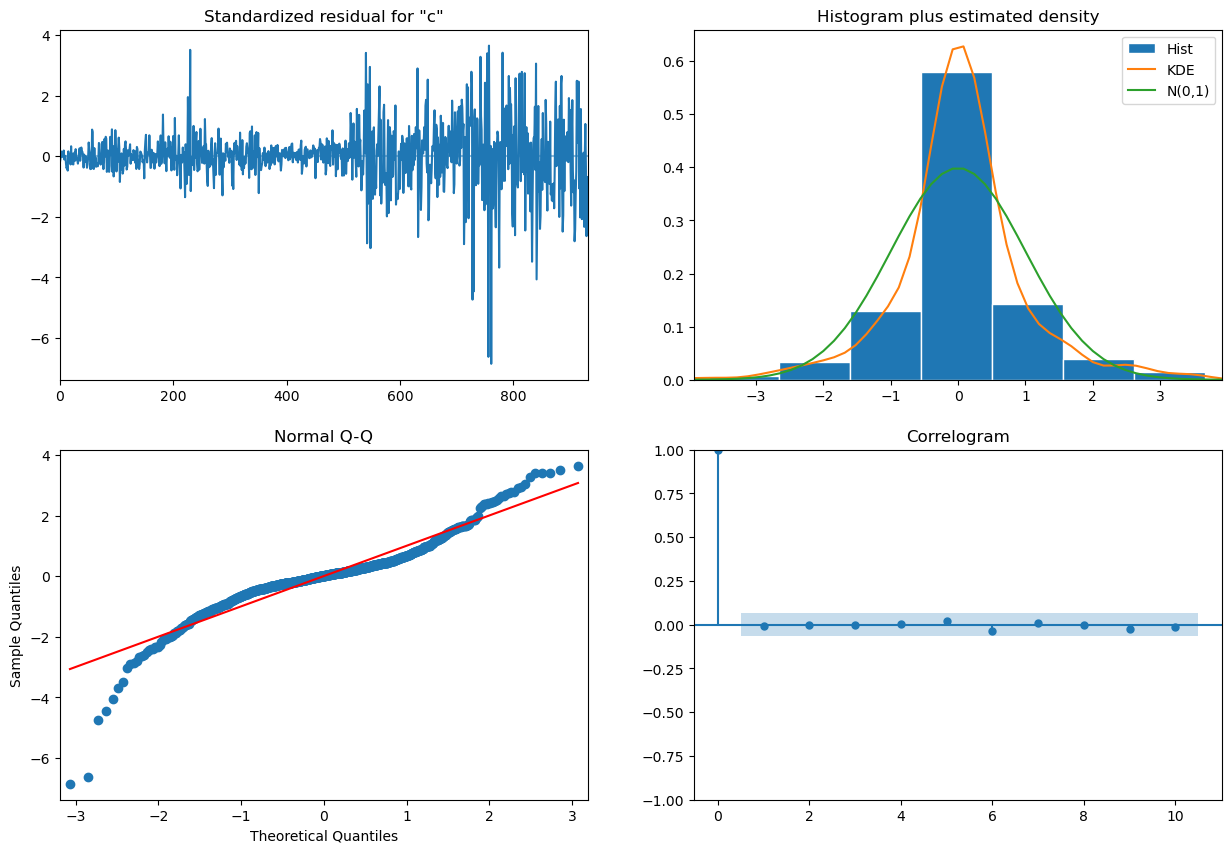

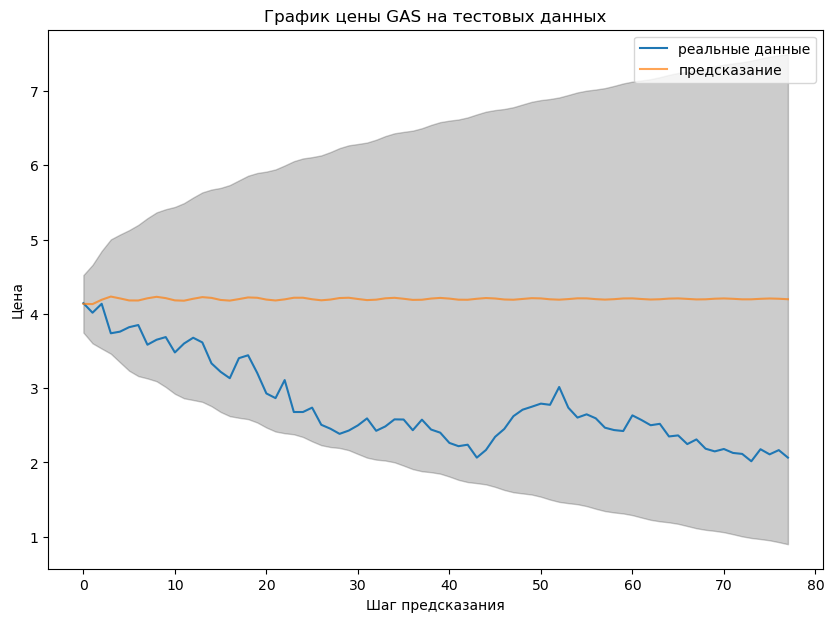

In [363]:
arima(data_gas, data_gas_test, 'GAS')

In [364]:
#ошибки прогнозирования
data_loss_arima

ticker sample        pdq      mape        mae        mpe       rmse
0   GAZP  train  (1, 1, 1)  0.017038   4.038649  -0.115729   7.672800
1   GAZP   test  (1, 1, 1)  0.026052   4.210561  -0.774058   5.216371
2   ROSN  train  (1, 1, 1)  0.017546   7.321788  -0.066569  11.803429
3   ROSN   test  (1, 1, 1)  0.042384  14.799246  -3.119715  17.600660
4  BRENT  train  (9, 1, 2)  0.019413   1.278049  -0.023693   1.935159
5  BRENT   test  (9, 1, 2)  0.048693   3.814213  -4.370254   5.221213
6    GAS  train  (6, 1, 2)  0.029401   0.128815  -0.005921   0.197784
7    GAS   test  (6, 1, 2)  0.579374   1.438385 -57.932143   1.547909

# Обучающая и тестовая выборка 

In [30]:
ws = 30

### Газпром

In [31]:
train = np.array(data_gazp.close.values)
N1 = len(train)
X_train_gazp  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_gazp = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [32]:
X_train_gazp = np.array(X_train_gazp)
y_train_gazp = np.array(y_train_gazp)

In [33]:
test = np.array(data_gazp_test.close.values)
N1 = len(test)
X_test_gazp  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_gazp = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [34]:
X_test_gazp = np.array(X_test_gazp)
y_test_gazp = np.array(y_test_gazp)

### Роснефть

In [35]:
train = np.array(data_rosn.close.values)
N1 = len(train)
X_train_rosn  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_rosn = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [36]:
X_train_rosn = np.array(X_train_rosn)
y_train_rosn = np.array(y_train_rosn)

In [37]:
test = np.array(data_rosn_test.close.values)
N1 = len(test)
X_test_rosn  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_rosn = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [38]:
X_test_rosn = np.array(X_test_rosn)
y_test_rosn = np.array(y_test_rosn)

### Нефть

In [39]:
train = np.array(data_brent.close.values)
N1 = len(train)
X_train_brent  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_brent = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [40]:
X_train_brent = np.array(X_train_brent)
y_train_brent = np.array(y_train_brent)

In [41]:
test = np.array(data_brent_test.close.values)
N1 = len(test)
X_test_brent  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_brent = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [42]:
X_test_brent = np.array(X_test_brent)
y_test_brent = np.array(y_test_brent)

### Природный газ

In [43]:
train = np.array(data_gas.close.values)
N1 = len(train)
X_train_gas  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_gas = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [44]:
X_train_gas = np.array(X_train_gas)
y_train_gas = np.array(y_train_gas)

In [45]:
test = np.array(data_gas_test.close.values)
N1 = len(test)
X_test_gas  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_gas = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [46]:
X_test_gas = np.array(X_test_gas)
y_test_gas = np.array(y_test_gas)

# Полносвязные нейронные сети

In [77]:
data_loss_dense =  pd.DataFrame(columns = ['ticker','num_1','num_2','sample','mape','mae','mpe','rmse'])

In [108]:
def model_dense(X_train, y_train, X_test, y_test, ticker, inp):
    global data_loss_dense
    
    #поиск оптимального количества нейронов на слоях
    num_1_list = [64, 128, 256]
    num_2_list = [32, 64]
    num_list = list(itertools.product(num_1_list, num_2_list))
    best_loss = np.inf
    for params in num_list:
        model = K.Sequential([
            K.layers.Dense(params[0], activation = 'relu', input_shape=(inp,)),
            K.layers.Dense(params[1], activation = 'relu'), 
            K.layers.Dense(1)
        ])

        model.compile(optimizer='adam',
                  loss='mse')
        history = model.fit(X_train, y_train, epochs=100, verbose=0)
        
        y_true = y_test
        y_pred = model.predict(X_test, verbose = 0)
        
        if mean_absolute_percentage_error(y_true, y_pred) < best_loss:
            best_loss = mean_absolute_percentage_error(y_true, y_pred)
            num_1 = params[0]
            num_2 = params[1]
            best_model = model
            best_history = history
    
    #вывод информации о лучшей модели и ее обучении     
    best_model.summary()
    plt.figure(figsize = (7,5))
    plt.plot(best_history.history['loss'])
    plt.title(f'Ошибка на тренировочной выборке {ticker}')
    plt.show()
    
    #предсказание на тренировочных данных
    y_ = best_model.predict(X_train)
    plt.figure(figsize = (15,7))
    plt.plot(y_)
    plt.plot(y_train)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тренировочные данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #предсказание на тестовых данных
    y_ = best_model.predict(X_test)
    plt.figure(figsize = (7,5))
    plt.plot(y_)
    plt.plot(y_test)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тестовые данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #расчет ошибок и заполнение таблицы
    y_true = y_train
    y_pred = best_model.predict(X_train)
    losses_1 = pd.DataFrame({'ticker':ticker,
                      'sample': 'train',
                      'num_1': num_1,
                      'num_2': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    y_true = y_test
    y_pred = best_model.predict(X_test)
    losses_2 = pd.DataFrame({'ticker':ticker,
                      'sample': 'test',
                      'num_1': num_1,
                      'num_2': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    data_loss_dense = pd.concat([data_loss_dense, losses_1, losses_2], ignore_index = True)

## Газпром

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_231 (Dense)           (None, 256)               7936      
                                                                 
 dense_232 (Dense)           (None, 64)                16448     
                                                                 
 dense_233 (Dense)           (None, 1)                 65        
                                                                 
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


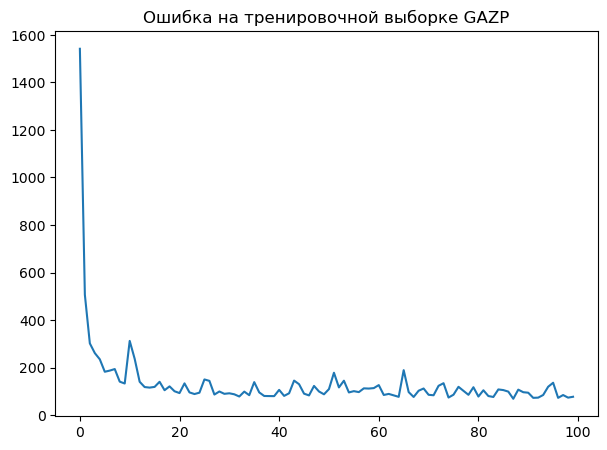

23/23 [==============================] - 0s 3ms/step


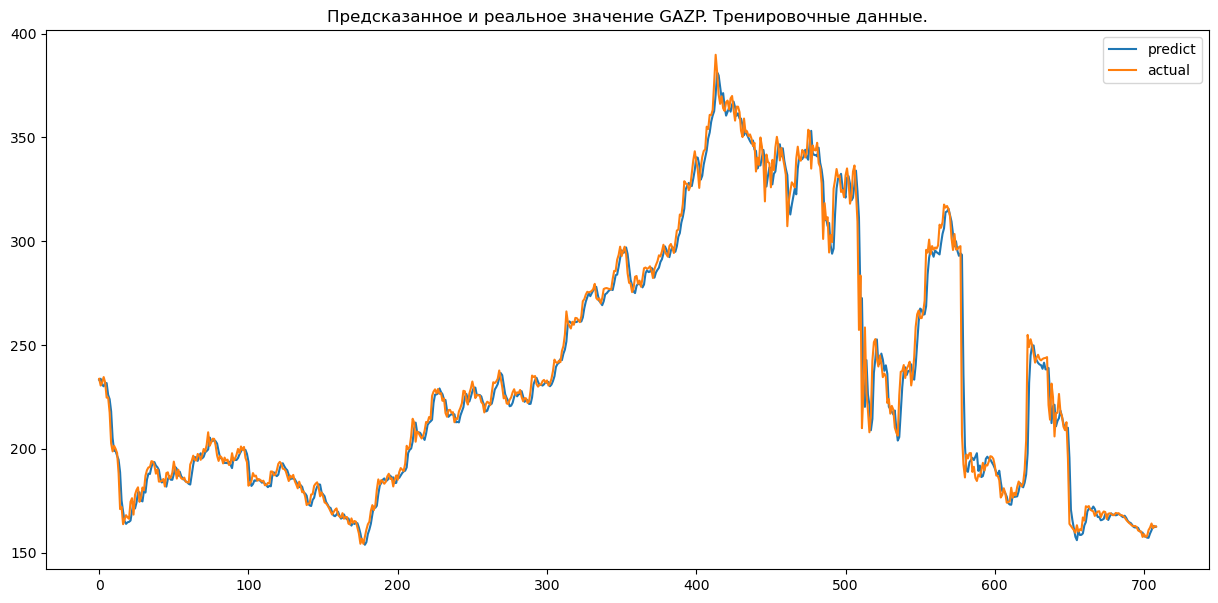

1/1 [==============================] - 0s 33ms/step


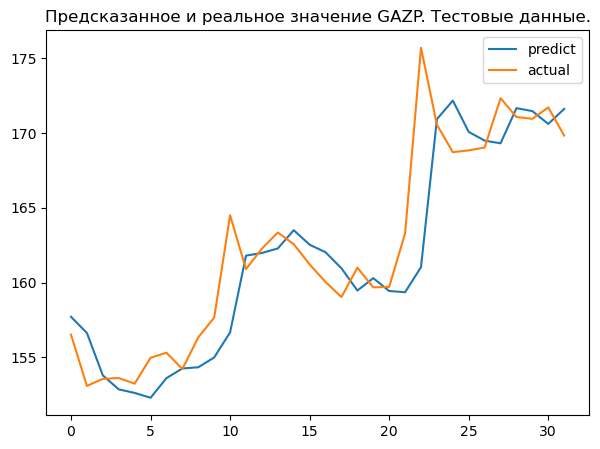

1/1 [==============================] - 0s 35ms/step


In [79]:
model_dense(X_train_gazp, y_train_gazp, X_test_gazp, y_test_gazp, 'GAZP', 30)

##  Роснефть

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_237 (Dense)           (None, 64)                1984      
                                                                 
 dense_238 (Dense)           (None, 64)                4160      
                                                                 
 dense_239 (Dense)           (None, 1)                 65        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


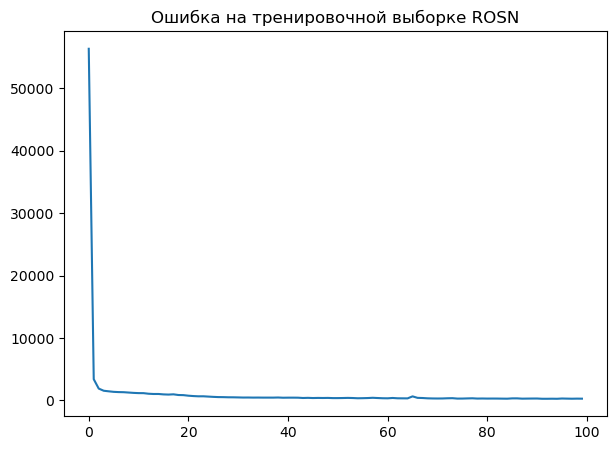

23/23 [==============================] - 0s 3ms/step


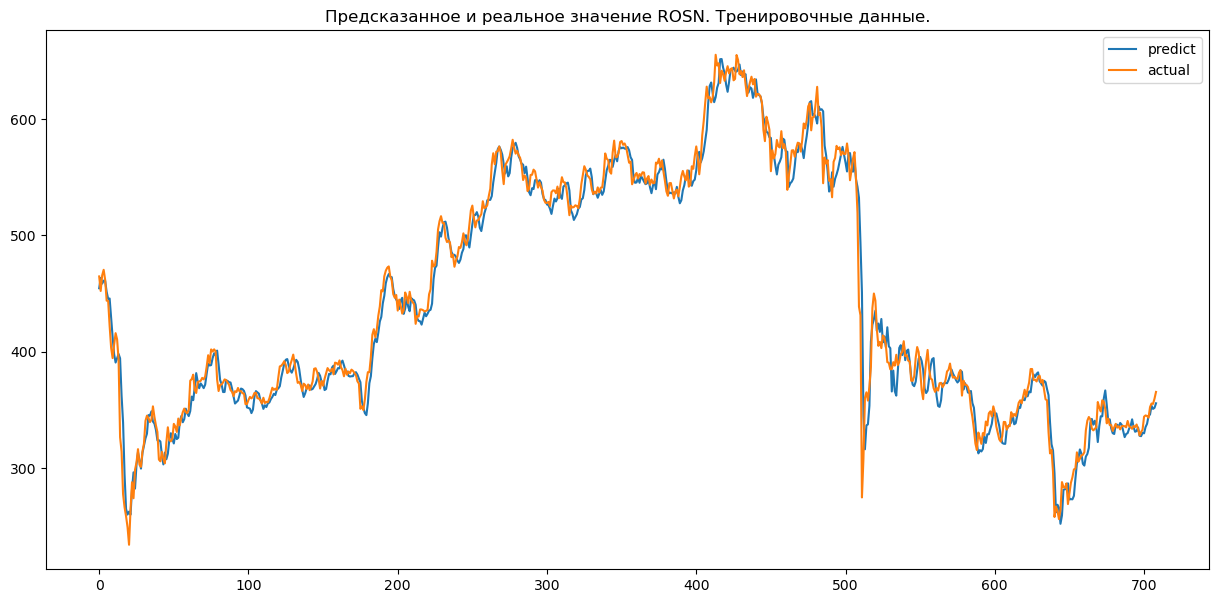

1/1 [==============================] - 0s 32ms/step


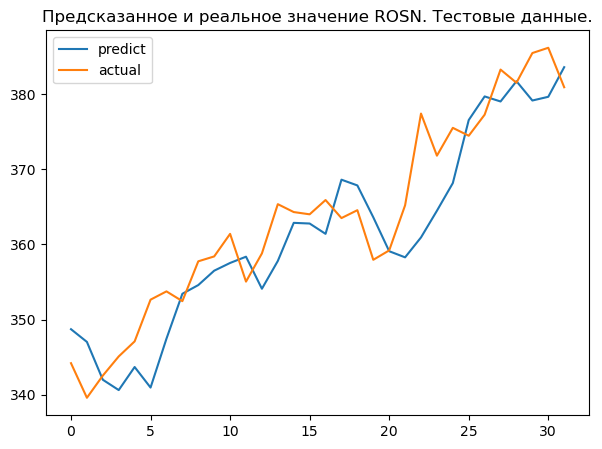

1/1 [==============================] - 0s 31ms/step


In [80]:
model_dense(X_train_rosn, y_train_rosn, X_test_rosn, y_test_rosn, 'ROSN', 30)

## Нефть

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_267 (Dense)           (None, 256)               7936      
                                                                 
 dense_268 (Dense)           (None, 64)                16448     
                                                                 
 dense_269 (Dense)           (None, 1)                 65        
                                                                 
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


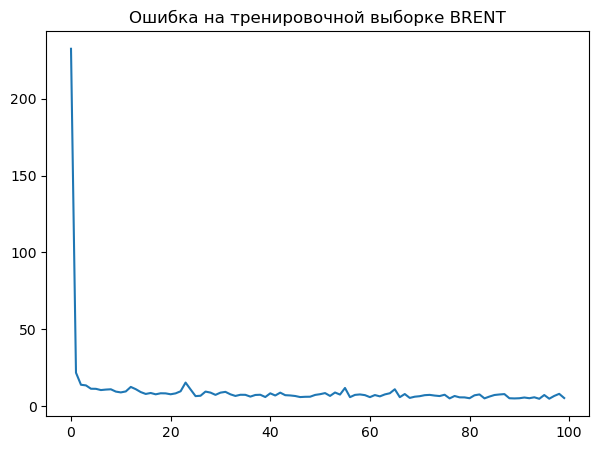

29/29 [==============================] - 0s 3ms/step


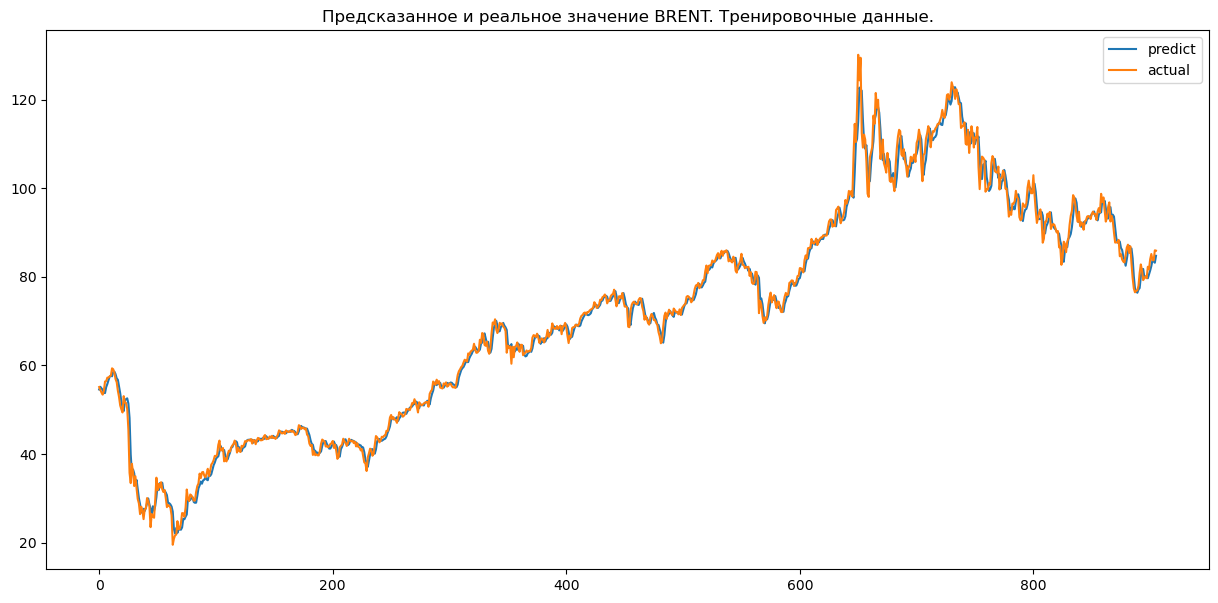

2/2 [==============================] - 0s 6ms/step


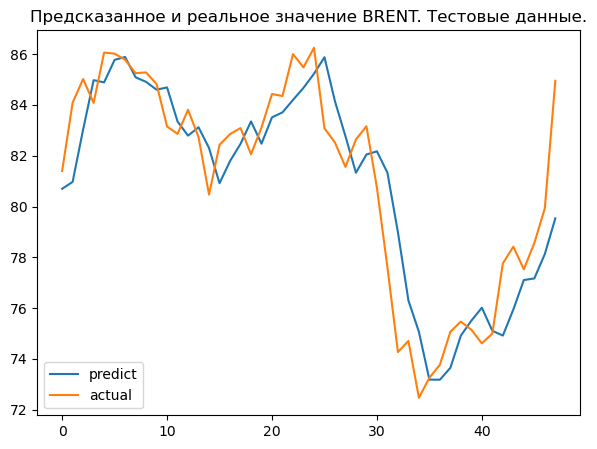

2/2 [==============================] - 0s 5ms/step


In [81]:
model_dense(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

## Природный газ

Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_279 (Dense)           (None, 128)               3968      
                                                                 
 dense_280 (Dense)           (None, 64)                8256      
                                                                 
 dense_281 (Dense)           (None, 1)                 65        
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


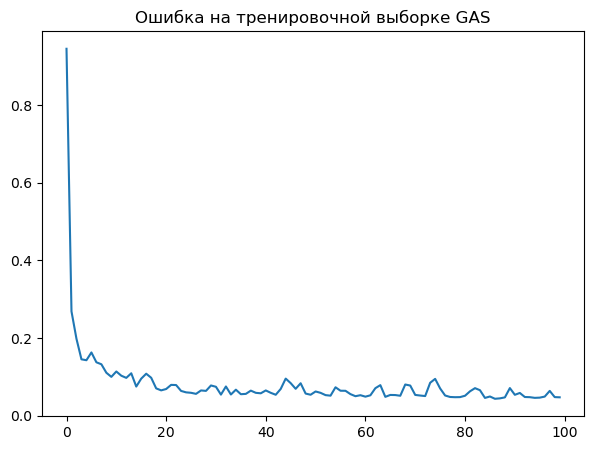

29/29 [==============================] - 0s 3ms/step


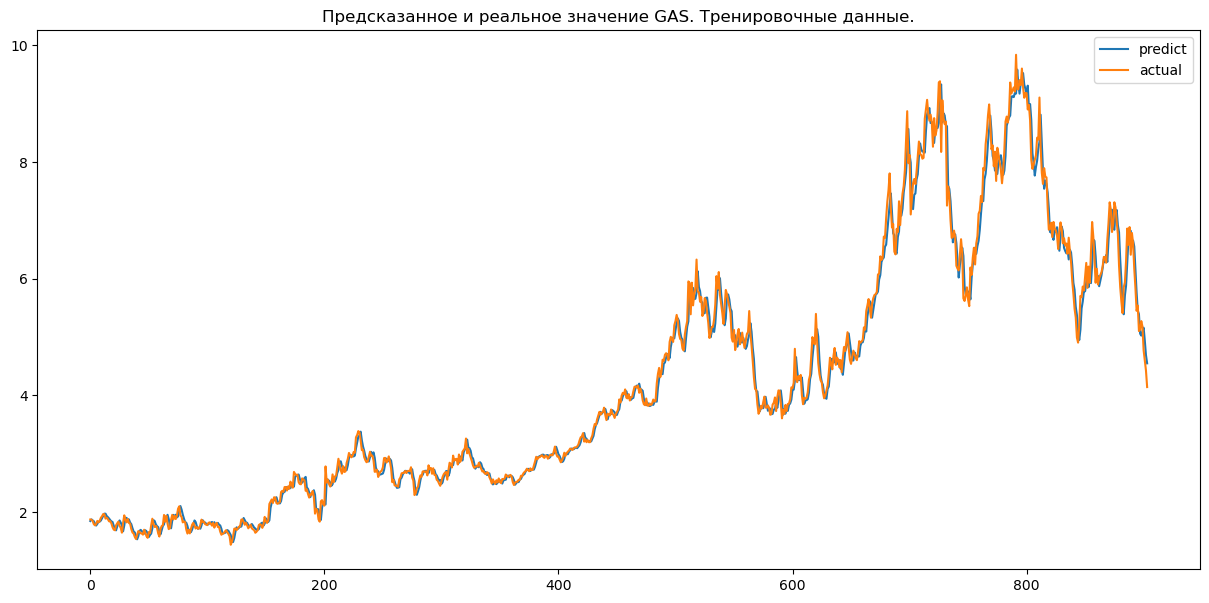

2/2 [==============================] - 0s 5ms/step


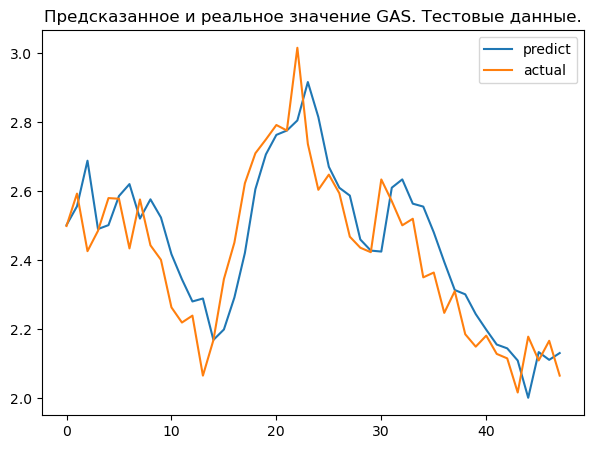

2/2 [==============================] - 0s 5ms/step


In [82]:
model_dense(X_train_gas, y_train_gas, X_test_gas, y_test_gas, 'GAS', 30)

In [83]:
#ошибки прогнозирования
data_loss_dense

ticker num_1 num_2 sample      mape       mae       mpe       rmse
0   GAZP   256    64  train  0.019211  4.551904  0.310348   8.090827
1   GAZP   256    64   test  0.012366  2.038869  0.423480   3.405406
2   ROSN    64    64  train  0.023908  9.917813  0.367616  15.079392
3   ROSN    64    64   test  0.012676  4.615788  0.607753   5.703610
4  BRENT   256    64  train  0.020862  1.378879  0.092995   2.056359
5  BRENT   256    64   test  0.016977  1.365567  0.201338   1.779018
6    GAS   128    64  train  0.030575  0.133776  0.116063   0.200426
7    GAS   128    64   test  0.038990  0.093870 -1.435239   0.119999

# Рекуррентные нейронные сети. RNN

In [54]:
data_loss_rnn =  pd.DataFrame(columns = ['ticker','num_rnn','num_dense','sample','mape','mae','mpe','rmse'])

In [107]:
def model_rnn(X_train, y_train, X_test, y_test, ticker, inp):
    global data_loss_rnn
    #поиск оптимального количества нейронов на слоях
    num_1_list = [64, 128, 256]
    num_2_list = [128, 256]
    num_list = list(itertools.product(num_1_list, num_2_list))
    best_loss = np.inf
    for params in num_list:
        model = K.Sequential([
            K.layers.InputLayer((inp, 1)),
            K.layers.SimpleRNN(params[0]),
            K.layers.Dense(params[1], activation = 'relu'), 
            K.layers.Dense(1)
        ])

        model.compile(optimizer='adam',
                  loss='mse')
        history = model.fit(X_train, y_train, epochs=100, verbose=0)
        
        y_true = y_test
        y_pred = model.predict(X_test, verbose = 0)
        
        if mean_absolute_percentage_error(y_true, y_pred) < best_loss:
            best_loss = mean_absolute_percentage_error(y_true, y_pred)
            num_1 = params[0]
            num_2 = params[1]
            best_model = model
            best_history = history
    
    #вывод информации о лучшей модели и ее обучении
    best_model.summary()
    plt.figure(figsize = (7,5))
    plt.plot(best_history.history['loss'])
    plt.title(f'Ошибка на тренировочной выборке {ticker}')
    plt.show()
    
    #предсказание на тренировочных данных
    y_ = best_model.predict(X_train)
    plt.figure(figsize = (15,7))
    plt.plot(y_)
    plt.plot(y_train)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тренировочные данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #предсказание на тестовых данных
    y_ = best_model.predict(X_test)
    plt.figure(figsize = (7,5))
    plt.plot(y_)
    plt.plot(y_test)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тестовые данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #расчет ошибок и заполнение таблицы
    y_true = y_train
    y_pred = best_model.predict(X_train)
    losses_1 = pd.DataFrame({'ticker':ticker,
                      'sample': 'train',
                      'num_rnn': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    y_true = y_test
    y_pred = best_model.predict(X_test)
    losses_2 = pd.DataFrame({'ticker':ticker,
                      'sample': 'test',
                      'num_rnn': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    data_loss_rnn = pd.concat([data_loss_rnn, losses_1, losses_2], ignore_index = True)

## Газпром

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 128)               16640     
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dense_77 (Dense)            (None, 1)                 129       
                                                                 
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
_________________________________________________________________


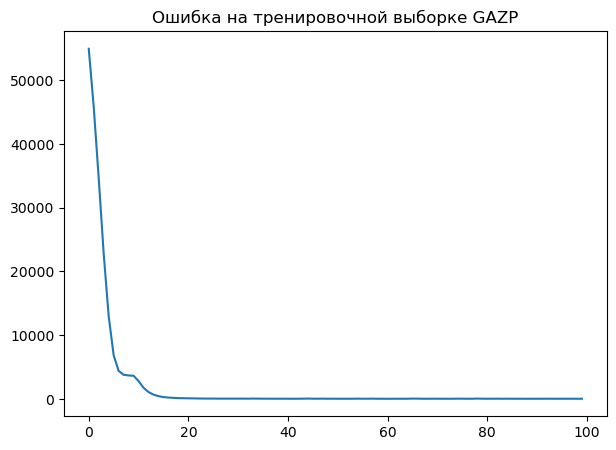

23/23 [==============================] - 0s 4ms/step


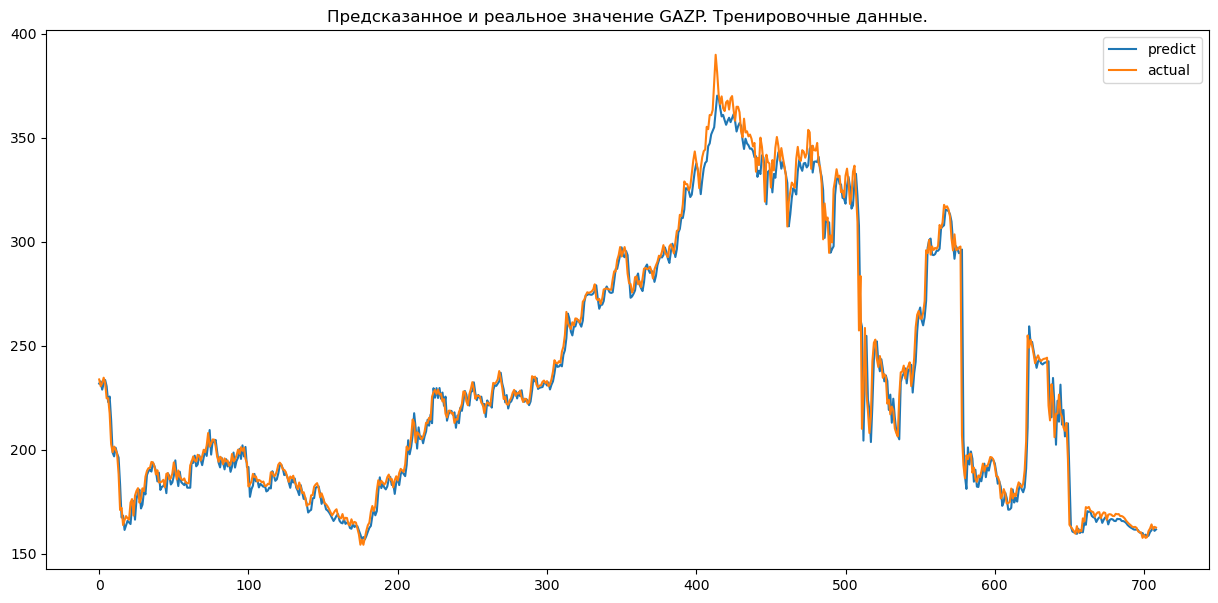

1/1 [==============================] - 0s 28ms/step


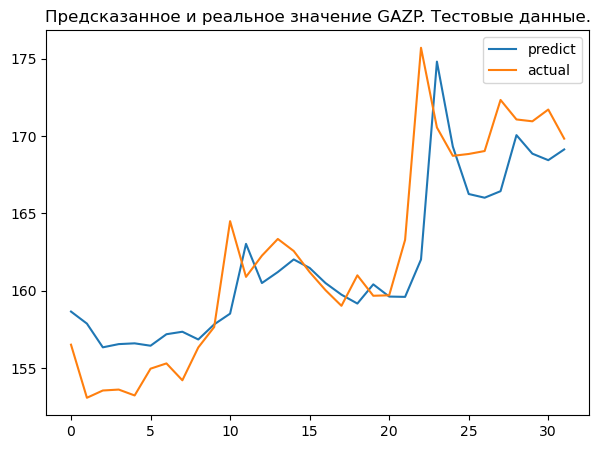

1/1 [==============================] - 0s 23ms/step


In [56]:
model_rnn(X_train_gazp, y_train_gazp, X_test_gazp, y_test_gazp, 'GAZP', 30)

##  Роснефть

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_86 (Dense)            (None, 256)               16640     
                                                                 
 dense_87 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


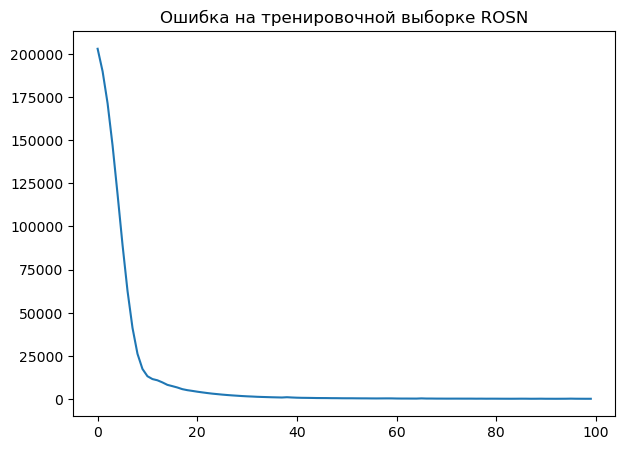

23/23 [==============================] - 0s 3ms/step


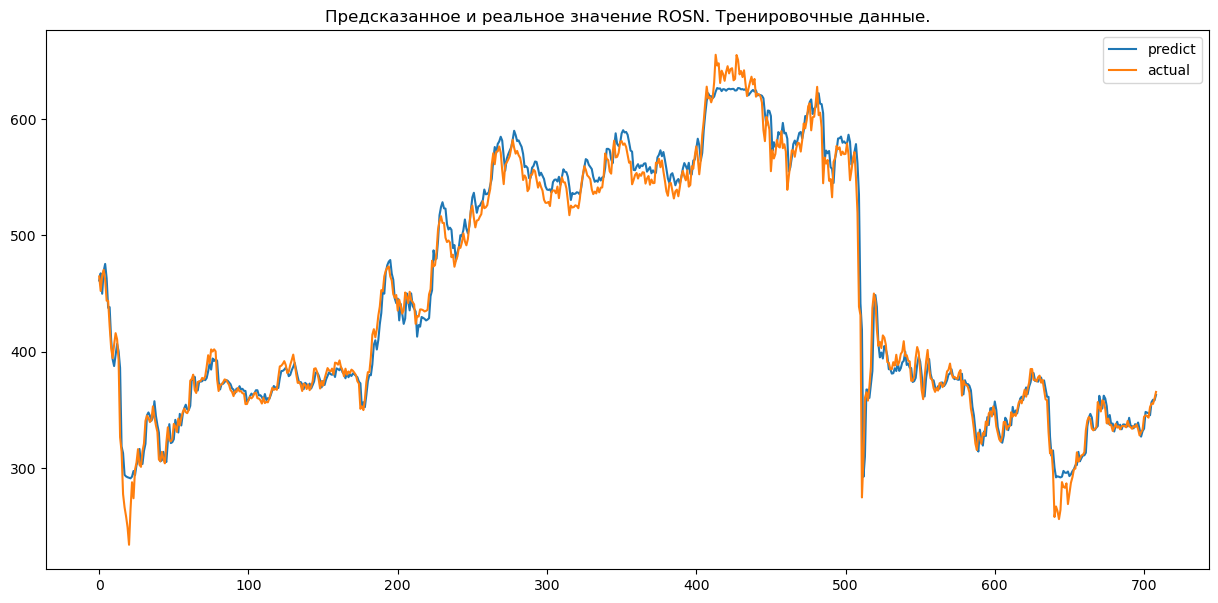

1/1 [==============================] - 0s 22ms/step


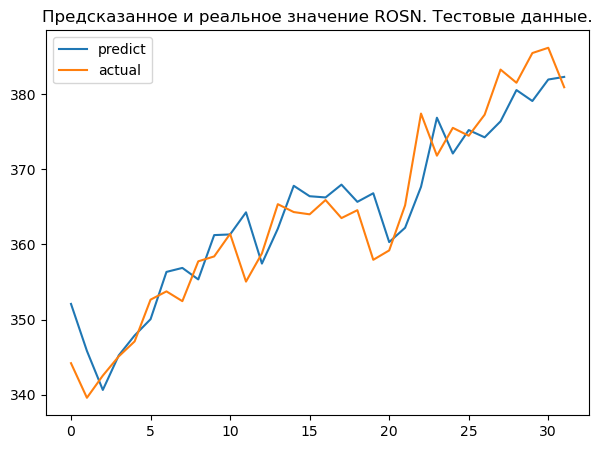

1/1 [==============================] - 0s 21ms/step


In [57]:
model_rnn(X_train_rosn, y_train_rosn, X_test_rosn, y_test_rosn, 'ROSN', 30)

## Нефть

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_102 (Dense)           (None, 256)               33024     
                                                                 
 dense_103 (Dense)           (None, 1)                 257       
                                                                 
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________


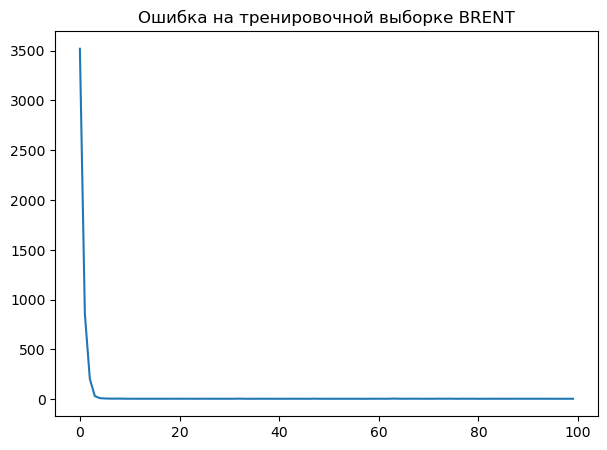

29/29 [==============================] - 0s 4ms/step


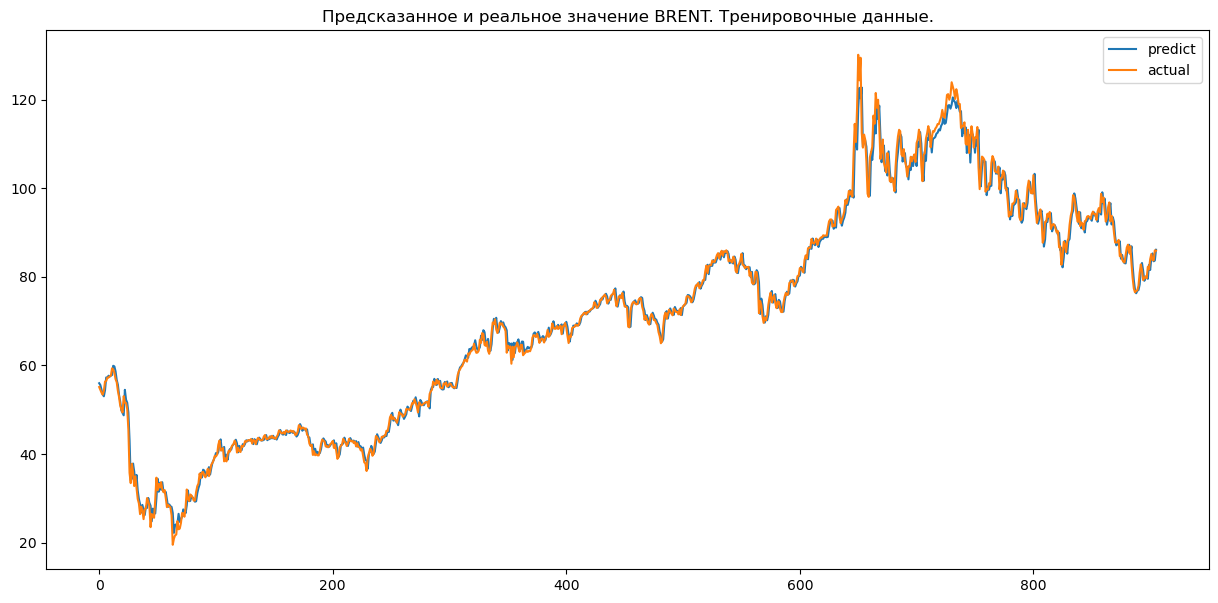

2/2 [==============================] - 0s 4ms/step


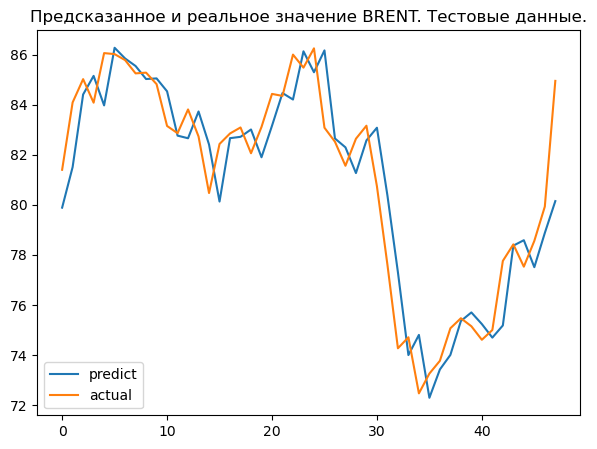

2/2 [==============================] - 0s 4ms/step


In [58]:
model_rnn(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

## Природный газ

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_108 (Dense)           (None, 128)               8320      
                                                                 
 dense_109 (Dense)           (None, 1)                 129       
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


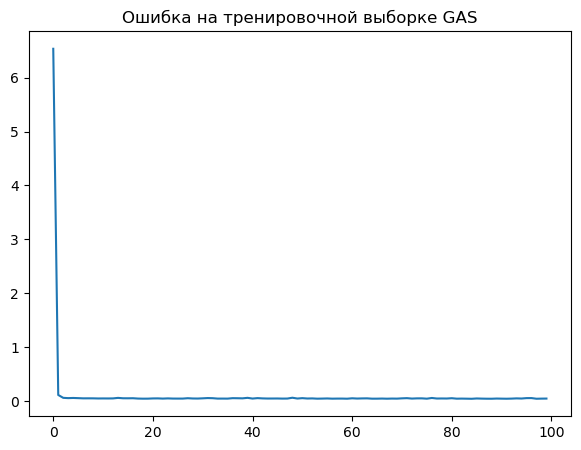

29/29 [==============================] - 0s 3ms/step


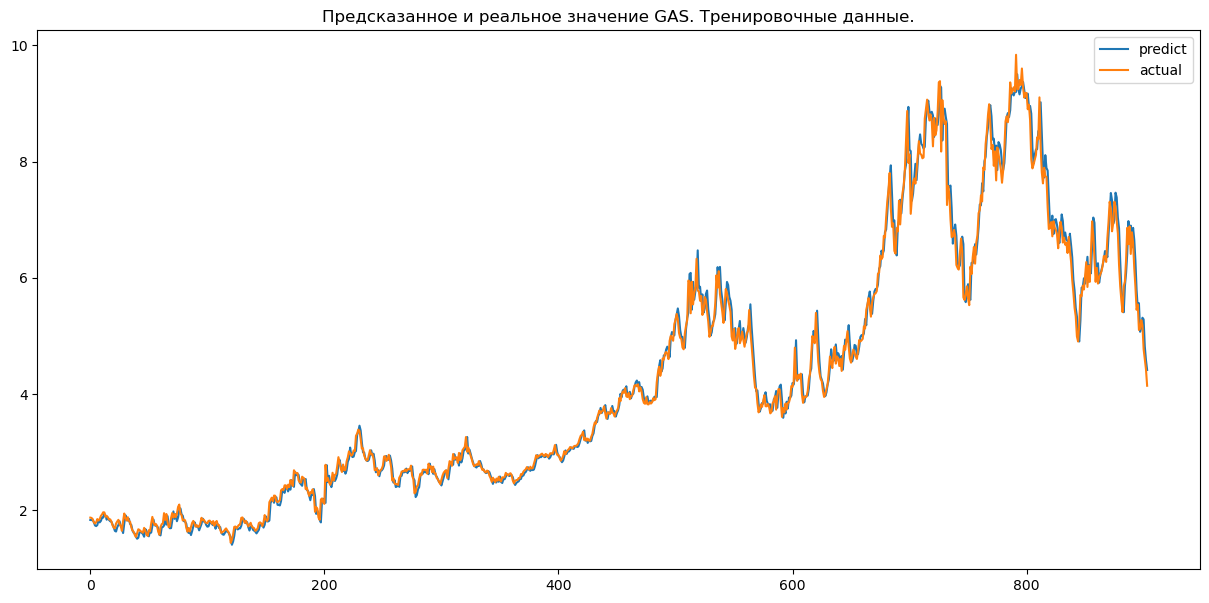

2/2 [==============================] - 0s 3ms/step


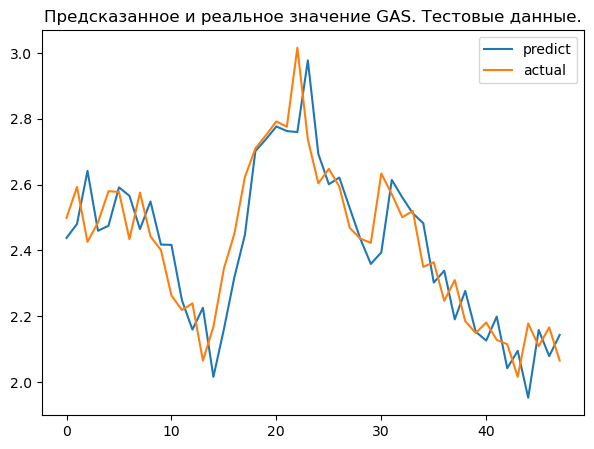

2/2 [==============================] - 0s 3ms/step


In [59]:
model_rnn(X_train_gas, y_train_gas, X_test_gas, y_test_gas, 'GAS', 30)

In [60]:
#ошибки прогнозирования
data_loss_rnn

ticker num_rnn num_dense sample      mape       mae       mpe       rmse
0   GAZP     128       128  train  0.019671  4.683039  0.693999   7.778674
1   GAZP     128       128   test  0.015331  2.519906  0.245252   3.580461
2   ROSN      64       256  train  0.021858  9.233247 -0.729696  13.906096
3   ROSN      64       256   test  0.009649  3.508567 -0.142108   4.429053
4  BRENT     128       256  train  0.019764  1.311470 -0.125782   1.947864
5  BRENT     128       256   test  0.014444  1.166696  0.149472   1.539609
6    GAS      64       128  train  0.030673  0.133929  0.023157   0.205537
7    GAS      64       128   test  0.037922  0.091068  0.329900   0.113978

# Рекуррентные нейронные сети. LSTM

In [86]:
data_loss_lstm =  pd.DataFrame(columns = ['ticker','num_lstm','num_dense','sample','mape','mae','mpe','rmse'])

In [106]:
def model_lstm(X_train, y_train, X_test, y_test, ticker, inp):
    global data_loss_lstm
    #поиск оптимального количества нейронов на слоях
    num_1_list = [64, 128, 256]
    num_2_list = [128, 256]
    num_list = list(itertools.product(num_1_list, num_2_list))
    best_loss = np.inf
    for params in num_list:
        model = K.Sequential([
            K.layers.InputLayer((inp, 1)),
            K.layers.LSTM(params[0]),
            K.layers.Dense(params[1], activation = 'relu'), 
            K.layers.Dense(1)
        ])

        model.compile(optimizer='adam',
                  loss='mse')
        history = model.fit(X_train, y_train, epochs=100, verbose=0)
        
        y_true = y_test
        y_pred = model.predict(X_test, verbose = 0)
        
        if mean_absolute_percentage_error(y_true, y_pred) < best_loss:
            best_loss = mean_absolute_percentage_error(y_true, y_pred)
            num_1 = params[0]
            num_2 = params[1]
            best_model = model
            best_history = history
    
    #вывод информации о лучшей модели и ее обучении  
    best_model.summary()
    plt.figure(figsize = (7,5))
    plt.plot(best_history.history['loss'])
    plt.title(f'Ошибка на тренировочной выборке {ticker}')
    plt.show()
    
    #предсказание на тренировочных данных
    y_ = best_model.predict(X_train)
    plt.figure(figsize = (15,7))
    plt.plot(y_)
    plt.plot(y_train)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тренировочные данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #предсказание на тестовых данных
    y_ = best_model.predict(X_test)
    plt.figure(figsize = (7,5))
    plt.plot(y_)
    plt.plot(y_test)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тестовые данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #расчет ошибок и заполнение таблицы
    y_true = y_train
    y_pred = best_model.predict(X_train)
    losses_1 = pd.DataFrame({'ticker':ticker,
                      'sample': 'train',
                      'num_lstm': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    y_true = y_test
    y_pred = best_model.predict(X_test)
    losses_2 = pd.DataFrame({'ticker':ticker,
                      'sample': 'test',
                      'num_lstm': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    data_loss_lstm = pd.concat([data_loss_lstm, losses_1, losses_2], ignore_index = True)

## Газпром

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 256)               264192    
                                                                 
 dense_298 (Dense)           (None, 256)               65792     
                                                                 
 dense_299 (Dense)           (None, 1)                 257       
                                                                 
Total params: 330,241
Trainable params: 330,241
Non-trainable params: 0
_________________________________________________________________


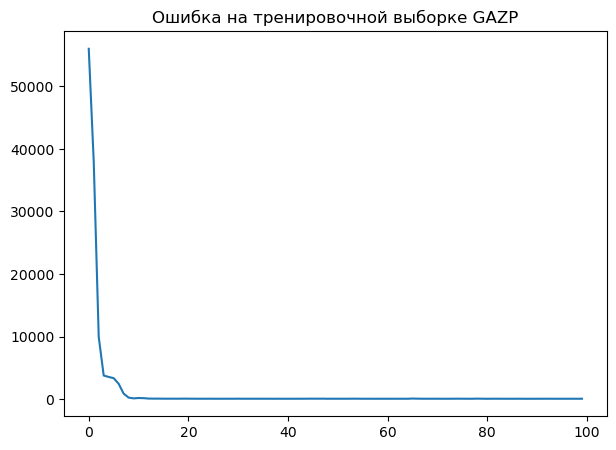

23/23 [==============================] - 2s 47ms/step


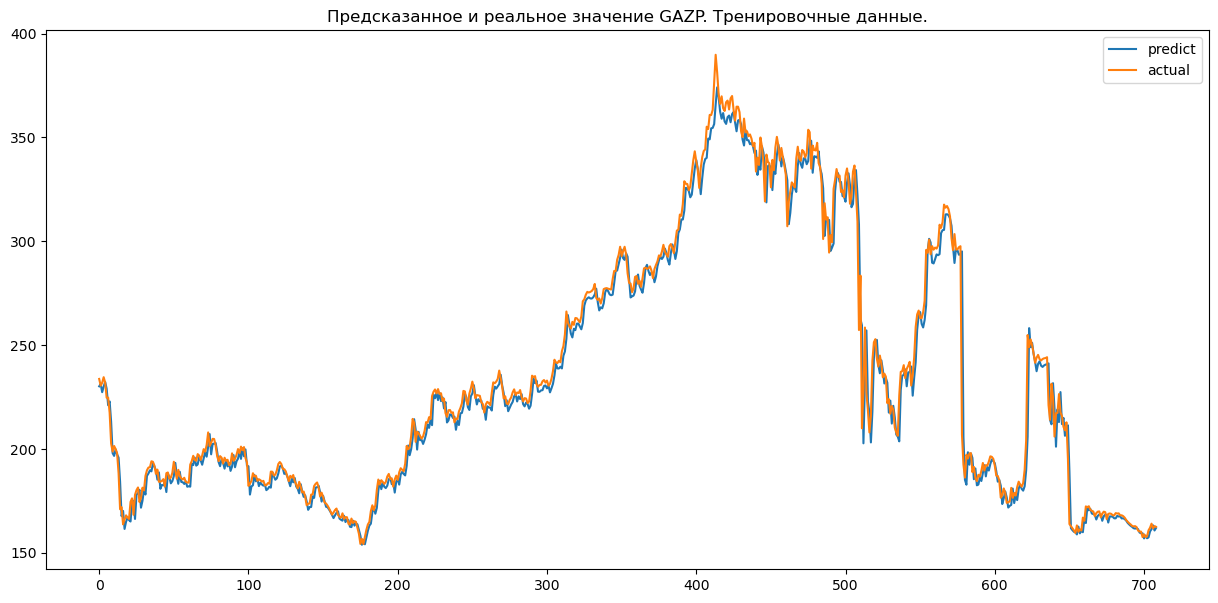

1/1 [==============================] - 0s 111ms/step


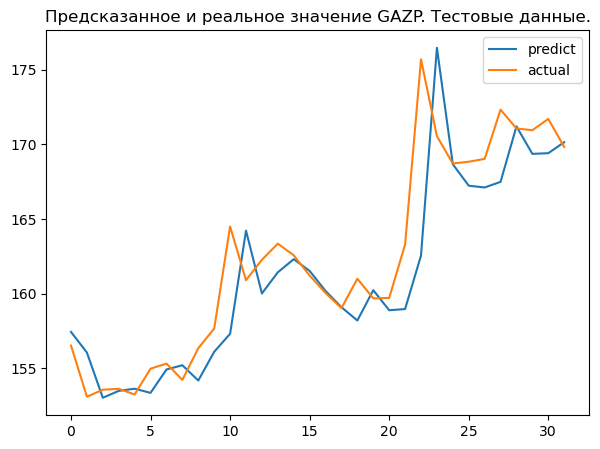

1/1 [==============================] - 0s 71ms/step


In [88]:
model_lstm(X_train_gazp, y_train_gazp, X_test_gazp, y_test_gazp, 'GAZP', 30)

##  Роснефть

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 64)                16896     
                                                                 
 dense_302 (Dense)           (None, 256)               16640     
                                                                 
 dense_303 (Dense)           (None, 1)                 257       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


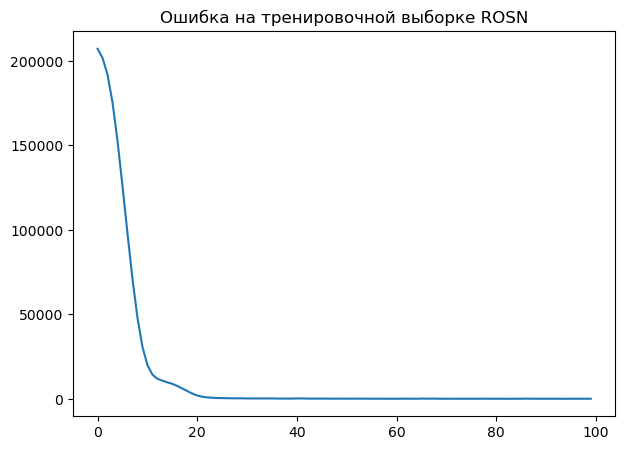

23/23 [==============================] - 1s 11ms/step


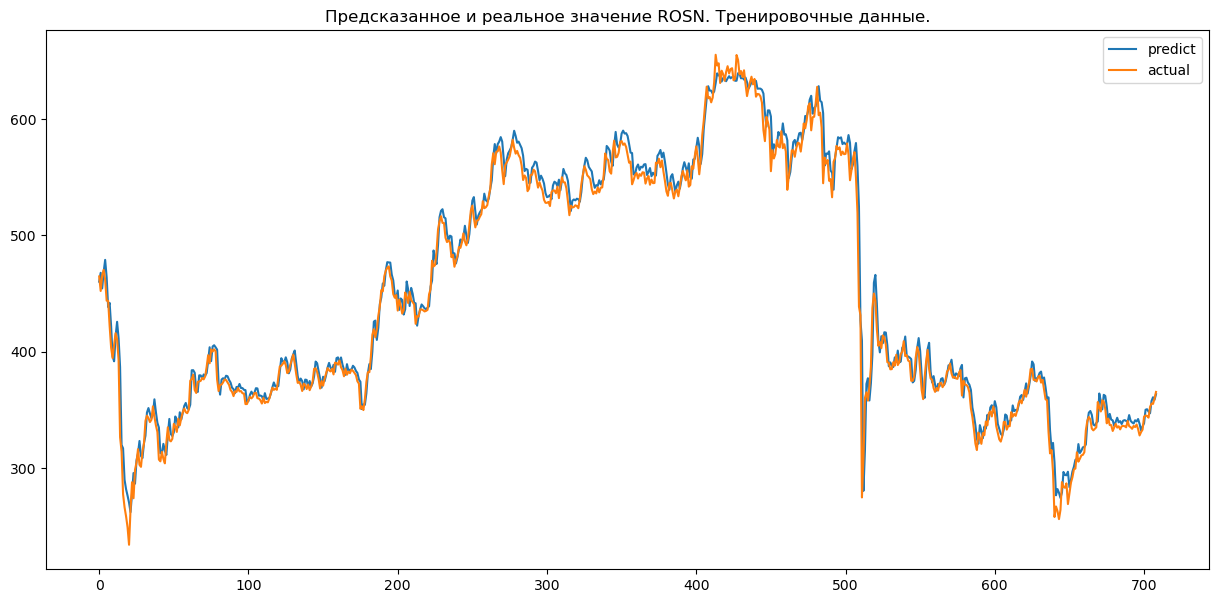

1/1 [==============================] - 0s 46ms/step


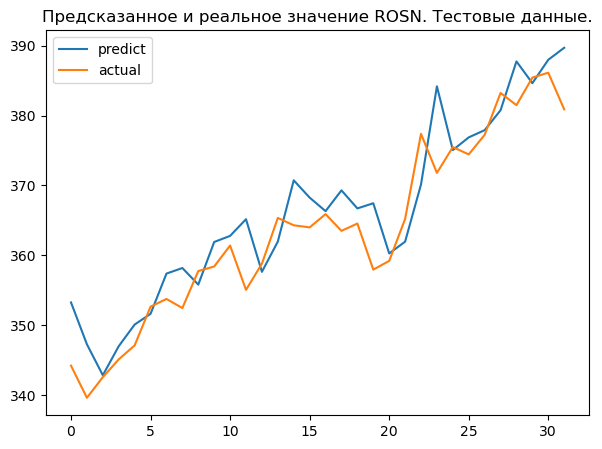

1/1 [==============================] - 0s 49ms/step


In [89]:
model_lstm(X_train_rosn, y_train_rosn, X_test_rosn, y_test_rosn, 'ROSN', 30)

## Нефть

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 128)               66560     
                                                                 
 dense_316 (Dense)           (None, 128)               16512     
                                                                 
 dense_317 (Dense)           (None, 1)                 129       
                                                                 
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
_________________________________________________________________


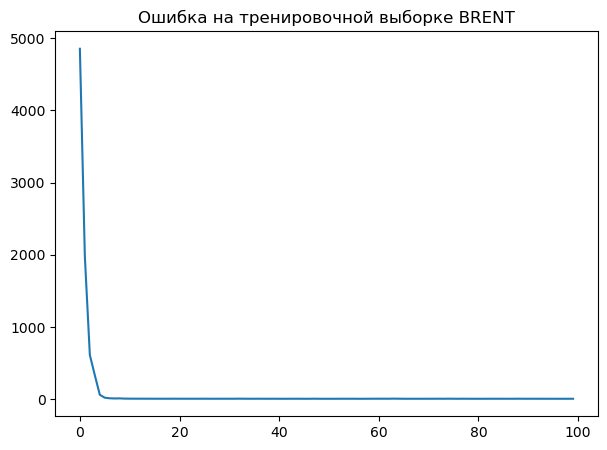

29/29 [==============================] - 0s 11ms/step


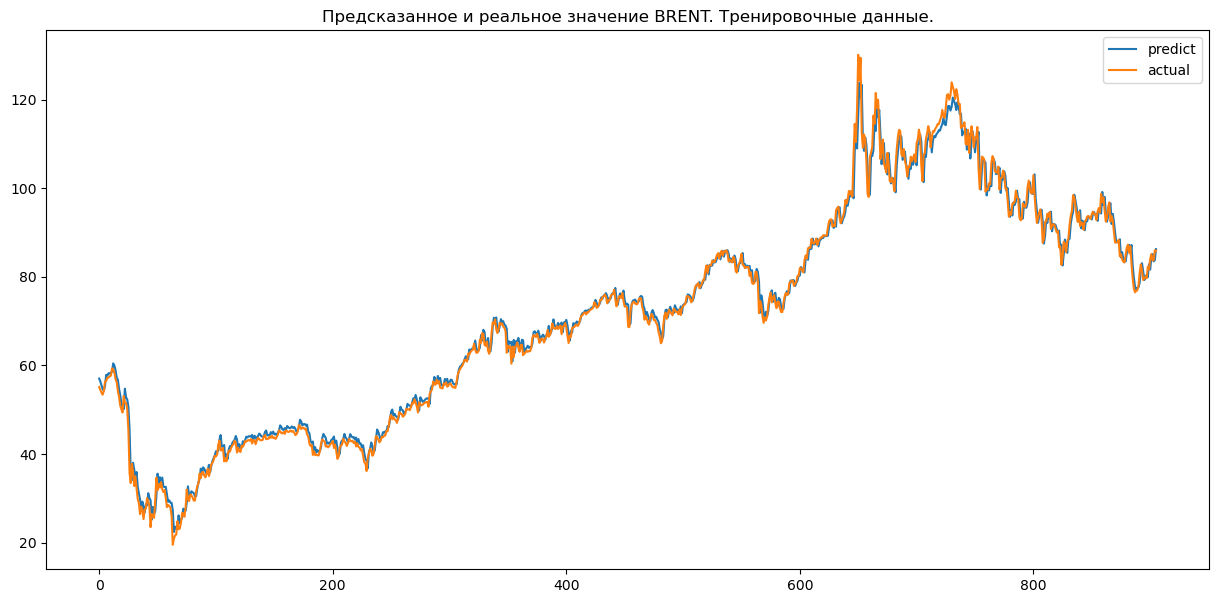

2/2 [==============================] - 0s 9ms/step


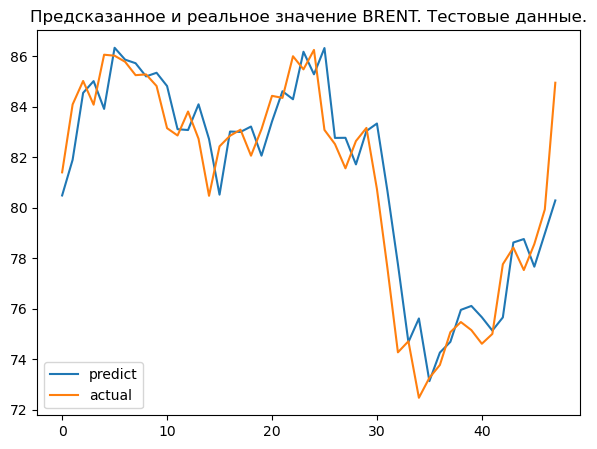

2/2 [==============================] - 0s 8ms/step


In [90]:
model_lstm(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

## Природный газ

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                16896     
                                                                 
 dense_326 (Dense)           (None, 256)               16640     
                                                                 
 dense_327 (Dense)           (None, 1)                 257       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


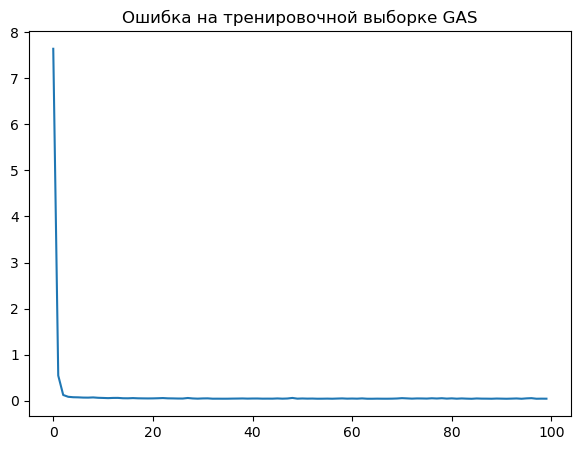

29/29 [==============================] - 0s 6ms/step


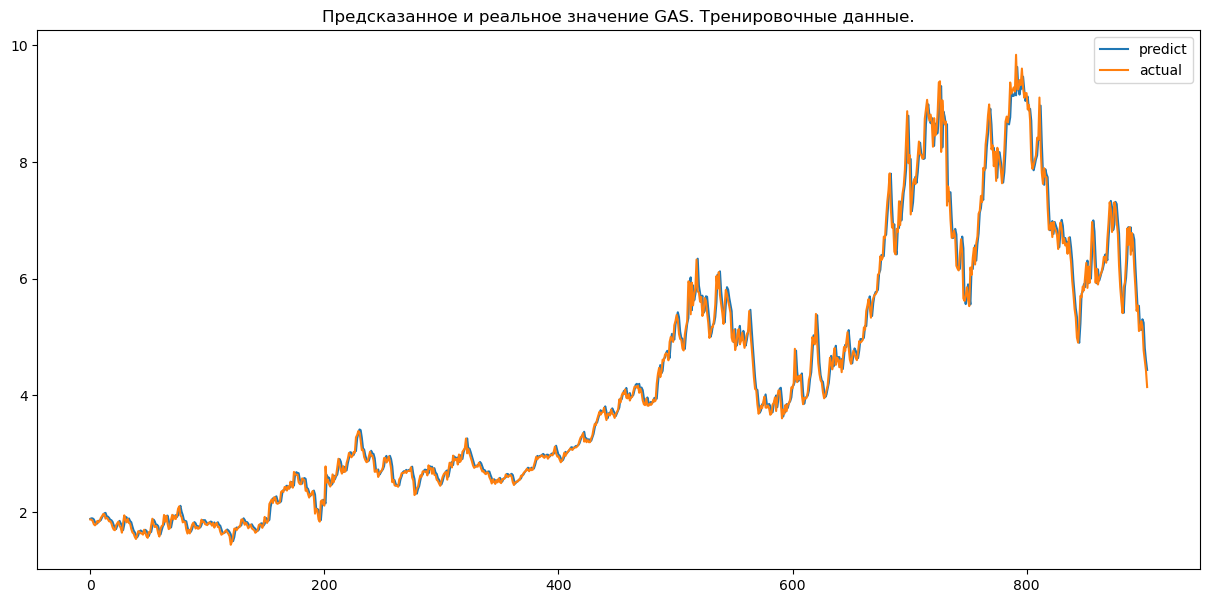

2/2 [==============================] - 0s 6ms/step


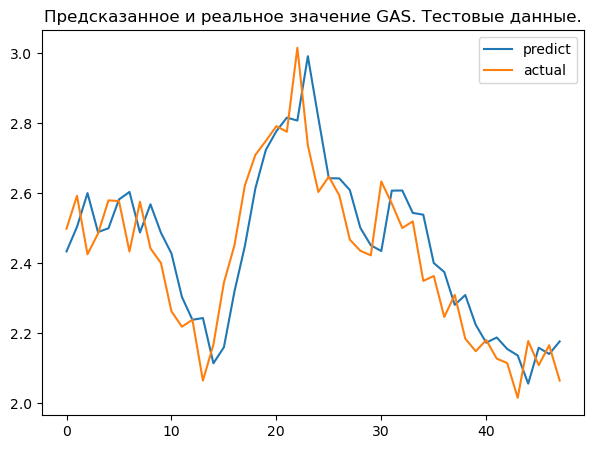

2/2 [==============================] - 0s 6ms/step


In [91]:
model_lstm(X_train_gas, y_train_gas, X_test_gas, y_test_gas, 'GAS', 30)

In [92]:
#ошибки прогнозирования
data_loss_lstm

ticker num_lstm num_dense sample      mape       mae       mpe       rmse
0   GAZP      256       256  train  0.019722  4.704113  0.868182   7.831550
1   GAZP      256       256   test  0.012709  2.107907  0.653789   3.380819
2   ROSN       64       256  train  0.020609  8.584643 -1.222389  12.745145
3   ROSN       64       256   test  0.011221  4.065364 -0.755556   5.226099
4  BRENT      128       128  train  0.022661  1.438885 -0.912707   2.059658
5  BRENT      128       128   test  0.014248  1.149206 -0.246309   1.561208
6    GAS       64       256  train  0.030612  0.133671 -0.640585   0.202146
7    GAS       64       256   test  0.038752  0.093491 -1.260359   0.114656

# Рекуррентные нейронные сети. GRU

In [68]:
data_loss_gru =  pd.DataFrame(columns = ['ticker','num_gru','num_dense','sample','mape','mae','mpe','rmse'])

In [105]:
def model_gru(X_train, y_train, X_test, y_test, ticker, inp):
    global data_loss_gru
    #поиск оптимального количества нейронов на слоях
    num_1_list = [64, 128, 256]
    num_2_list = [128, 256]
    num_list = list(itertools.product(num_1_list, num_2_list))
    best_loss = np.inf
    for params in num_list:
        model = K.Sequential([
            K.layers.InputLayer((inp, 1)),
            K.layers.GRU(params[0]),
            K.layers.Dense(params[1], activation = 'relu'), 
            K.layers.Dense(1)
        ])

        model.compile(optimizer='adam',
                  loss='mse')
        history = model.fit(X_train, y_train, epochs=100, verbose=0)
        
        y_true = y_test
        y_pred = model.predict(X_test, verbose = 0)
        
        if mean_absolute_percentage_error(y_true, y_pred) < best_loss:
            best_loss = mean_absolute_percentage_error(y_true, y_pred)
            num_1 = params[0]
            num_2 = params[1]
            best_model = model
            best_history = history
    
    #вывод информации о лучшей модели и ее обучении
    best_model.summary()
    plt.figure(figsize = (7,5))
    plt.plot(best_history.history['loss'])
    plt.title(f'Ошибка на тренировочной выборке {ticker}')
    plt.show()
    
    #предсказание на тренировочных данных
    y_ = best_model.predict(X_train)
    plt.figure(figsize = (15,7))
    plt.plot(y_)
    plt.plot(y_train)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тренировочные данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #предсказание на тестовых данных
    y_ = best_model.predict(X_test)
    plt.figure(figsize = (7,5))
    plt.plot(y_)
    plt.plot(y_test)
    plt.title(f'Предсказанное и реальное значение {ticker}. Тестовые данные.')
    plt.legend(['predict', 'actual'])
    plt.show()
    
    #расчет ошибок и заполнение таблицы
    y_true = y_train
    y_pred = best_model.predict(X_train)
    losses_1 = pd.DataFrame({'ticker':ticker,
                      'sample': 'train',
                      'num_gru': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    y_true = y_test
    y_pred = best_model.predict(X_test)
    losses_2 = pd.DataFrame({'ticker':ticker,
                      'sample': 'test',
                      'num_gru': num_1,
                      'num_dense': num_2,
                      'mape': mean_absolute_percentage_error(y_true, y_pred),
                      'mae': mean_absolute_error(y_true, y_pred),
                      'mpe': mpe(y_true, y_pred),
                      'rmse': np.sqrt(mean_squared_error(y_true, y_pred))}, index = [0])

    data_loss_gru = pd.concat([data_loss_gru, losses_1, losses_2], ignore_index = True)

## Газпром

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 256)               198912    
                                                                 
 dense_176 (Dense)           (None, 128)               32896     
                                                                 
 dense_177 (Dense)           (None, 1)                 129       
                                                                 
Total params: 231,937
Trainable params: 231,937
Non-trainable params: 0
_________________________________________________________________


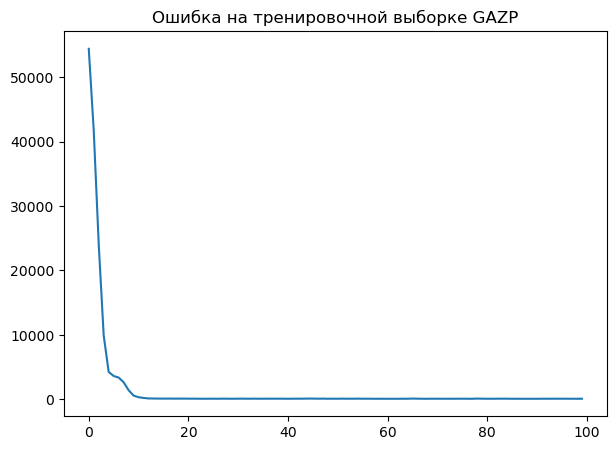

23/23 [==============================] - 1s 16ms/step


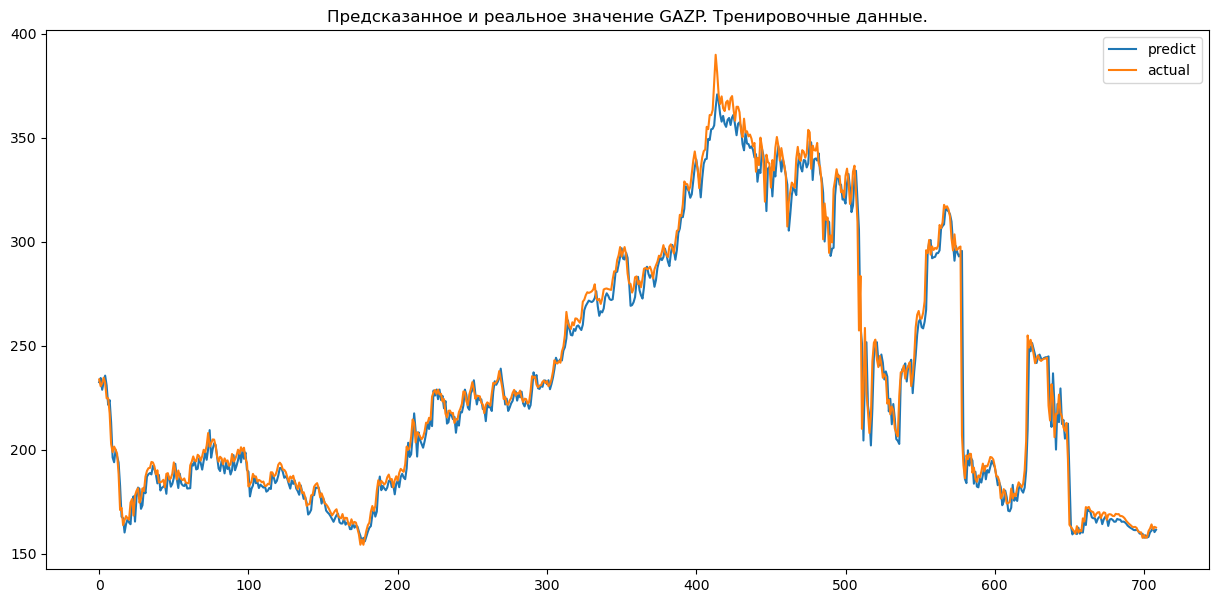

1/1 [==============================] - 0s 36ms/step


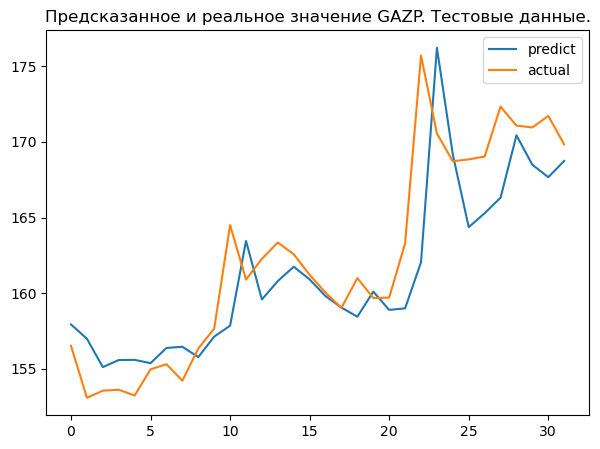

1/1 [==============================] - 0s 40ms/step


In [70]:
model_gru(X_train_gazp, y_train_gazp, X_test_gazp, y_test_gazp, 'GAZP', 30)

##  Роснефть

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                12864     
                                                                 
 dense_182 (Dense)           (None, 256)               16640     
                                                                 
 dense_183 (Dense)           (None, 1)                 257       
                                                                 
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________________________


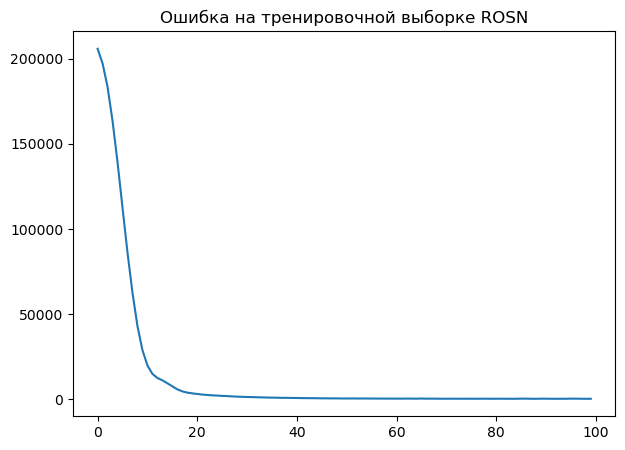

23/23 [==============================] - 1s 6ms/step


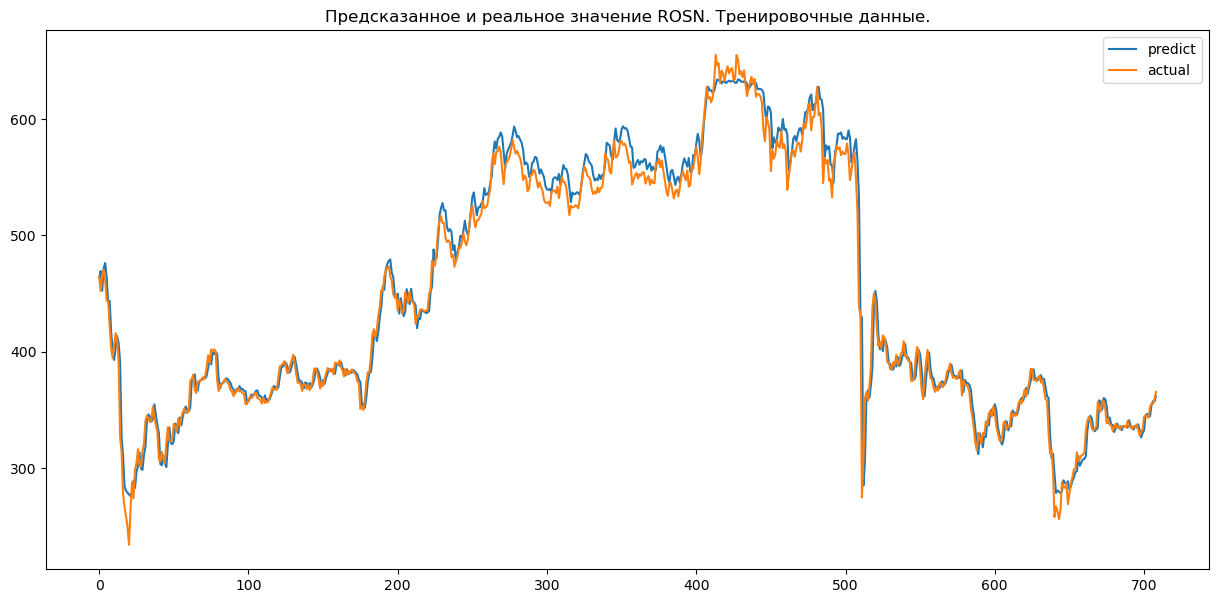

1/1 [==============================] - 0s 43ms/step


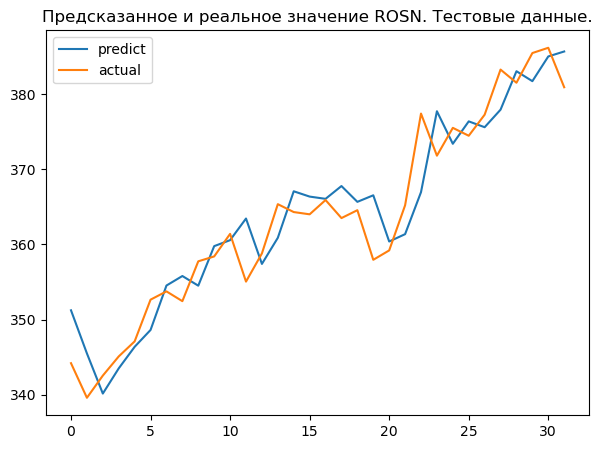

1/1 [==============================] - 0s 36ms/step


In [71]:
model_gru(X_train_rosn, y_train_rosn, X_test_rosn, y_test_rosn, 'ROSN', 30)

## Нефть

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 64)                12864     
                                                                 
 dense_194 (Dense)           (None, 256)               16640     
                                                                 
 dense_195 (Dense)           (None, 1)                 257       
                                                                 
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________________________


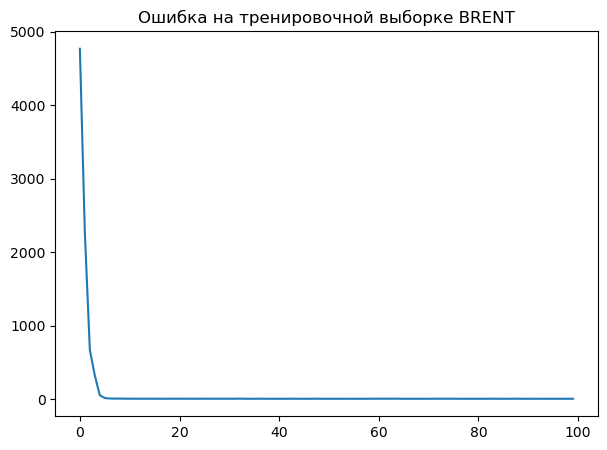

29/29 [==============================] - 0s 7ms/step


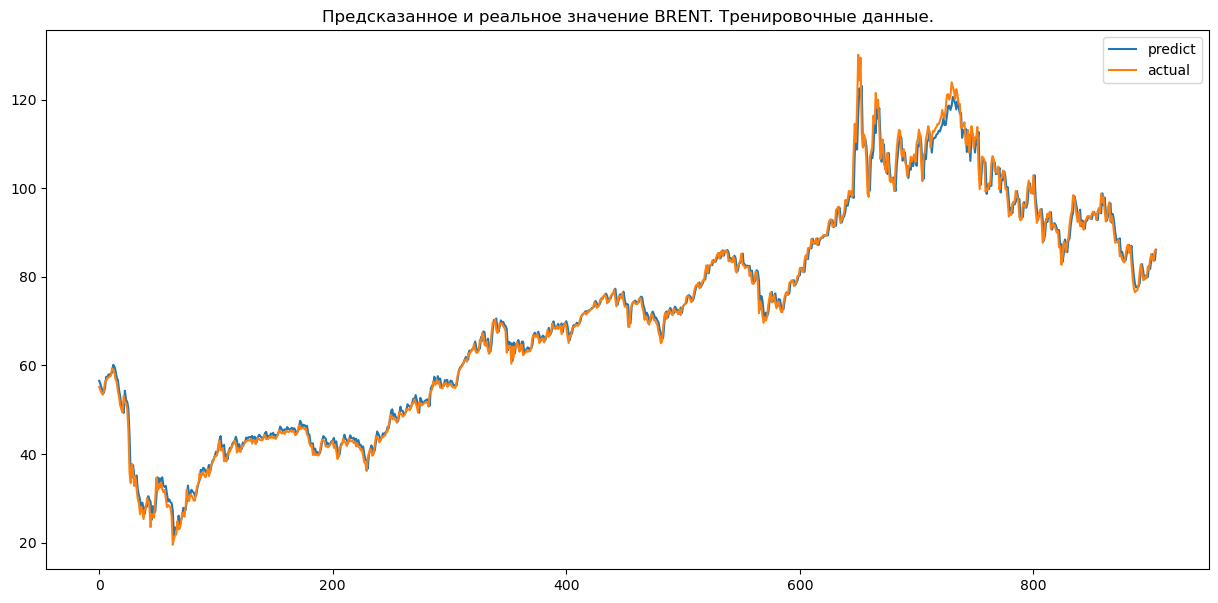

2/2 [==============================] - 0s 5ms/step


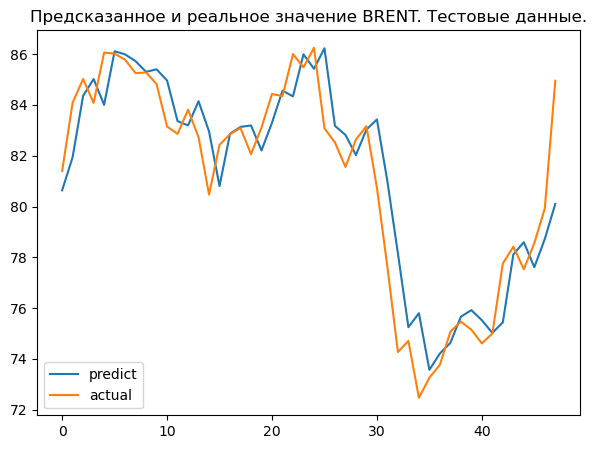

2/2 [==============================] - 0s 6ms/step


In [72]:
model_gru(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

## Природный газ

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 64)                12864     
                                                                 
 dense_204 (Dense)           (None, 128)               8320      
                                                                 
 dense_205 (Dense)           (None, 1)                 129       
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


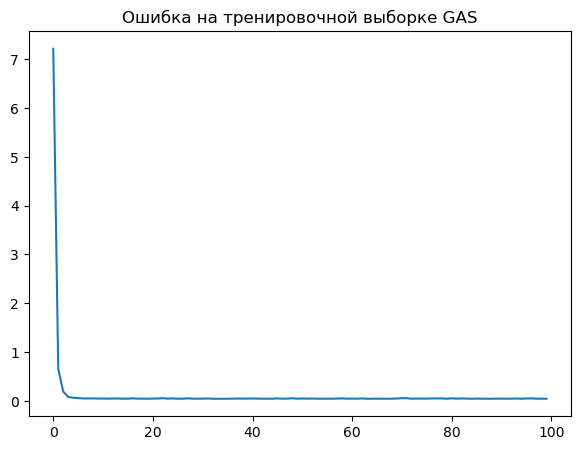

29/29 [==============================] - 0s 10ms/step


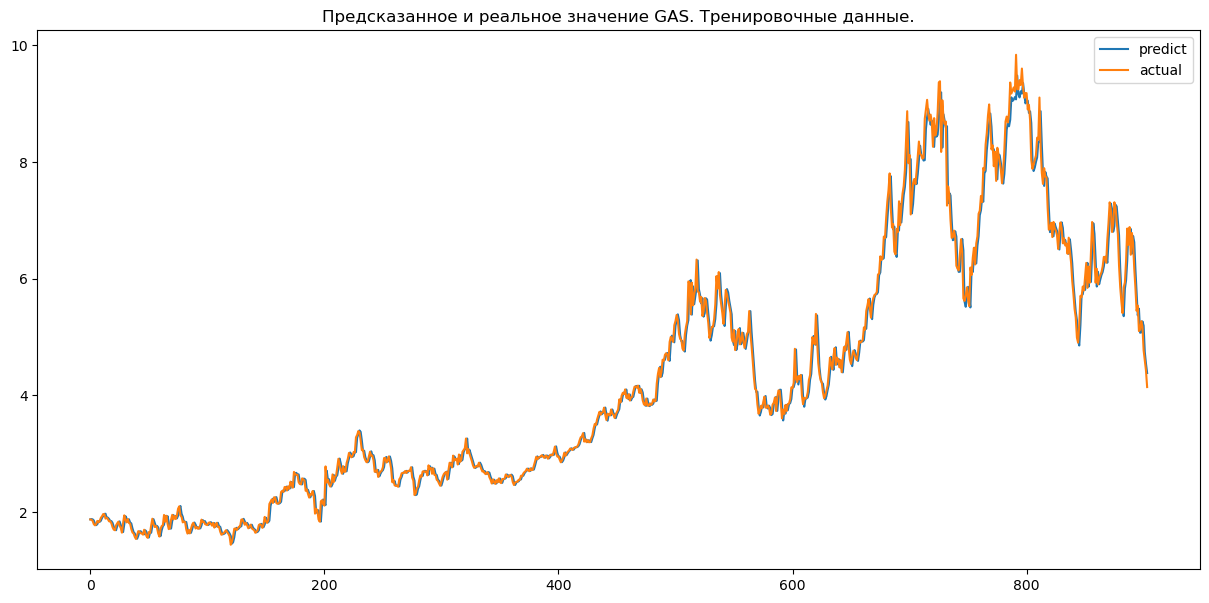

2/2 [==============================] - 0s 16ms/step


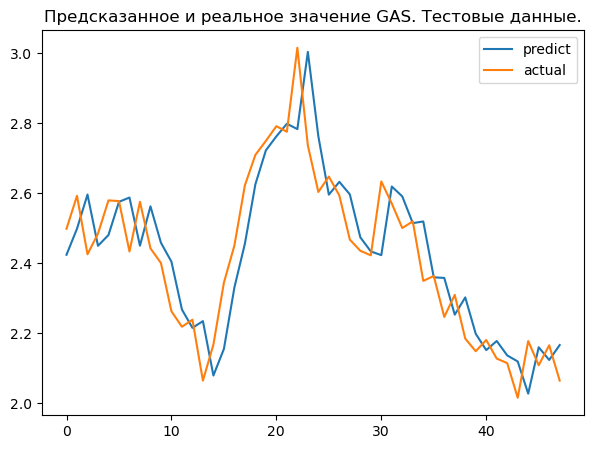

2/2 [==============================] - 0s 10ms/step


In [73]:
model_gru(X_train_gas, y_train_gas, X_test_gas, y_test_gas, 'GAS', 30)

In [74]:
#ошибка прогнозирования
data_loss_gru

ticker num_gru num_dense sample      mape       mae       mpe       rmse
0   GAZP     256       128  train  0.020916  4.968545  0.974731   7.917950
1   GAZP     256       128   test  0.015497  2.566723  0.604237   3.708637
2   ROSN      64       256  train  0.021566  9.296159 -0.945845  14.076354
3   ROSN      64       256   test  0.009327  3.385174 -0.135998   4.230523
4  BRENT      64       256  train  0.021136  1.362949 -0.692532   1.999773
5  BRENT      64       256   test  0.014549  1.171297 -0.290866   1.613455
6    GAS      64       128  train  0.029809  0.132606  0.095456   0.201683
7    GAS      64       128   test  0.037739  0.091375 -0.567033   0.111758

## Ошибка на моделях с использованиеи тренировочных данных

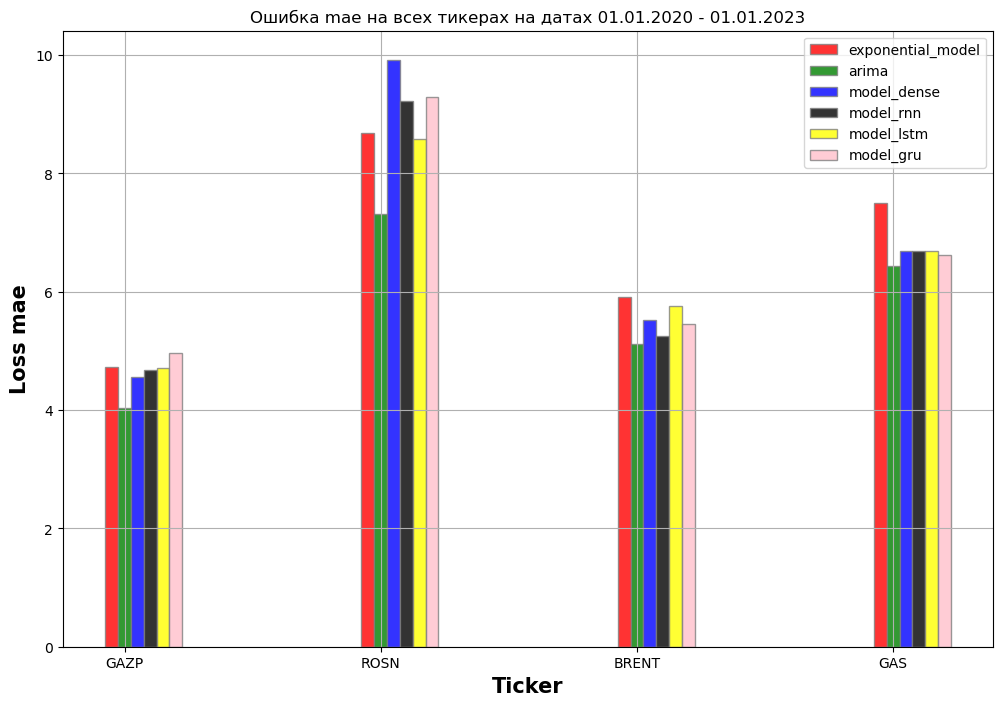

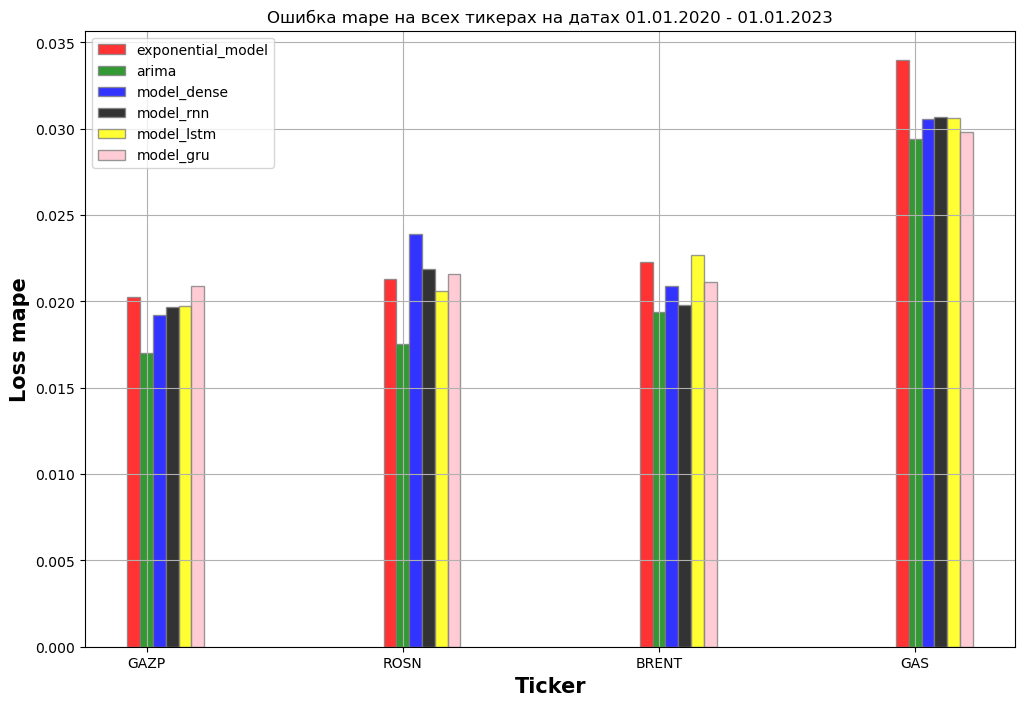

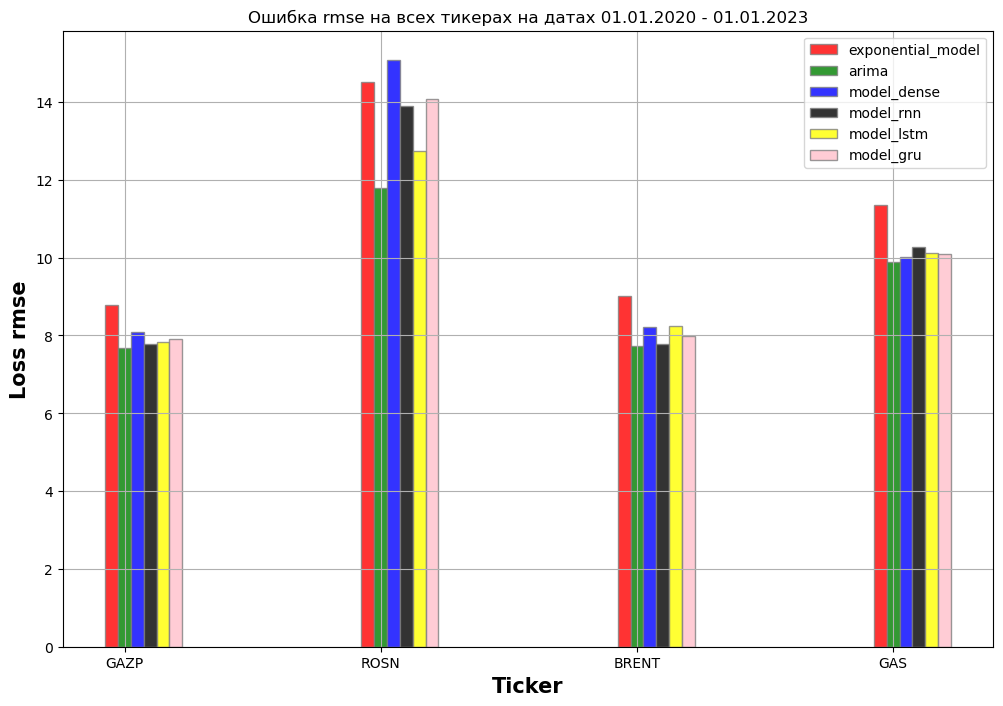

In [93]:
for loss in ['mae','mape','rmse']:
    barWidth = 0.05
    fig = plt.subplots(figsize =(12, 8))
    
    #коэффициенты для ошибок (чтобы столбцы выглдили сравнимыми)
    if loss == 'mape':
        a = [1, 1, 1, 1]
    else:
        a = [1, 1, 4, 50]
        
    #получение ошибок для тренировочных данных
    loss_exp = data_loss_exp[data_loss_exp['alpha']==0.5][loss].values * a
    loss_arima = data_loss_arima[loss].values * a
    loss_dense = data_loss_dense[data_loss_dense['sample']=='train'][loss].values * a
    loss_rnn = data_loss_rnn[data_loss_rnn['sample']=='train'][loss].values * a
    loss_lstm = data_loss_lstm[data_loss_lstm['sample']=='train'][loss].values * a
    loss_gru = data_loss_gru[data_loss_gru['sample']=='train'][loss].values * a

    #списки для постреония стлбцов с ошибками
    br1 = np.arange(len(loss_exp))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    br6 = [x + barWidth for x in br5]

    #построение графика
    plt.bar(br1, loss_exp, color ='r', width = barWidth,
            edgecolor ='grey', label ='exponential_model', alpha = 0.8)
    plt.bar(br2, loss_arima, color ='g', width = barWidth,
            edgecolor ='grey', label ='arima', alpha = 0.8)
    plt.bar(br3, loss_dense, color ='b', width = barWidth,
            edgecolor ='grey', label ='model_dense', alpha = 0.8)
    plt.bar(br4, loss_rnn, color ='black', width = barWidth,
            edgecolor ='grey', label ='model_rnn', alpha = 0.8)
    plt.bar(br5, loss_lstm, color ='yellow', width = barWidth,
            edgecolor ='grey', label ='model_lstm', alpha = 0.8)
    plt.bar(br6, loss_gru, color ='pink', width = barWidth,
            edgecolor ='grey', label ='model_gru', alpha = 0.8)

    plt.xlabel('Ticker', fontweight ='bold', fontsize = 15)
    plt.ylabel(f'Loss {loss}', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(loss_exp))],
            ['GAZP','ROSN','BRENT','GAS'])
    plt.title(f'Ошибка {loss} на всех тикерах на датах 01.01.2020 - 01.01.2023')
    plt.grid()
    plt.legend()
    plt.show()

## Ошибка на моделях с использованиеи тестовых данных

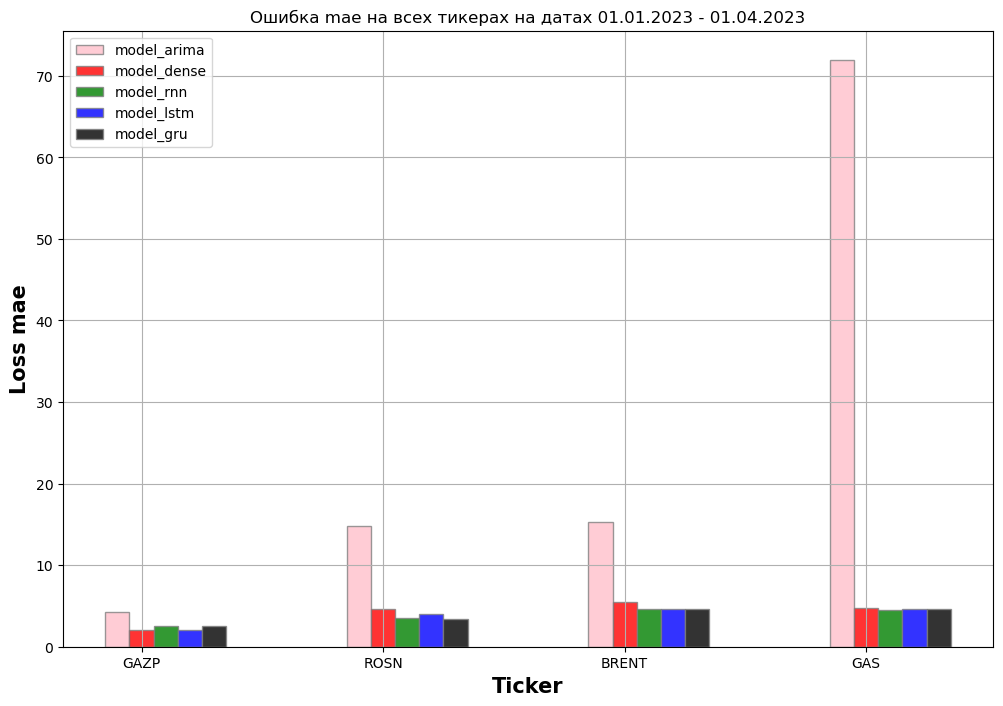

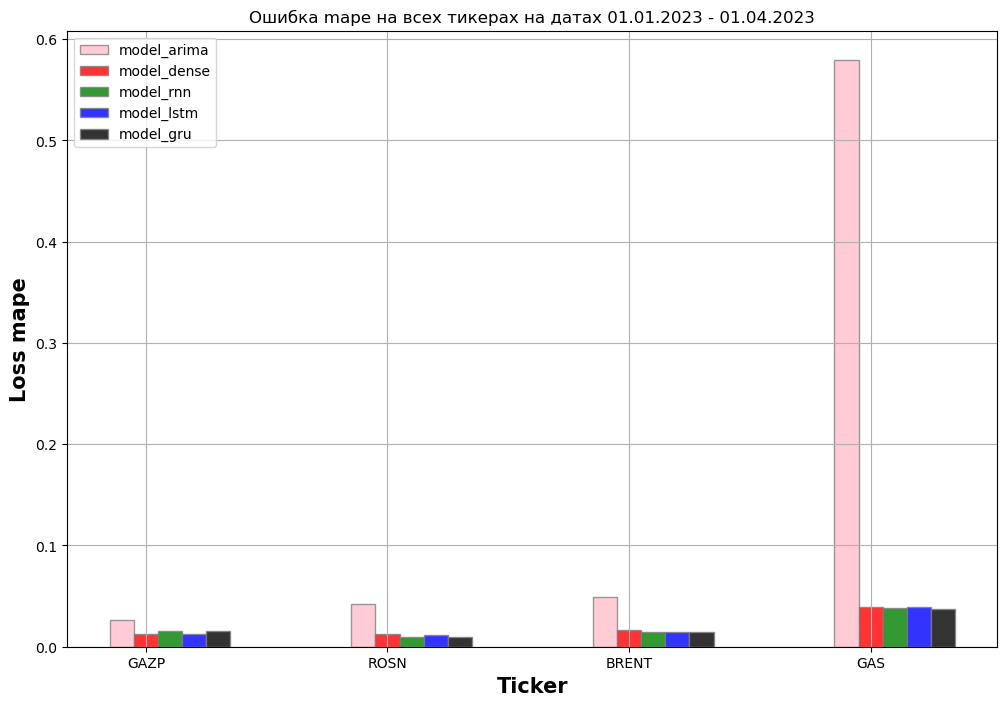

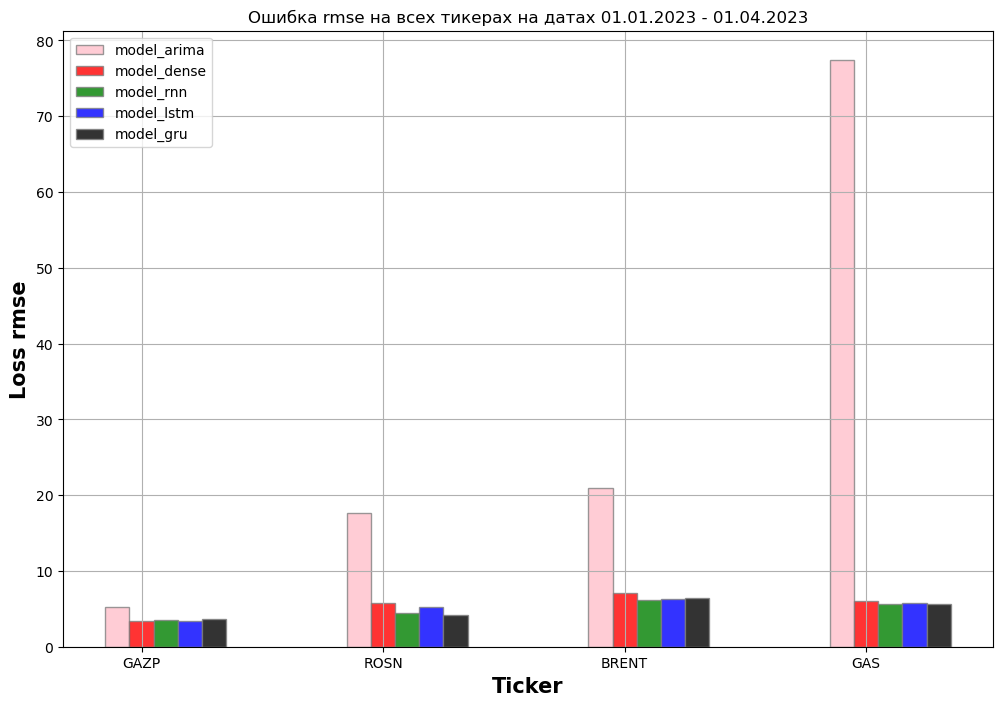

In [373]:
for loss in ['mae','mape','rmse']:
    barWidth = 0.1
    fig = plt.subplots(figsize =(12, 8))
    if loss == 'mape':
        a = [1, 1, 1, 1]
    else:
        a = [1, 1, 4, 50]
        
    loss_arima = data_loss_arima[data_loss_arima['sample']=='test'][loss].values[:4] * a
    loss_dense = data_loss_dense[data_loss_dense['sample']=='test'][loss].values[:4] * a
    loss_rnn = data_loss_rnn[data_loss_rnn['sample']=='test'][loss].values[:4] * a
    loss_lstm = data_loss_lstm[data_loss_lstm['sample']=='test'][loss].values[:4] * a
    loss_gru = data_loss_gru[data_loss_gru['sample']=='test'][loss].values[:4] * a


    br1 = np.arange(len(loss_dense))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    
    plt.bar(br1, loss_arima, color ='pink', width = barWidth,
            edgecolor ='grey', label ='model_arima', alpha = 0.8)
    plt.bar(br2, loss_dense, color ='r', width = barWidth,
            edgecolor ='grey', label ='model_dense', alpha = 0.8)
    plt.bar(br3, loss_rnn, color ='g', width = barWidth,
            edgecolor ='grey', label ='model_rnn', alpha = 0.8)
    plt.bar(br4, loss_lstm, color ='b', width = barWidth,
            edgecolor ='grey', label ='model_lstm', alpha = 0.8)
    plt.bar(br5, loss_gru, color ='black', width = barWidth,
            edgecolor ='grey', label ='model_gru', alpha = 0.8)


    plt.xlabel('Ticker', fontweight ='bold', fontsize = 15)
    plt.ylabel(f'Loss {loss}', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(loss_exp))],
            ['GAZP','ROSN','BRENT','GAS'])
    plt.title(f'Ошибка {loss} на всех тикерах на датах 01.01.2023 - 01.04.2023')
    plt.grid()
    plt.legend()
    plt.show()

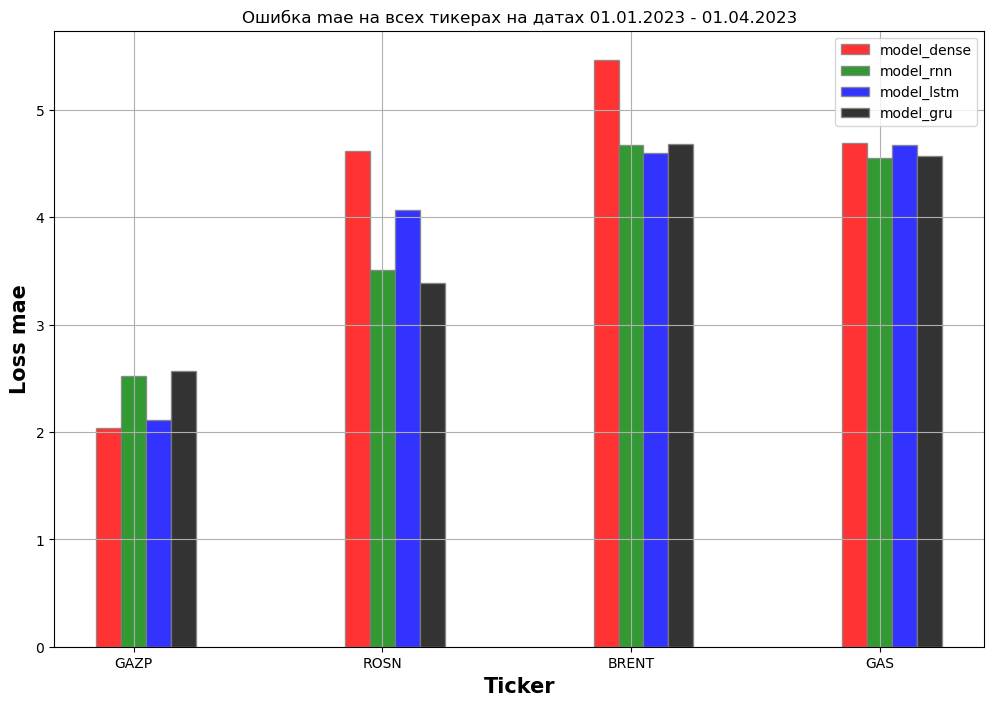

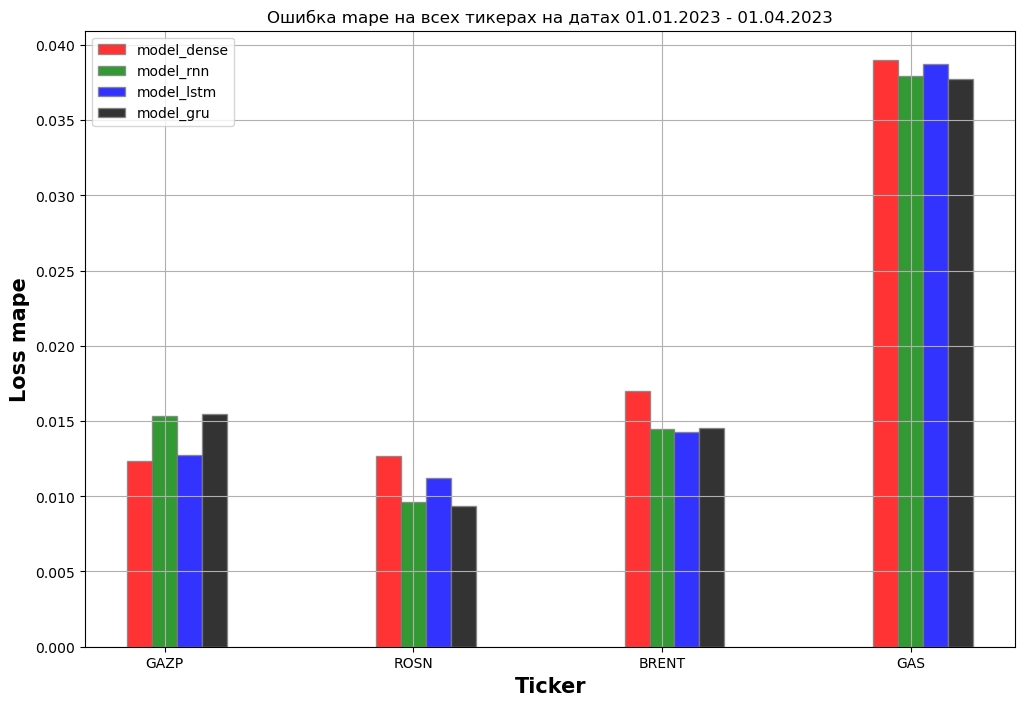

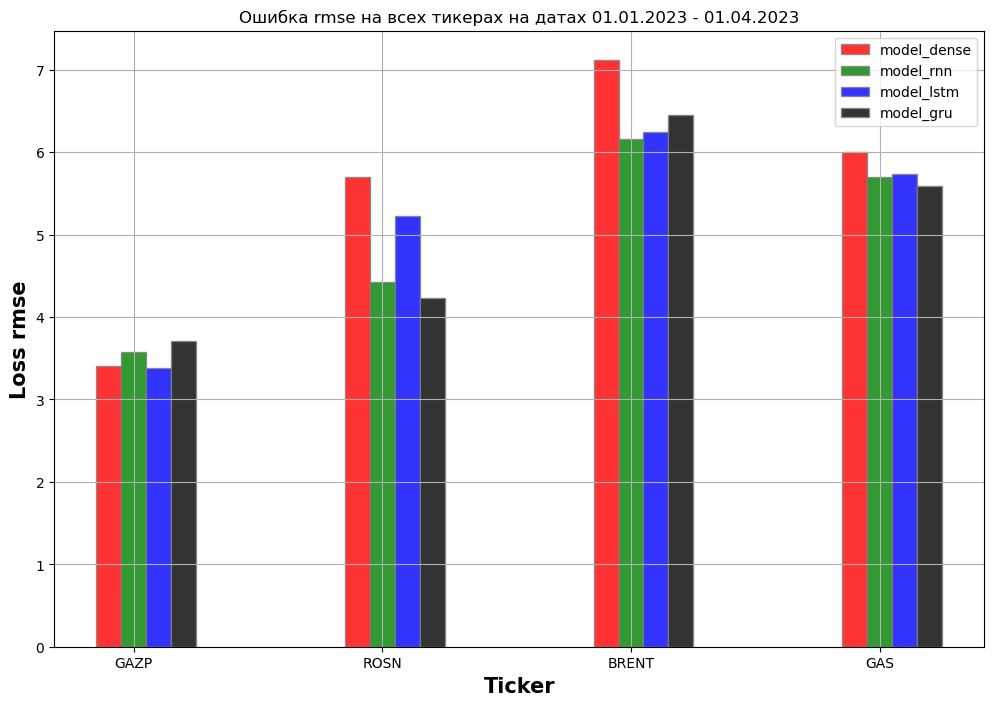

In [374]:
for loss in ['mae','mape','rmse']:
    barWidth = 0.1
    fig = plt.subplots(figsize =(12, 8))
    if loss == 'mape':
        a = [1, 1, 1, 1]
    else:
        a = [1, 1, 4, 50]
        
    loss_dense = data_loss_dense[data_loss_dense['sample']=='test'][loss].values[:4] * a
    loss_rnn = data_loss_rnn[data_loss_rnn['sample']=='test'][loss].values[:4] * a
    loss_lstm = data_loss_lstm[data_loss_lstm['sample']=='test'][loss].values[:4] * a
    loss_gru = data_loss_gru[data_loss_gru['sample']=='test'][loss].values[:4] * a


    br1 = np.arange(len(loss_dense))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    
    plt.bar(br1, loss_dense, color ='r', width = barWidth,
            edgecolor ='grey', label ='model_dense', alpha = 0.8)
    plt.bar(br2, loss_rnn, color ='g', width = barWidth,
            edgecolor ='grey', label ='model_rnn', alpha = 0.8)
    plt.bar(br3, loss_lstm, color ='b', width = barWidth,
            edgecolor ='grey', label ='model_lstm', alpha = 0.8)
    plt.bar(br4, loss_gru, color ='black', width = barWidth,
            edgecolor ='grey', label ='model_gru', alpha = 0.8)


    plt.xlabel('Ticker', fontweight ='bold', fontsize = 15)
    plt.ylabel(f'Loss {loss}', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(loss_exp))],
            ['GAZP','ROSN','BRENT','GAS'])
    plt.title(f'Ошибка {loss} на всех тикерах на датах 01.01.2023 - 01.04.2023')
    plt.grid()
    plt.legend()
    plt.show()

## Влияние размер окна на качество моделей

### Нефть

## ws = 20

In [267]:
ws = 20

In [268]:
train = np.array(data_brent.close.values)
N1 = len(train)
X_train_brent  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_brent = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [269]:
X_train_brent = np.array(X_train_brent)
y_train_brent = np.array(y_train_brent)

In [270]:
test = np.array(data_brent_test.close.values)
N1 = len(test)
X_test_brent  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_brent = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [271]:
X_test_brent = np.array(X_test_brent[-38:])
y_test_brent = np.array(y_test_brent[-38:])

Model: "sequential_311"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_728 (Dense)           (None, 128)               2688      
                                                                 
 dense_729 (Dense)           (None, 32)                4128      
                                                                 
 dense_730 (Dense)           (None, 1)                 33        
                                                                 
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________


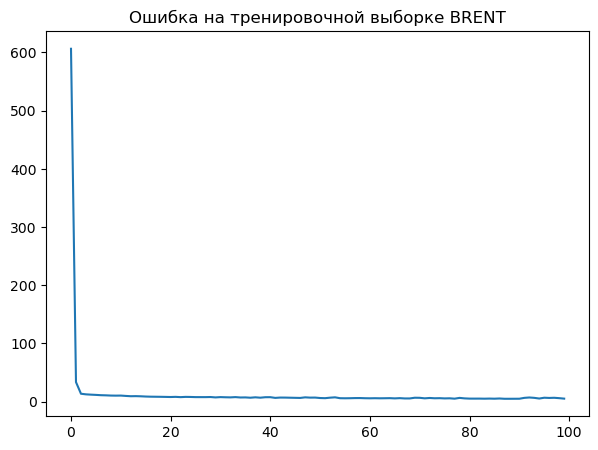

29/29 [==============================] - 0s 1ms/step


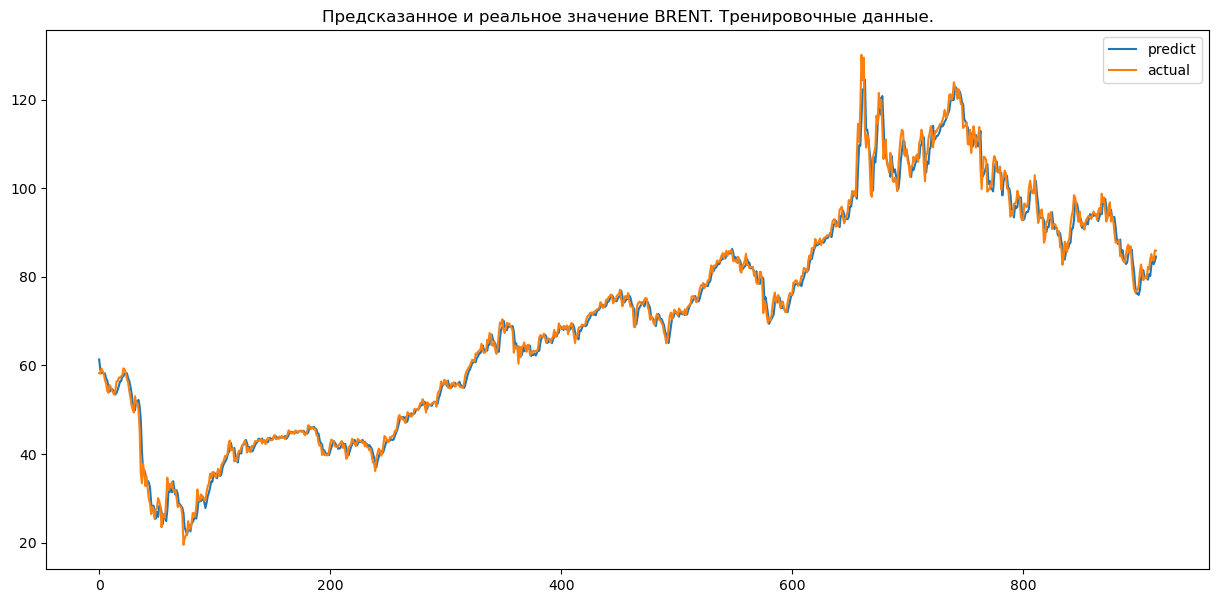

2/2 [==============================] - 0s 6ms/step


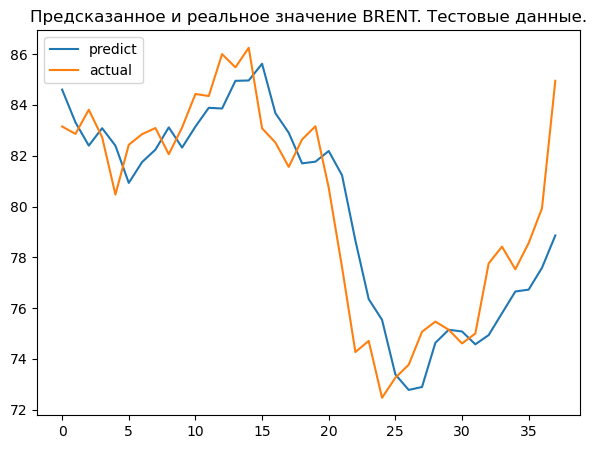

2/2 [==============================] - 0s 3ms/step


In [272]:
model_dense(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 20)

Model: "sequential_317"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_63 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_744 (Dense)           (None, 128)               16512     
                                                                 
 dense_745 (Dense)           (None, 1)                 129       
                                                                 
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
_________________________________________________________________


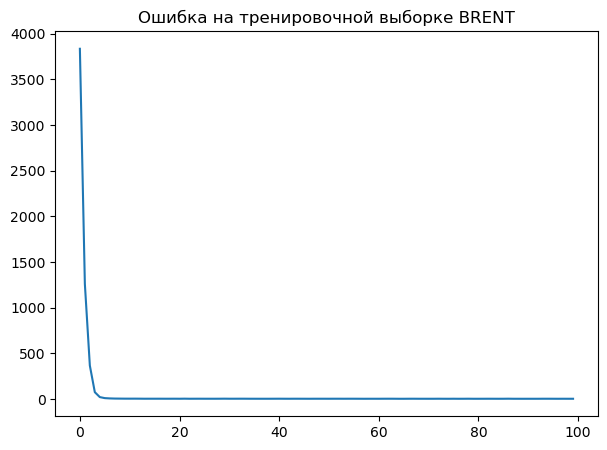

29/29 [==============================] - 0s 4ms/step


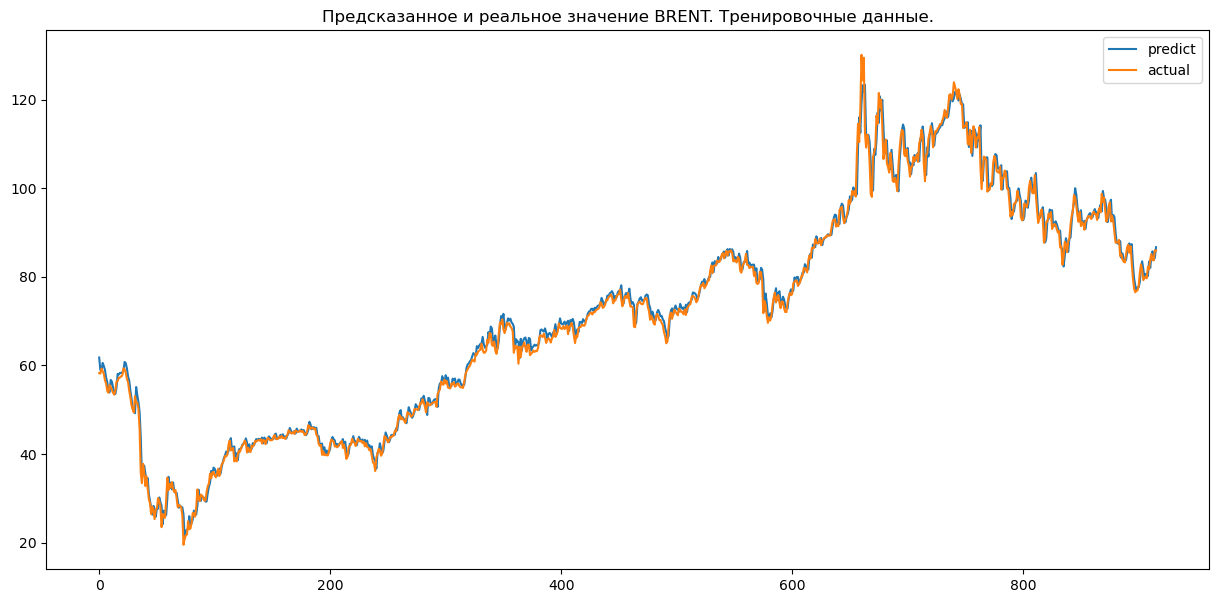

2/2 [==============================] - 0s 6ms/step


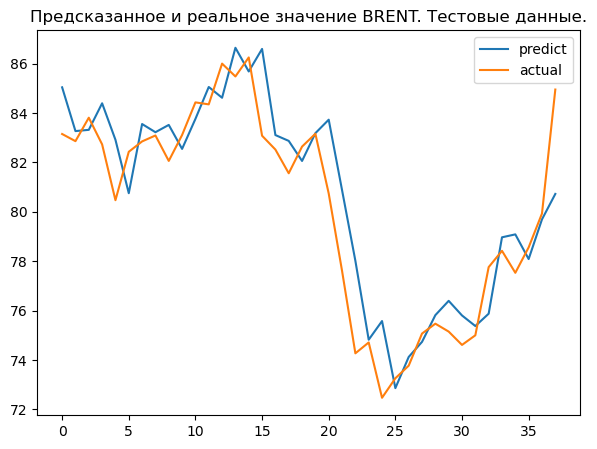

2/2 [==============================] - 0s 6ms/step


In [273]:
model_rnn(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 20)

Model: "sequential_321"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 64)                16896     
                                                                 
 dense_752 (Dense)           (None, 128)               8320      
                                                                 
 dense_753 (Dense)           (None, 1)                 129       
                                                                 
Total params: 25,345
Trainable params: 25,345
Non-trainable params: 0
_________________________________________________________________


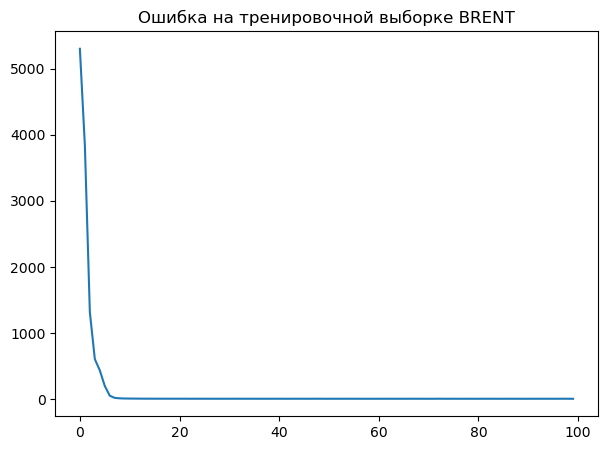

29/29 [==============================] - 0s 5ms/step


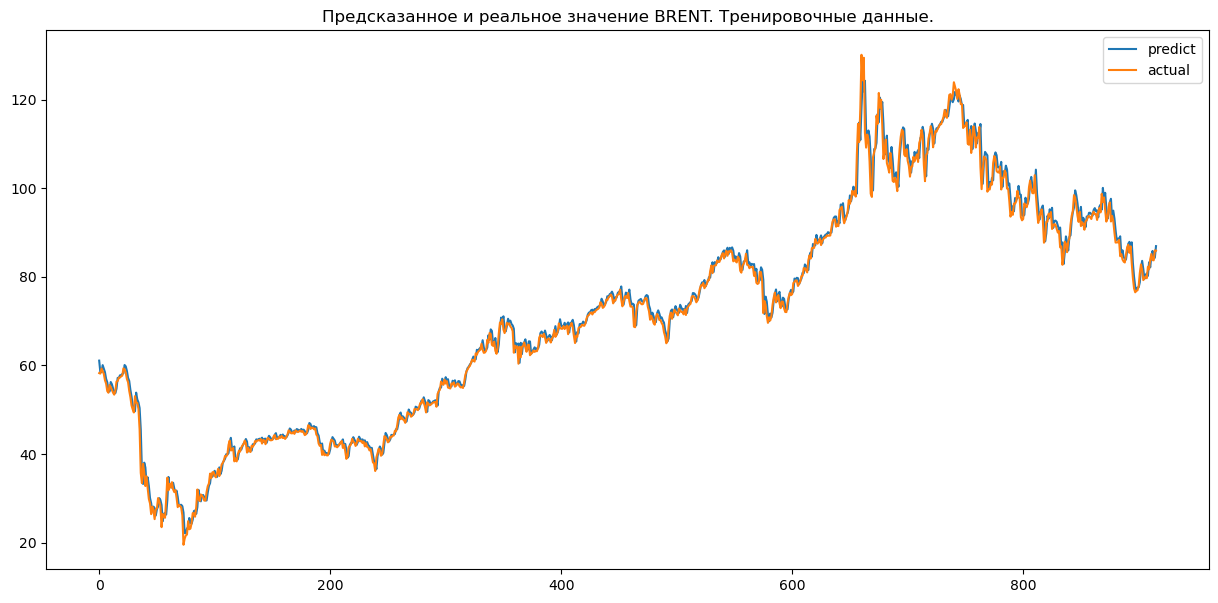

2/2 [==============================] - 0s 5ms/step


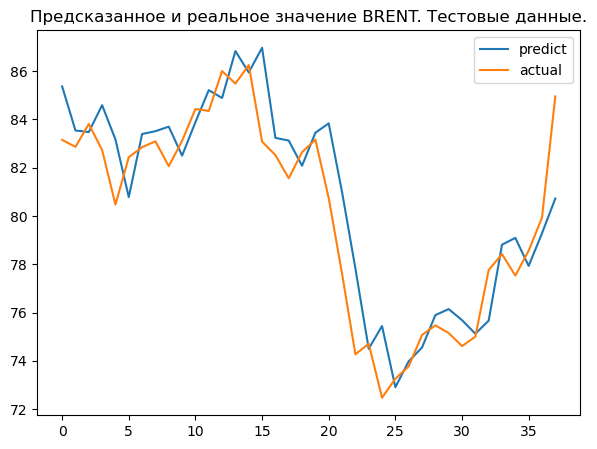

2/2 [==============================] - 0s 6ms/step


In [274]:
model_lstm(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 20)

Model: "sequential_330"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_63 (GRU)                (None, 128)               50304     
                                                                 
 dense_770 (Dense)           (None, 256)               33024     
                                                                 
 dense_771 (Dense)           (None, 1)                 257       
                                                                 
Total params: 83,585
Trainable params: 83,585
Non-trainable params: 0
_________________________________________________________________


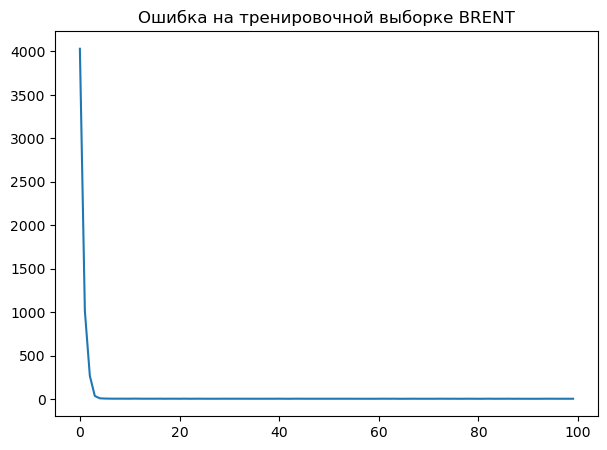

29/29 [==============================] - 0s 6ms/step


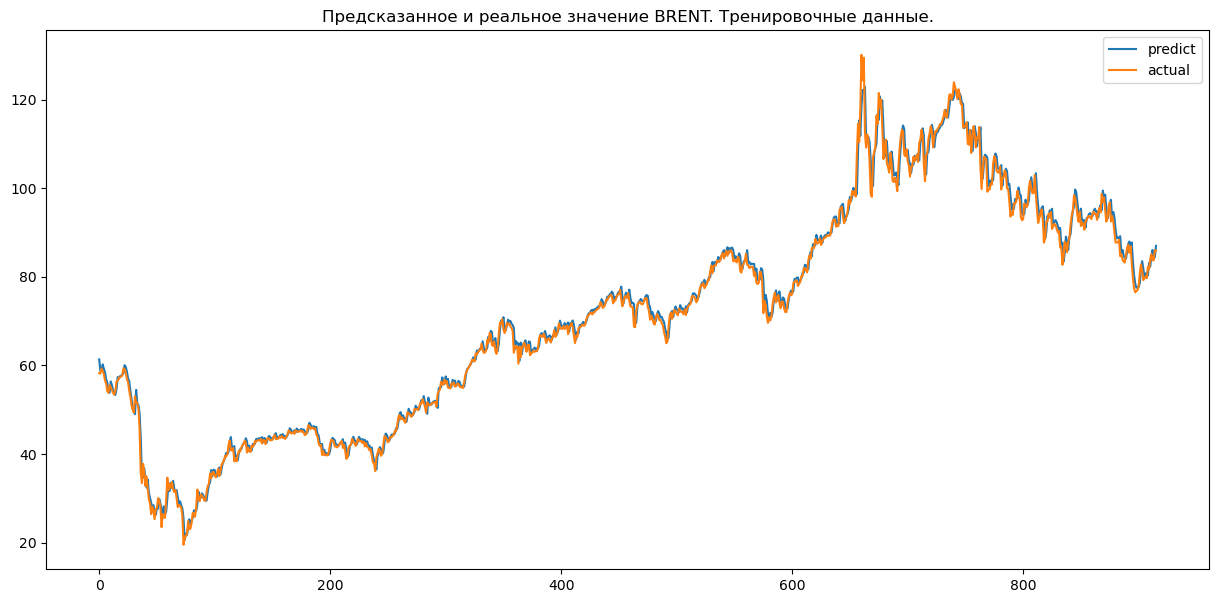

2/2 [==============================] - 0s 5ms/step


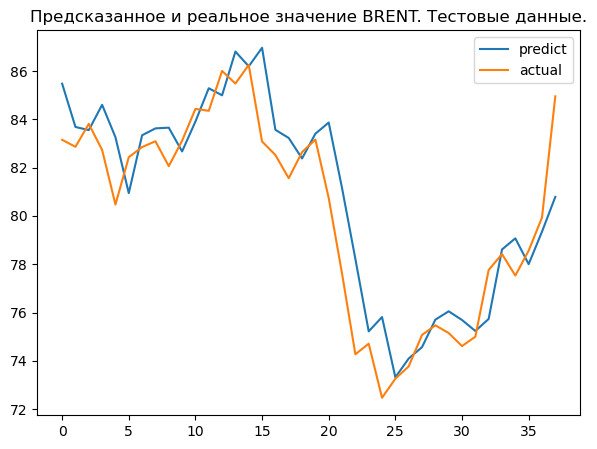

2/2 [==============================] - 0s 5ms/step


In [275]:
model_gru(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 20)

## ws = 30

In [276]:
ws = 30

In [277]:
train = np.array(data_brent.close.values)
N1 = len(train)
X_train_brent  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_brent = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [278]:
X_train_brent = np.array(X_train_brent)
y_train_brent = np.array(y_train_brent)

In [279]:
test = np.array(data_brent_test.close.values)
N1 = len(test)
X_test_brent  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_brent = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [280]:
X_test_brent = np.array(X_test_brent[-38:])
y_test_brent = np.array(y_test_brent[-38:])

Model: "sequential_338"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_791 (Dense)           (None, 256)               7936      
                                                                 
 dense_792 (Dense)           (None, 64)                16448     
                                                                 
 dense_793 (Dense)           (None, 1)                 65        
                                                                 
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


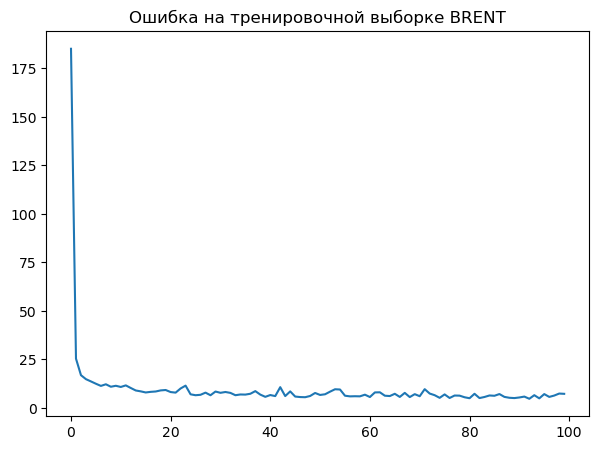

29/29 [==============================] - 0s 2ms/step


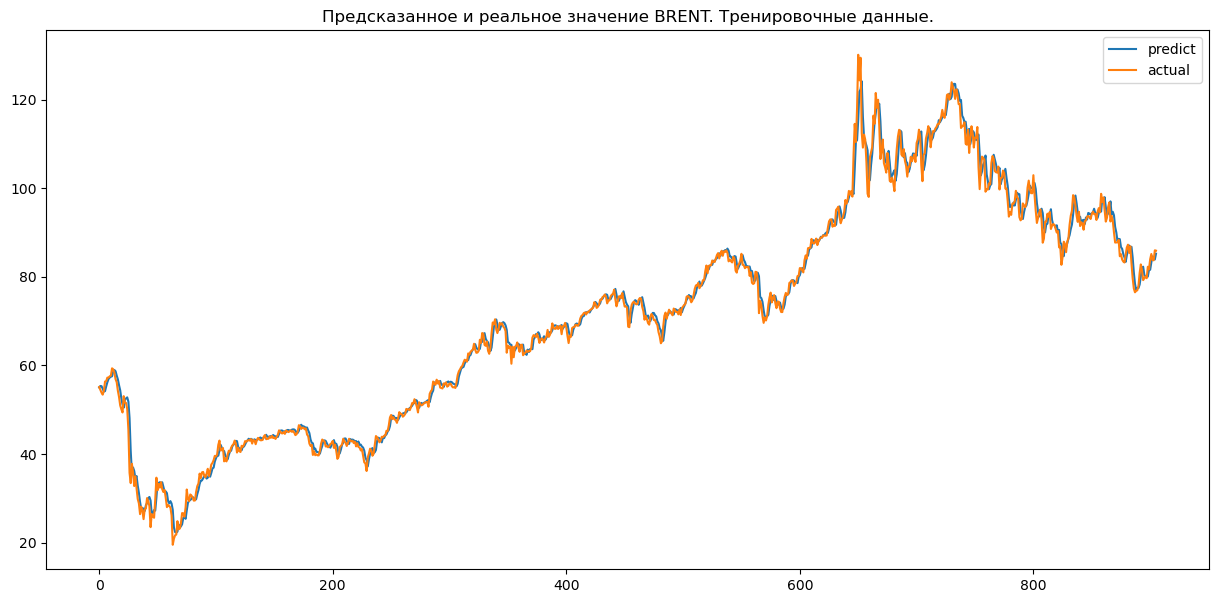

2/2 [==============================] - 0s 3ms/step


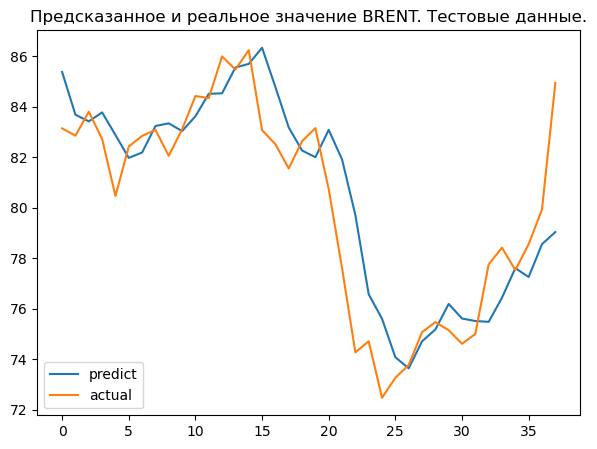

2/2 [==============================] - 0s 3ms/step


In [281]:
model_dense(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

Model: "sequential_342"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_70 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_800 (Dense)           (None, 256)               33024     
                                                                 
 dense_801 (Dense)           (None, 1)                 257       
                                                                 
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________


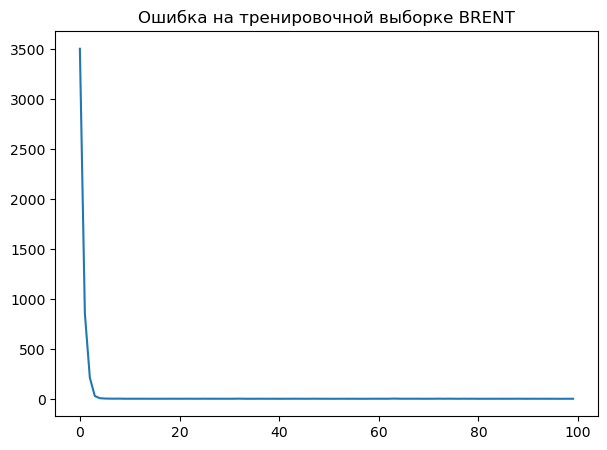

29/29 [==============================] - 0s 4ms/step


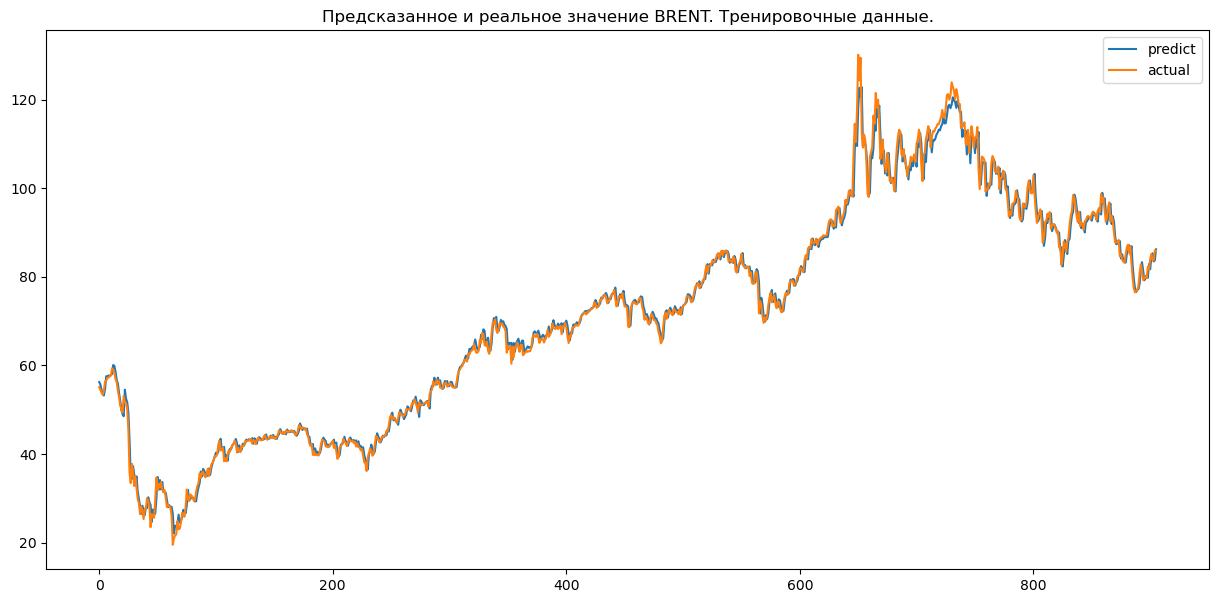

2/2 [==============================] - 0s 4ms/step


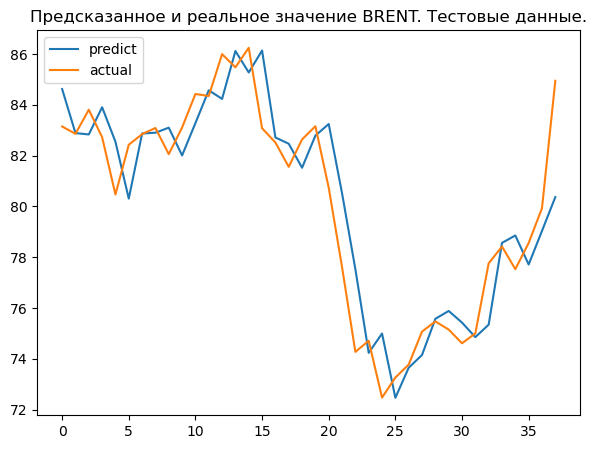

2/2 [==============================] - 0s 5ms/step


In [282]:
model_rnn(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

Model: "sequential_346"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 64)                16896     
                                                                 
 dense_808 (Dense)           (None, 256)               16640     
                                                                 
 dense_809 (Dense)           (None, 1)                 257       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


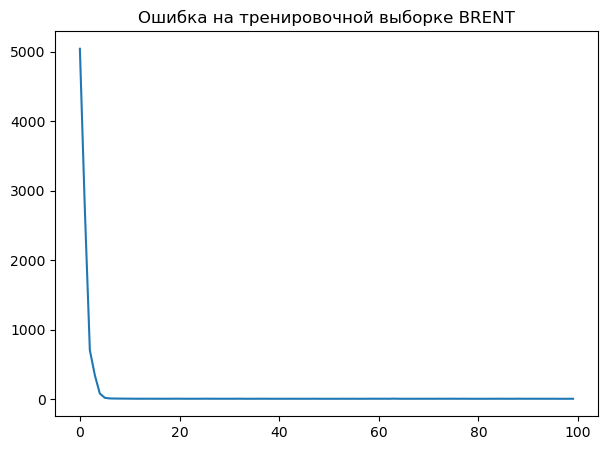

29/29 [==============================] - 0s 7ms/step


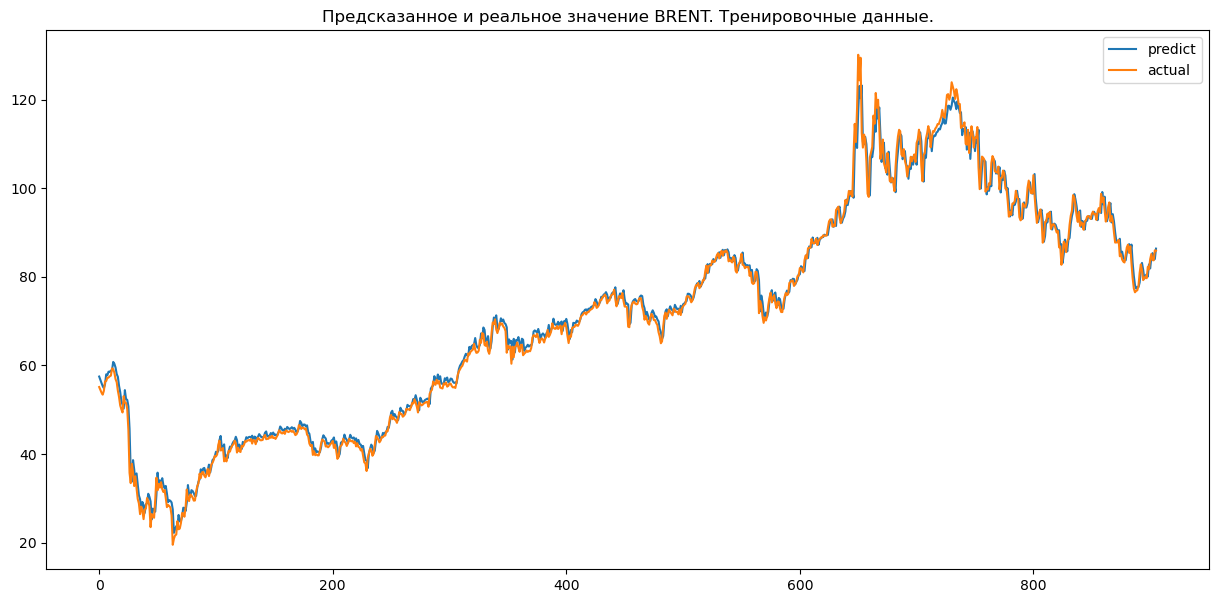

2/2 [==============================] - 0s 7ms/step


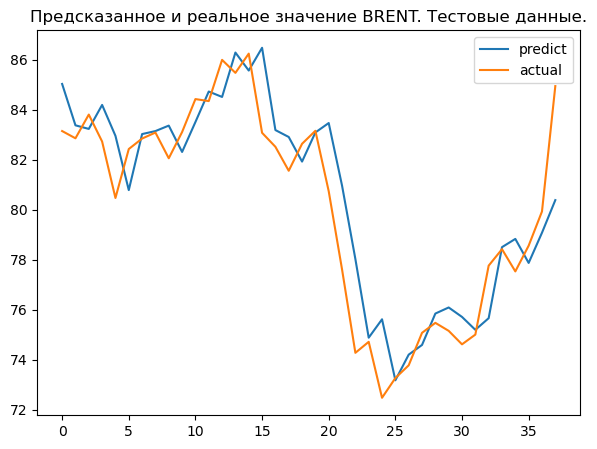

2/2 [==============================] - 0s 6ms/step


In [283]:
model_lstm(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

Model: "sequential_352"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_67 (GRU)                (None, 64)                12864     
                                                                 
 dense_820 (Dense)           (None, 256)               16640     
                                                                 
 dense_821 (Dense)           (None, 1)                 257       
                                                                 
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________________________


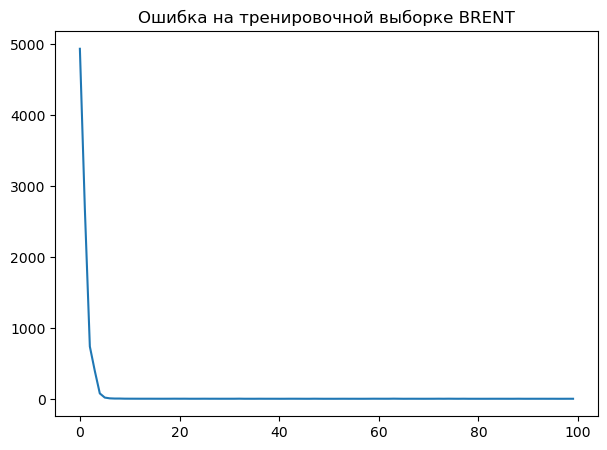

29/29 [==============================] - 0s 12ms/step


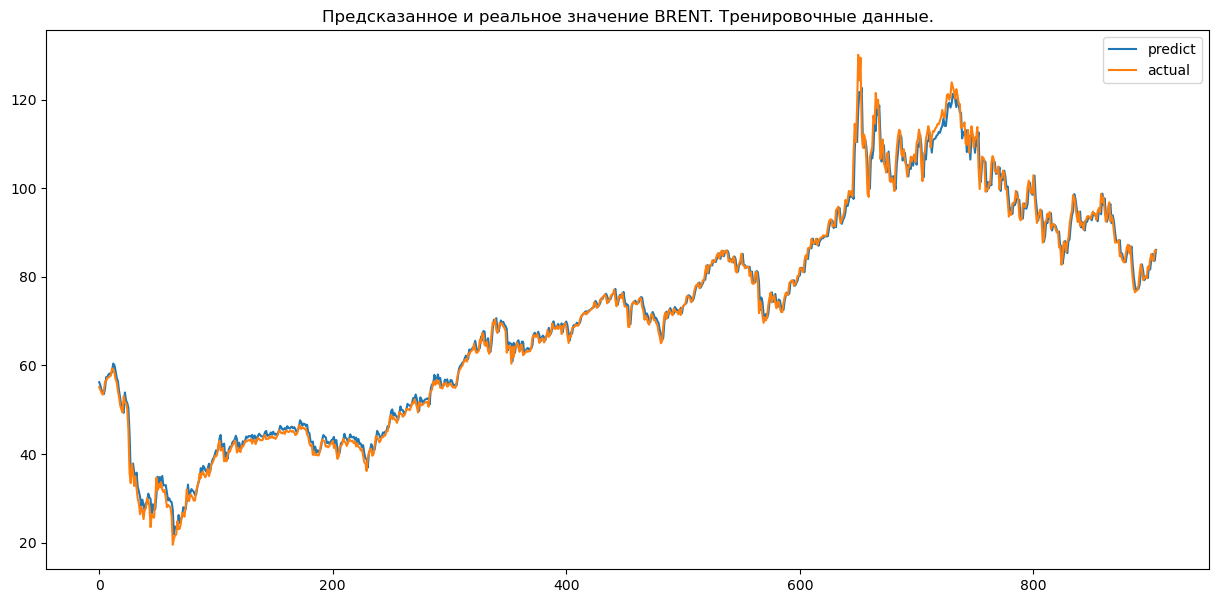

2/2 [==============================] - 0s 9ms/step


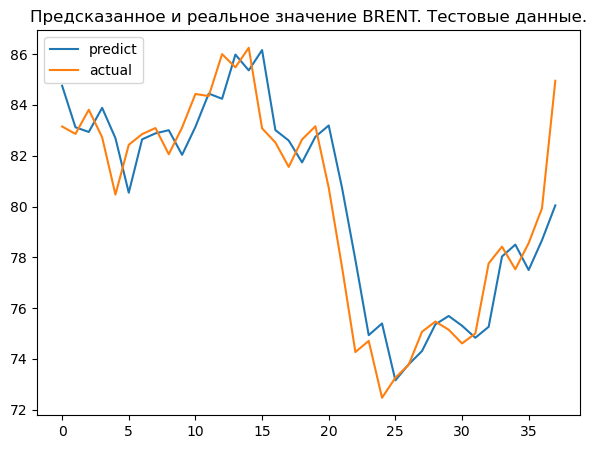

2/2 [==============================] - 0s 10ms/step


In [284]:
model_gru(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 30)

## ws = 40

In [285]:
ws = 40

In [286]:
train = np.array(data_brent.close.values)
N1 = len(train)
X_train_brent  = [train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train_brent = [train[i+ws].reshape(1) for i in range(N1-ws)]

In [287]:
X_train_brent = np.array(X_train_brent)
y_train_brent = np.array(y_train_brent)

In [288]:
test = np.array(data_brent_test.close.values)
N1 = len(test)
X_test_brent  = [test[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_test_brent = [test[i+ws].reshape(1) for i in range(N1-ws)]

In [289]:
X_test_brent = np.array(X_test_brent[-38:])
y_test_brent = np.array(y_test_brent[-38:])

Model: "sequential_358"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_833 (Dense)           (None, 64)                2624      
                                                                 
 dense_834 (Dense)           (None, 64)                4160      
                                                                 
 dense_835 (Dense)           (None, 1)                 65        
                                                                 
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________


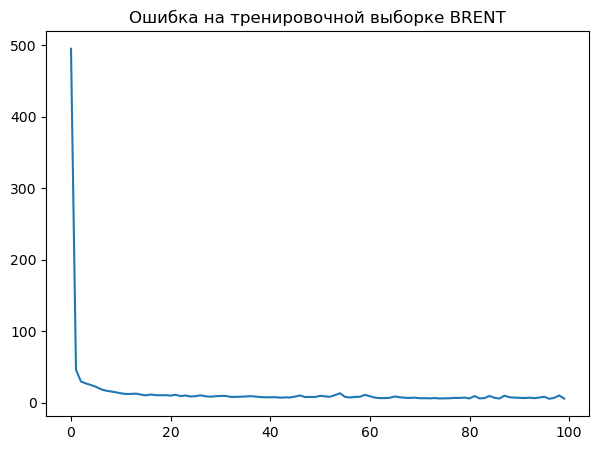

28/28 [==============================] - 0s 2ms/step


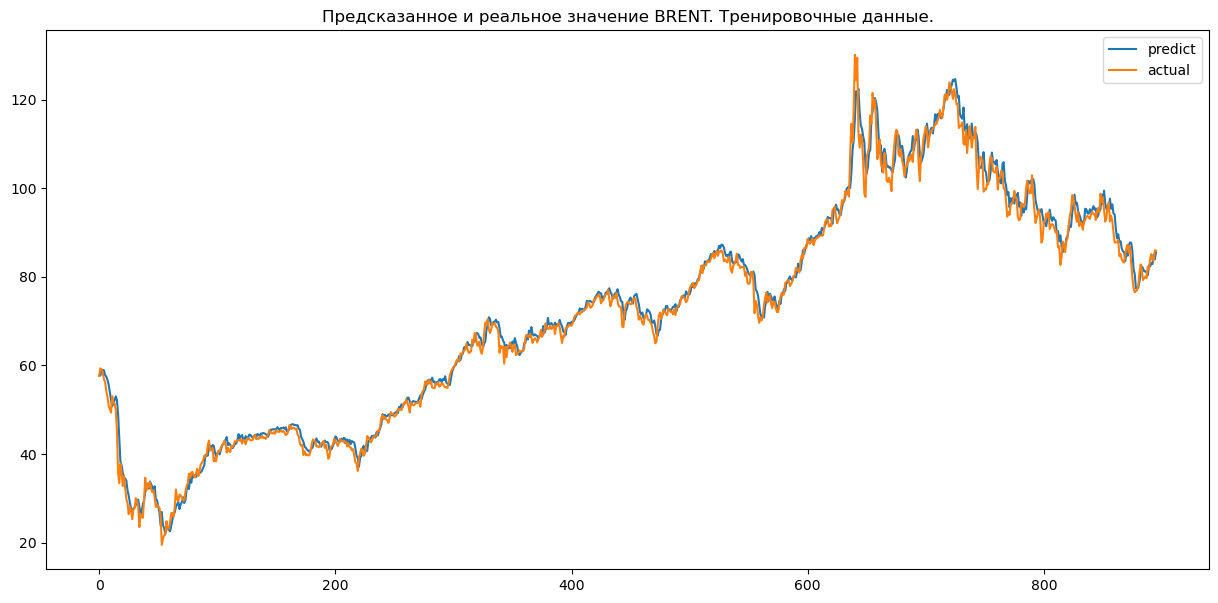

2/2 [==============================] - 0s 3ms/step


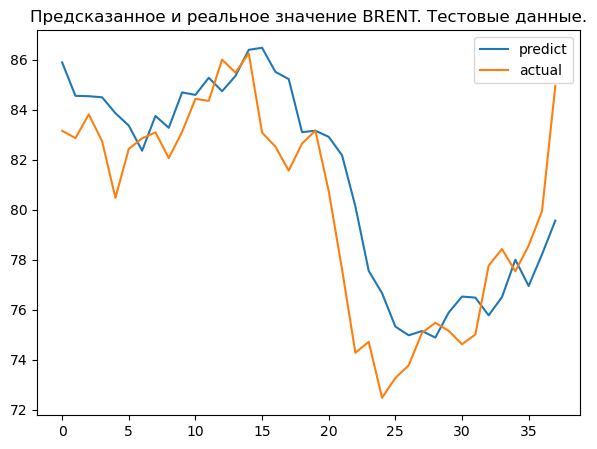

2/2 [==============================] - 0s 2ms/step


In [290]:
model_dense(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 40)

Model: "sequential_363"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_73 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_848 (Dense)           (None, 128)               8320      
                                                                 
 dense_849 (Dense)           (None, 1)                 129       
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


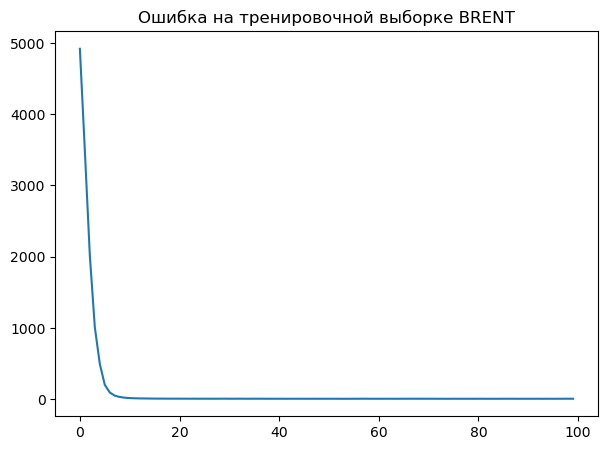

28/28 [==============================] - 0s 3ms/step


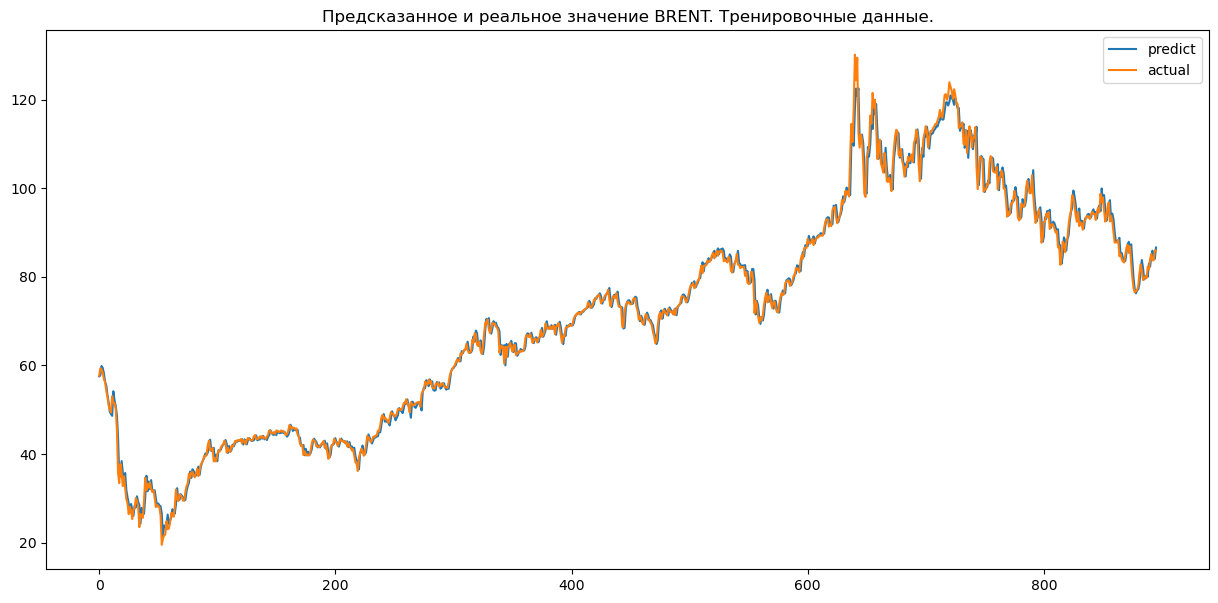

2/2 [==============================] - 0s 5ms/step


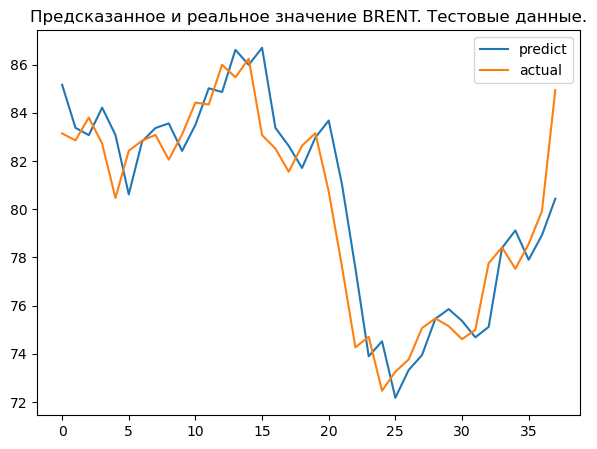

2/2 [==============================] - 0s 5ms/step


In [291]:
model_rnn(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 40)

Model: "sequential_371"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_98 (LSTM)              (None, 128)               66560     
                                                                 
 dense_864 (Dense)           (None, 128)               16512     
                                                                 
 dense_865 (Dense)           (None, 1)                 129       
                                                                 
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
_________________________________________________________________


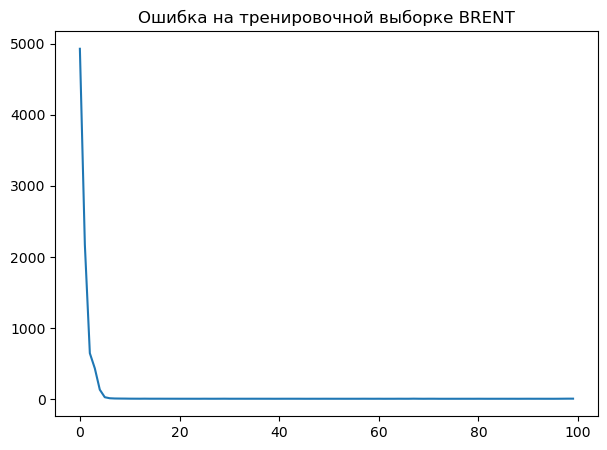

28/28 [==============================] - 0s 16ms/step


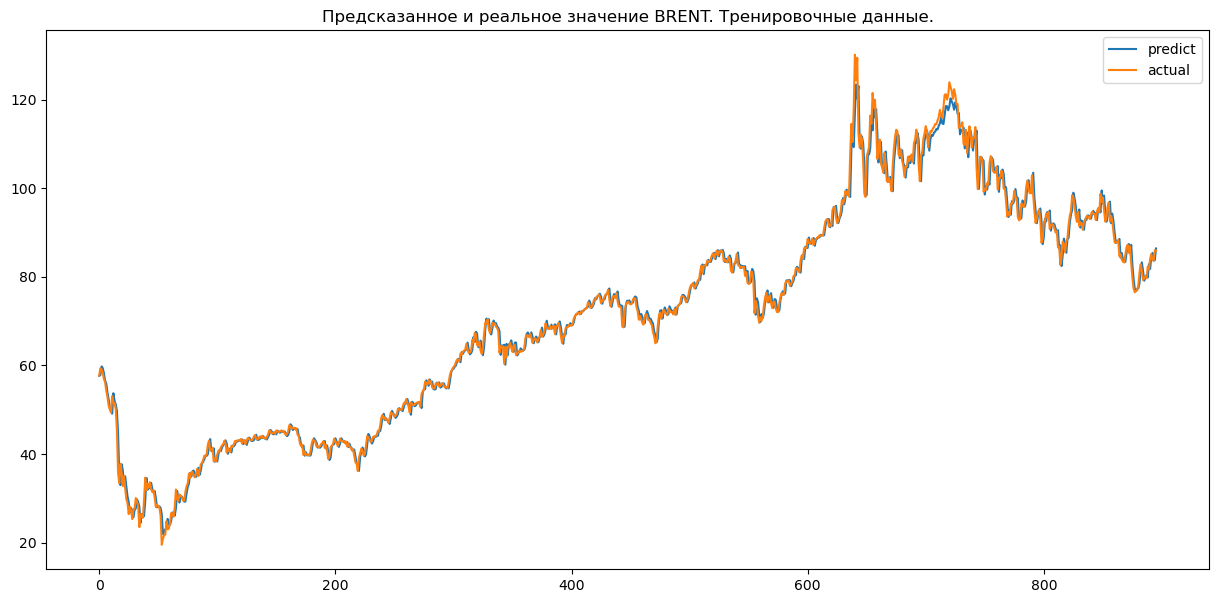

2/2 [==============================] - 0s 8ms/step


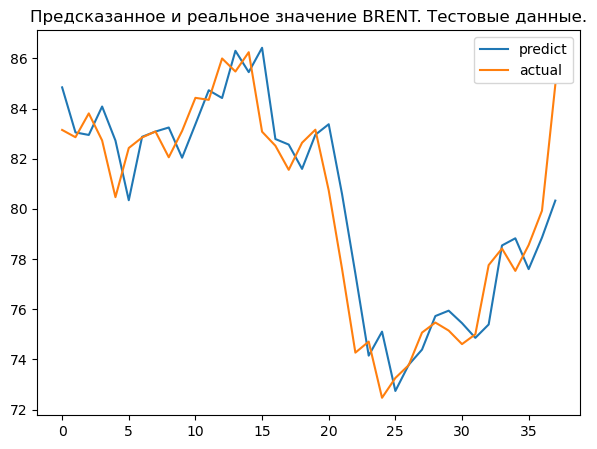

2/2 [==============================] - 0s 9ms/step


In [292]:
model_lstm(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 40)

Model: "sequential_379"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_76 (GRU)                (None, 256)               198912    
                                                                 
 dense_880 (Dense)           (None, 128)               32896     
                                                                 
 dense_881 (Dense)           (None, 1)                 129       
                                                                 
Total params: 231,937
Trainable params: 231,937
Non-trainable params: 0
_________________________________________________________________


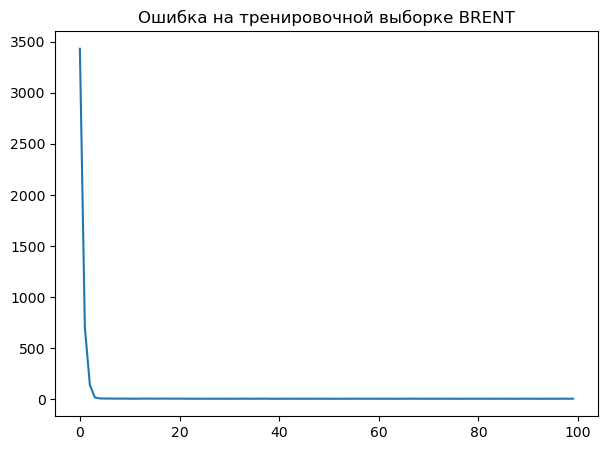

28/28 [==============================] - 1s 26ms/step


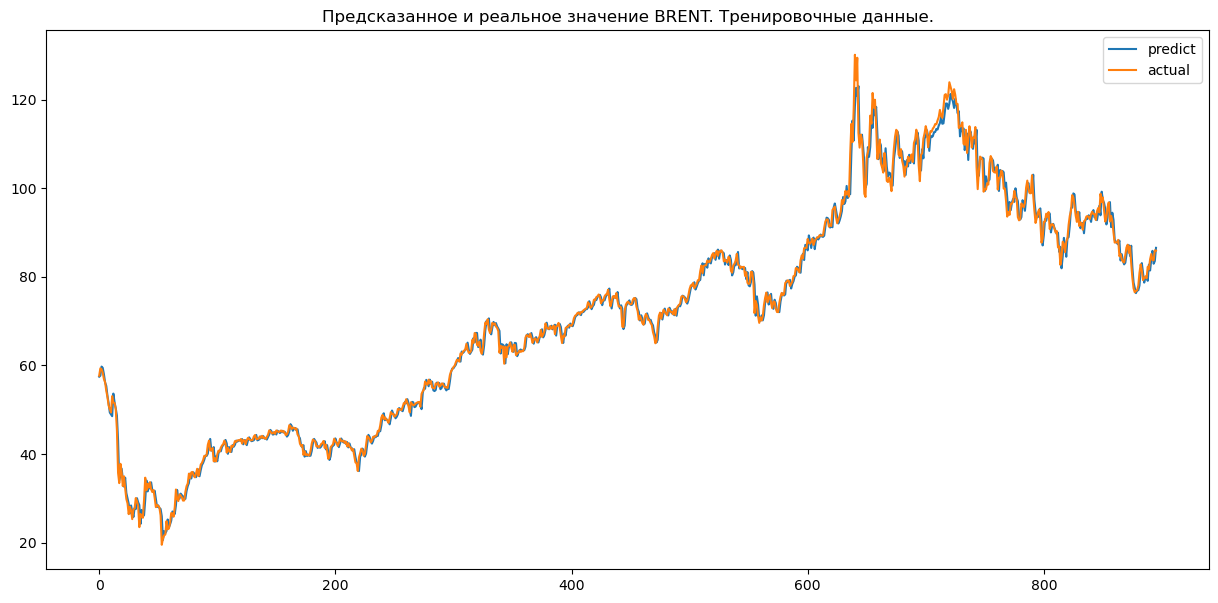

2/2 [==============================] - 0s 10ms/step


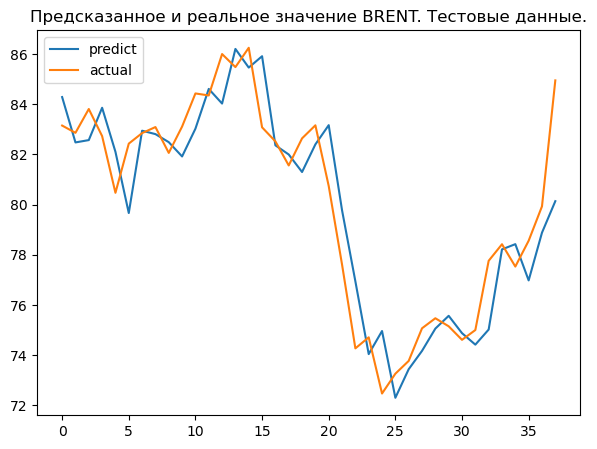

2/2 [==============================] - 0s 11ms/step


In [293]:
model_gru(X_train_brent, y_train_brent, X_test_brent, y_test_brent, 'BRENT', 40)

In [294]:
data_loss_dense_ws = data_loss_dense.loc[8:]
data_loss_rnn_ws = data_loss_rnn.loc[8:]
data_loss_lstm_ws = data_loss_lstm.loc[8:]
data_loss_gru_ws = data_loss_gru.loc[8:]

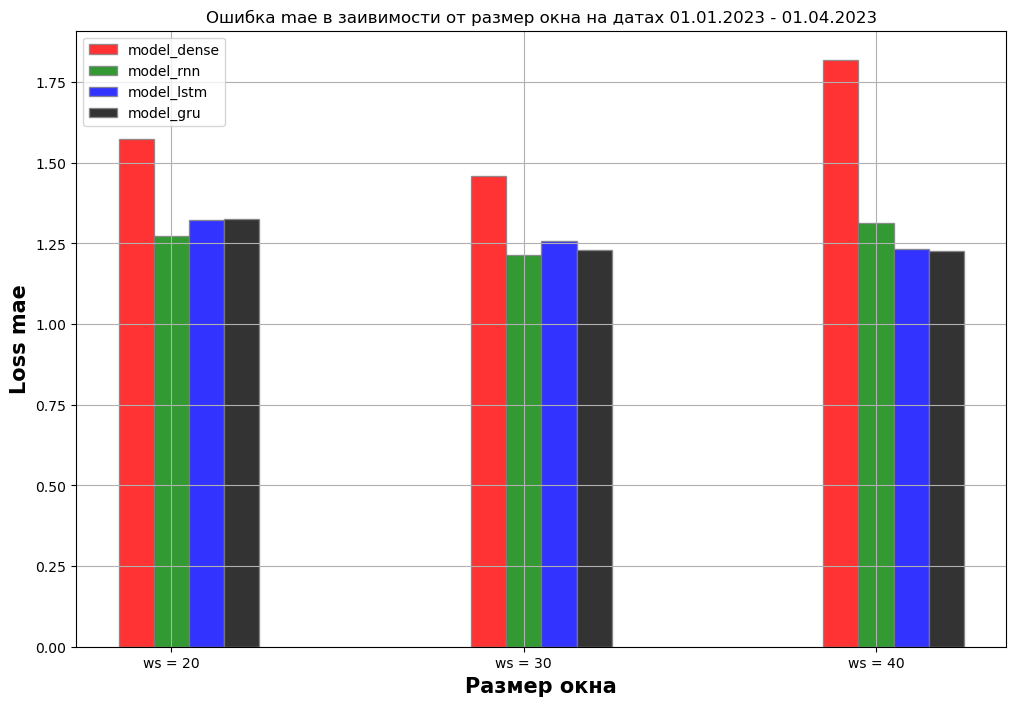

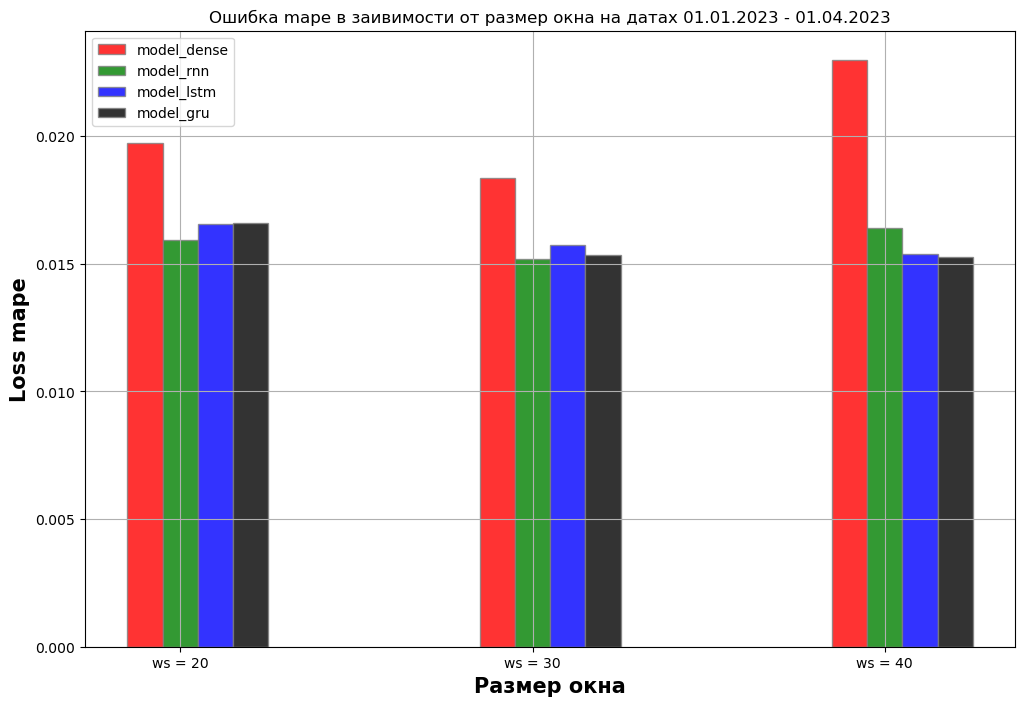

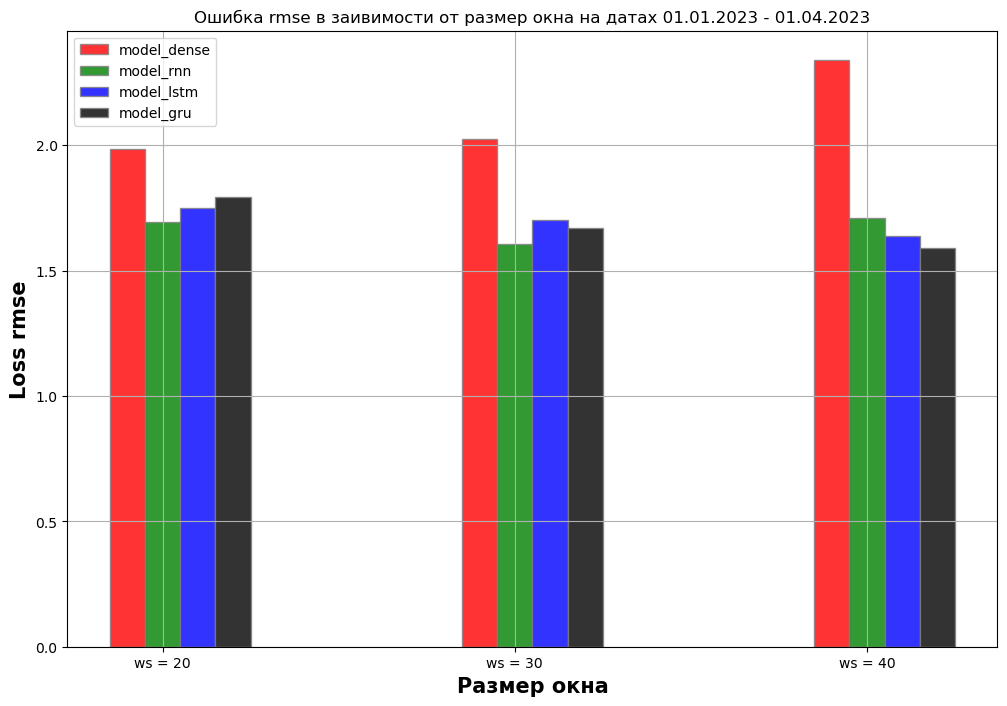

In [295]:
for loss in ['mae','mape','rmse']:
    barWidth = 0.1
    fig = plt.subplots(figsize =(12, 8))
    
    loss_dense = data_loss_dense_ws[(data_loss_dense_ws['sample']=='test')][loss].values
    loss_rnn = data_loss_rnn_ws[(data_loss_rnn_ws['sample']=='test')][loss].values
    loss_lstm = data_loss_lstm_ws[(data_loss_lstm_ws['sample']=='test')][loss].values
    loss_gru = data_loss_gru_ws[(data_loss_gru_ws['sample']=='test')][loss].values


    br1 = np.arange(len(loss_dense))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    

    plt.bar(br1, loss_dense, color ='r', width = barWidth,
            edgecolor ='grey', label ='model_dense', alpha = 0.8)
    plt.bar(br2, loss_rnn, color ='g', width = barWidth,
            edgecolor ='grey', label ='model_rnn', alpha = 0.8)
    plt.bar(br3, loss_lstm, color ='b', width = barWidth,
            edgecolor ='grey', label ='model_lstm', alpha = 0.8)
    plt.bar(br4, loss_gru, color ='black', width = barWidth,
            edgecolor ='grey', label ='model_gru', alpha = 0.8)


    plt.xlabel('Размер окна', fontweight ='bold', fontsize = 15)
    plt.ylabel(f'Loss {loss}', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(loss_dense))],
            ['ws = 20', 'ws = 30', 'ws = 40'])
    plt.title(f'Ошибка {loss} в заивимости от размер окна на датах 01.01.2023 - 01.04.2023')
    plt.grid()
    plt.legend()
    plt.show()